# ZIKV mutational antigenic profiling with broadly neutralizing antibodies

CK prepped samples for deep mutational scanning using known broadly neutralizing antibodies: EDE1-C8, EDE1-C10, and MZ4 alongside ZIKV-targeted mAbs ZKA64 and ZV-67 as positive controls. The virus library is a ZIKV MR766 E-protein virus library first described in Sourisseau et al J Virology.


**EDE1-C8** was prepared at two concentrations, 1600 ng/mL ("C8_1600") and 800 ng/mL ("C8_800").

**EDE1-C10** was prepared at two concentrations, 300 ng/mL ("C10_300") and 150 ng/mL ("C10_150").

**MZ4** was prepared at three concentrations, 4800 ng/mL ("MZ4_4800"), 2400 ng/mL ("MZ4_2400") and 1200 ng/mL ("MZ4_1200").

**SiGN-3C** was prepared at three concentrations, 40 ug/mL ("SiGN_40"), 20 ug/mL ("SiGN_20") and 10 ug/mL ("SiGN_10").

**ZKA64** was prepared at a single concentration, 750 ng/mL ("ZKA64_750"). 

**ZV-67** was prepared at two concentrations, 80 ug/mL ("ZV67_80000") and 40 ug/mL ("ZV67_40000").

All antibody concentrations were incubated with 800,000 IU (MOI 1) of virus library and allowed to infect Vero cells for 24 hours prior to isolating total RNA - see [CK018](https://benchling.com/s/etr-YtBt2dzXr60FGcLKYF1C?m=slm-zQusZO8o9Qc9Egy4lYhe) for details. 

Viral cDNA libraries were generated for next-generation sequencing as outlined in [CK019](https://benchling.com/s/etr-Vp41lo9pFVD1ZcXYw0bM?m=slm-m2YLmBU986a39SRUKDYz).


In [42]:
# import tools
import os
import glob
import numpy
import pandas as pd
import scipy
from functools import reduce
from Bio import SeqIO
import dms_tools2
import dmslogo
from dms_tools2.ipython_utils import showPDF

In [2]:
# set use-existing clause for dms_tools2
use_existing = 'yes'

In [3]:
# ID input/output directories
samplelist = './data/samplelist.csv'
datadir = './data/'
resultsdir = './results/'
os.makedirs(resultsdir, exist_ok=True)

In [4]:
# reference sequences
Erefseq = './data/E.fasta'
subamplicon_alignspecs = './data/subamplicon_alignspecs.txt'

In [5]:
# read in E protein sequence data 
refseq = SeqIO.read(Erefseq, 'fasta')
E_seq = refseq.seq
E_prot = E_seq.translate()

# Bio.SeqIO documention https://biopython.org/wiki/SeqIO

In [6]:
# read in sample list and add the sampleID 'name'
samples = (pd.read_csv(samplelist, index_col=False))
# pd.set_option('display.max_colwidth', None)
# code necessary for more recent versions of pandas (1.above) to set max column width

samples.insert(0, 'name', (samples['library'] + '-' + samples['selection']))
samples.style.hide_index()

In [7]:
# read in align specs
with open (subamplicon_alignspecs, 'r') as file:
    alignspecs = file.read().replace('\n','')
alignspecs

'1,303,33,38 304,609,38,40 610,903,41,36 904,1200,41,37 1201,1512,36,35'

In [8]:
# process deep sequencing data: run dms2_batch_subamp

# make folder where codon counts will go
codons_batch_subamp = os.path.join(resultsdir + 'codoncounts')
os.makedirs(codons_batch_subamp, exist_ok=True)

# tell me if sample path is missing
for c in samples['R1']:
    if c == 'NaN':
       raise ValueError('samples is missing a file path')

# create df and export csv with only name/R1 for dms2_batch_subamp   
batchfile = os.path.join(datadir + 'batchSubampIDs.csv')
samples[['name','R1']].to_csv(batchfile, index=False)

# standard trim in Bloom lab analyses is 200 bp
# from documentation: "removes low-quality nucleotides that tend to be at the end of long reads"
R1TRIM = 200
R2TRIM = 200

#needs a name to run
baka = ! dms2_batch_bcsubamp \
    --batchfile {batchfile} \
    --refseq {Erefseq} \
    --alignspecs {alignspecs} \
    --outdir {codons_batch_subamp} \
    --summaryprefix summary \
    --R1trim 200 \
    --R2trim 200 \
    --ncpus 16 \
    --use_existing {use_existing}

# ! executes following code in the command line

# add column to df.samples that includes filepath to each codoncounts.csv
samples['codoncounts'] = codons_batch_subamp + '/' + samples['name'] + '_codoncounts.csv'

# tell me how you did
print(f'dms2_batch_bcsubamp {dms_tools2.__version__} aligned sequencing data and created codon count files in {codons_batch_subamp}')

dms2_batch_bcsubamp 2.6.10 aligned sequencing data and created codon count files in ./results/codoncounts


# Library sequencing quality control 
Now we'll examine some key QC aspects such as deep sequencing coverage, barcode sampling, subamplicon balancing, etc.

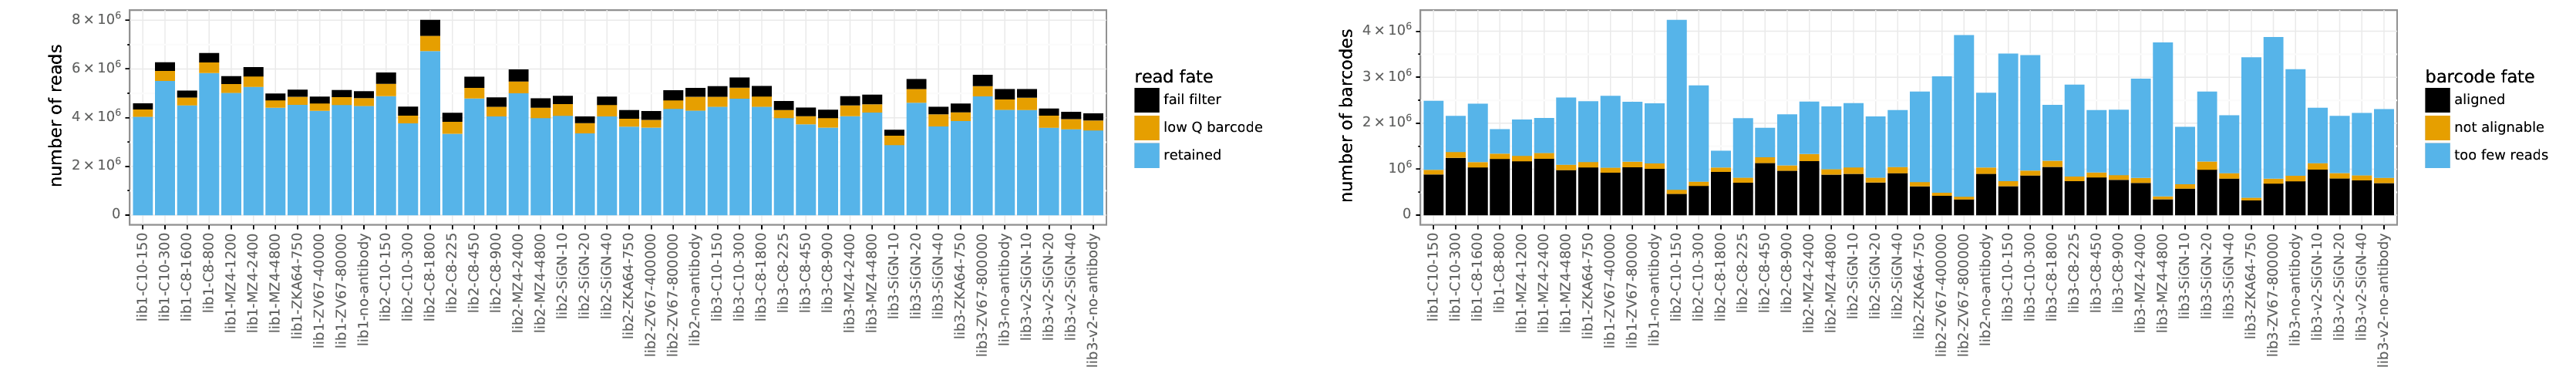

In [9]:
summary = codons_batch_subamp + "/summary_"

showPDF([os.path.join(summary + "readstats.pdf"),
         os.path.join(summary + "bcstats.pdf")])

LEFT, ABOVE: reads per sample. Per CK019 bottleneck calculations, we required ~4.5e6 per sample. This is below target as most samples are around 3e6 reads. We knew that 2 MiSeq flowcells might not be sufficient... this may be an indication of that. We can simply submit more prep for sequencing if we decide to. 

RIGHT, ABOVE: barcodes per sample. Target was 1.5e6 barcodes per sample. Aligned barcodes misses this target, with all samples falling in the 5e5-1e6 range. 

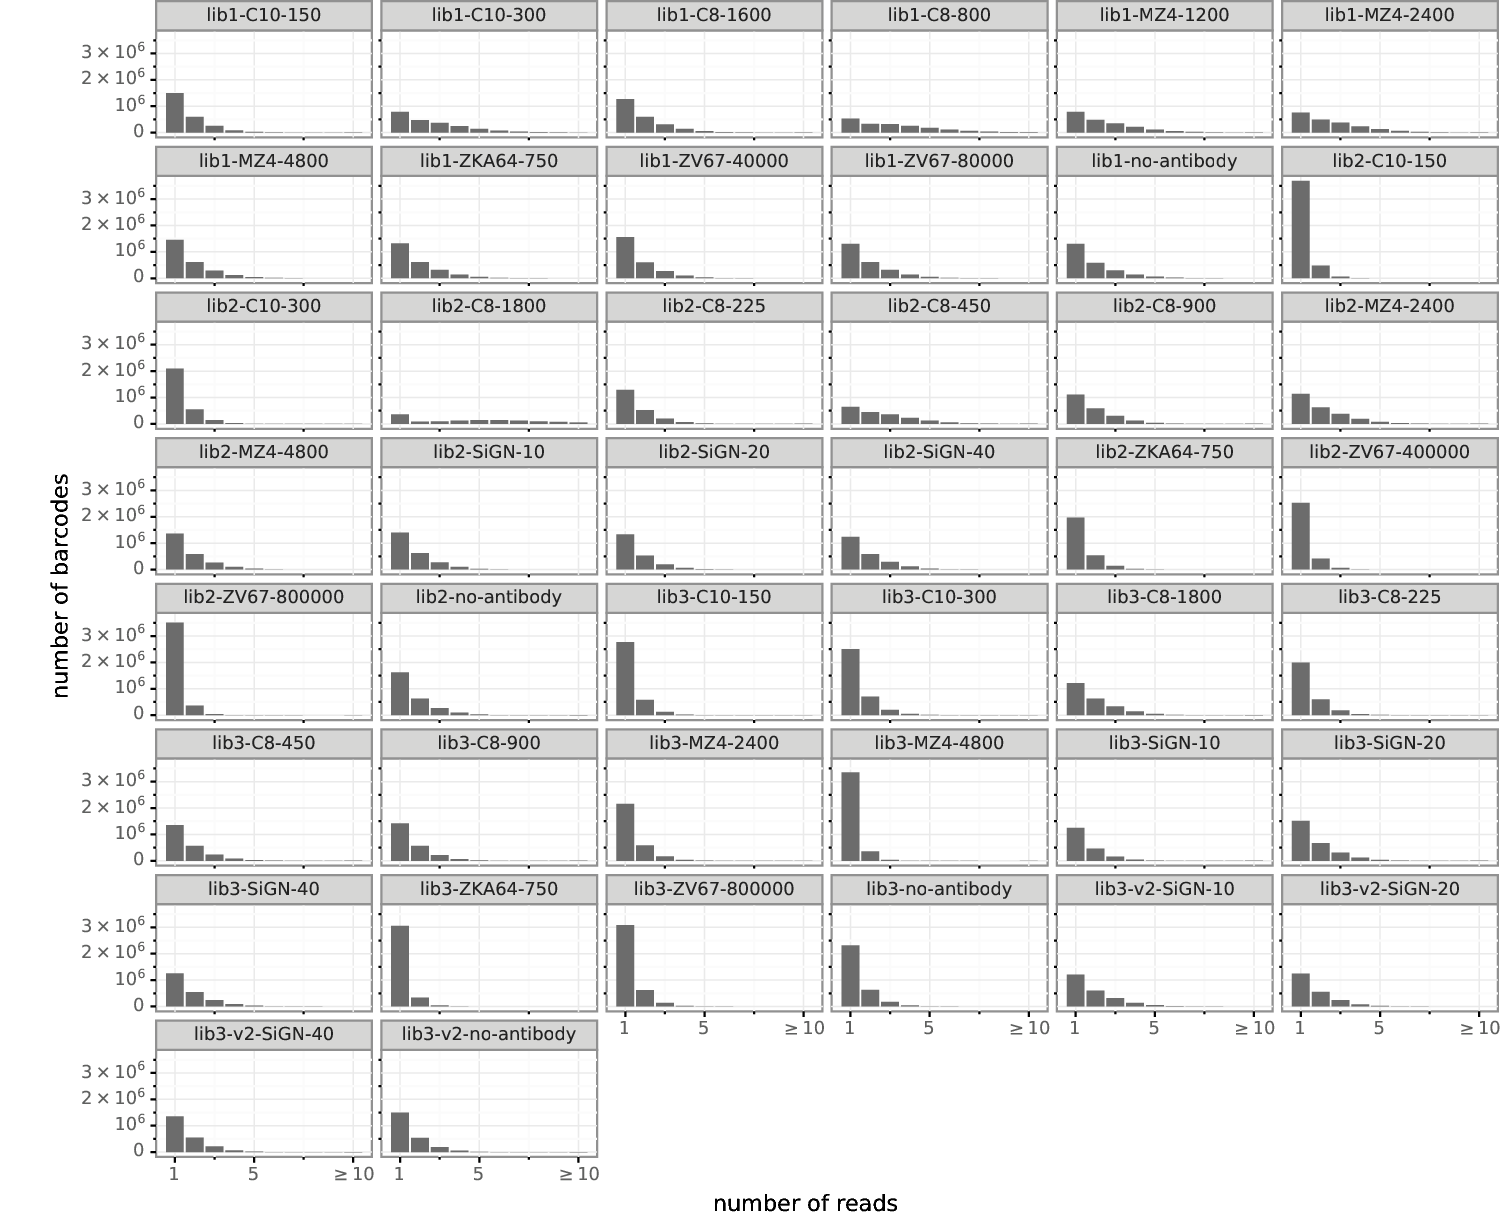

In [10]:
showPDF(os.path.join(summary + "readsperbc.pdf"))

ABOVE: reads per barcode. We need to read barcodes at least 2 times to error correct, but in many samples it looks like the majority of barcodes are being read once. This is likely due to insufficient sequencing depth.

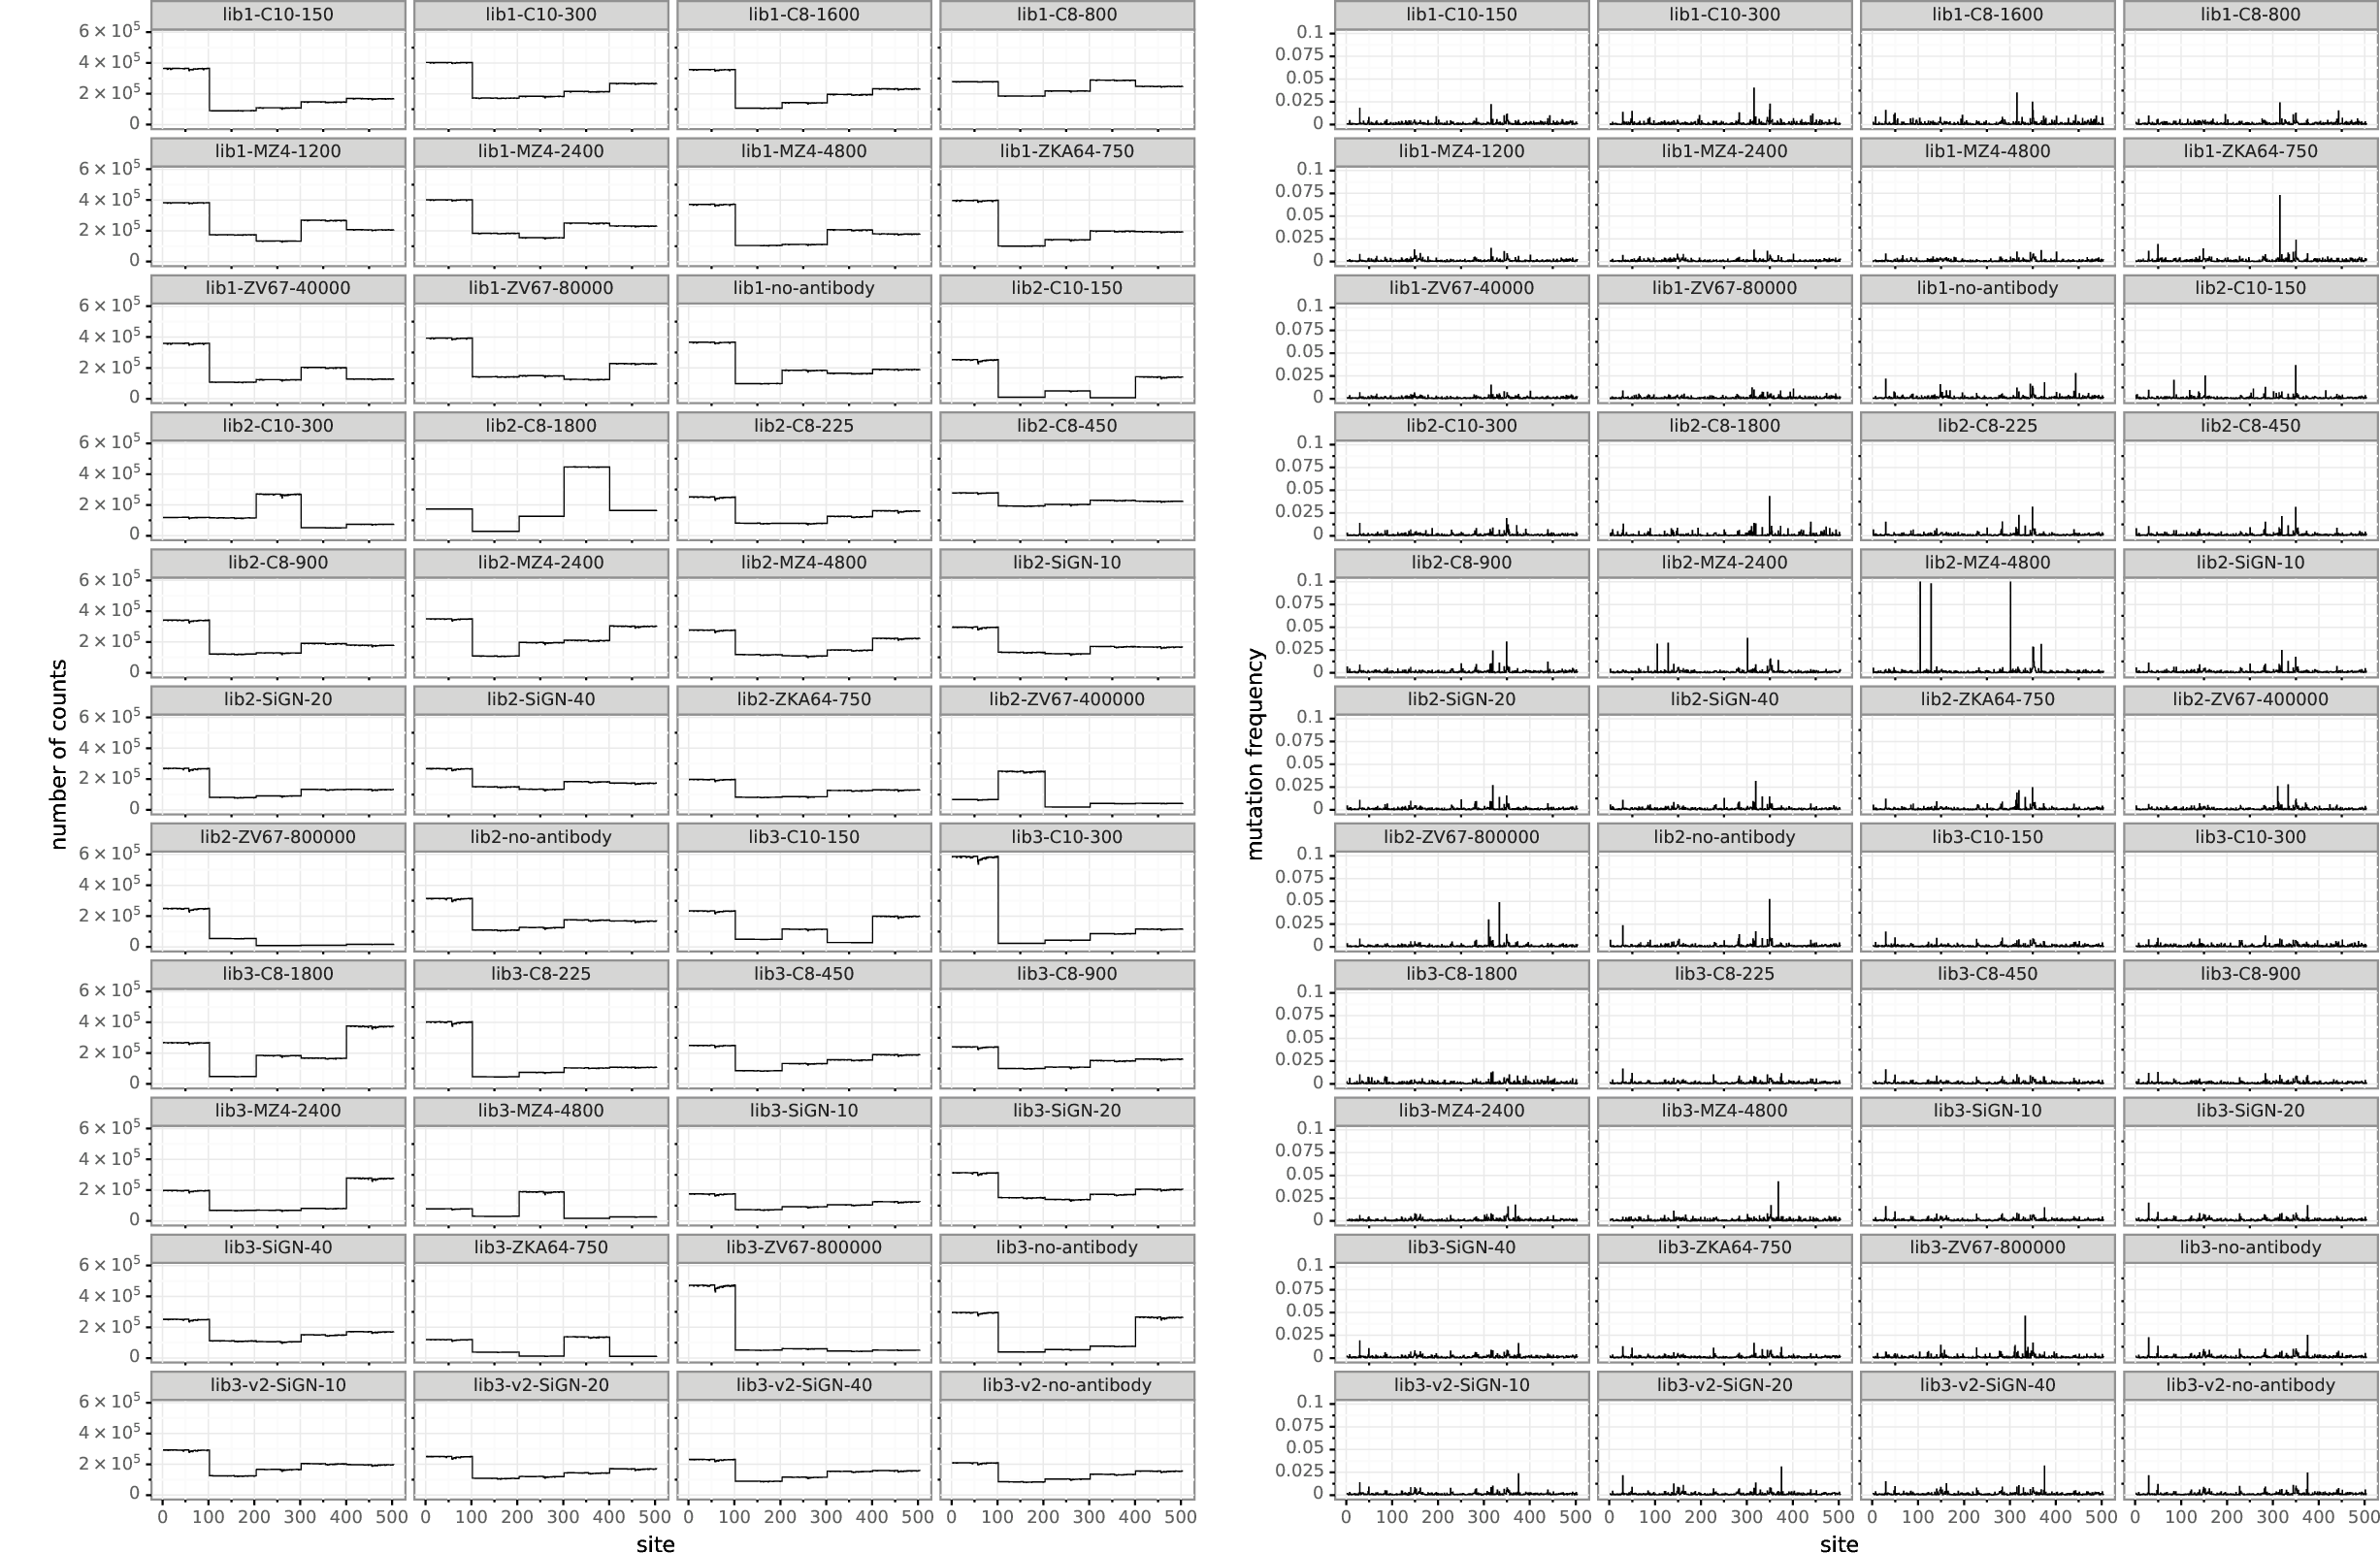

In [11]:
showPDF([os.path.join(summary + 'depth.pdf'),
         os.path.join(summary + 'mutfreq.pdf')])

LEFT, ABOVE: sequencing depth across 6 subamplicons. This looks quite uneven, especially compared to JBS083. Hopefully this resolves when we sequence more. 
RIGHT, ABOVE: mutation frequency across 6 subamplicons. Exciting to see probable selection taking place in some samples. 

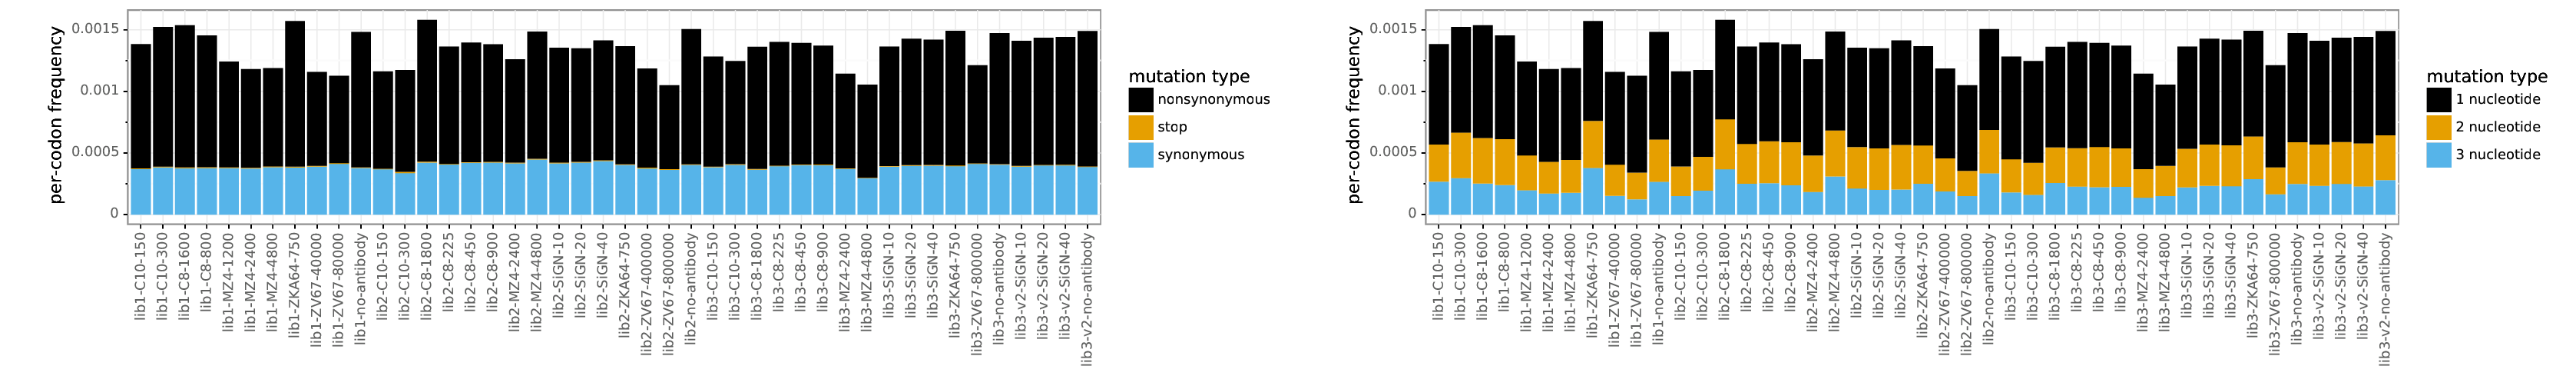

In [12]:
showPDF([os.path.join(summary + 'codonmuttypes.pdf'),
         os.path.join(summary + 'codonntchanges.pdf')])

LEFT, ABOVE: per-codon frequency of nonsynonymous, stop and synonymous mutations across samples. As expected, we see purging of stop codons in all my samples. 
RIGHT, ABOVE: per-codon frequency of 1-, 2-, or 3-nuc mutations across samples.

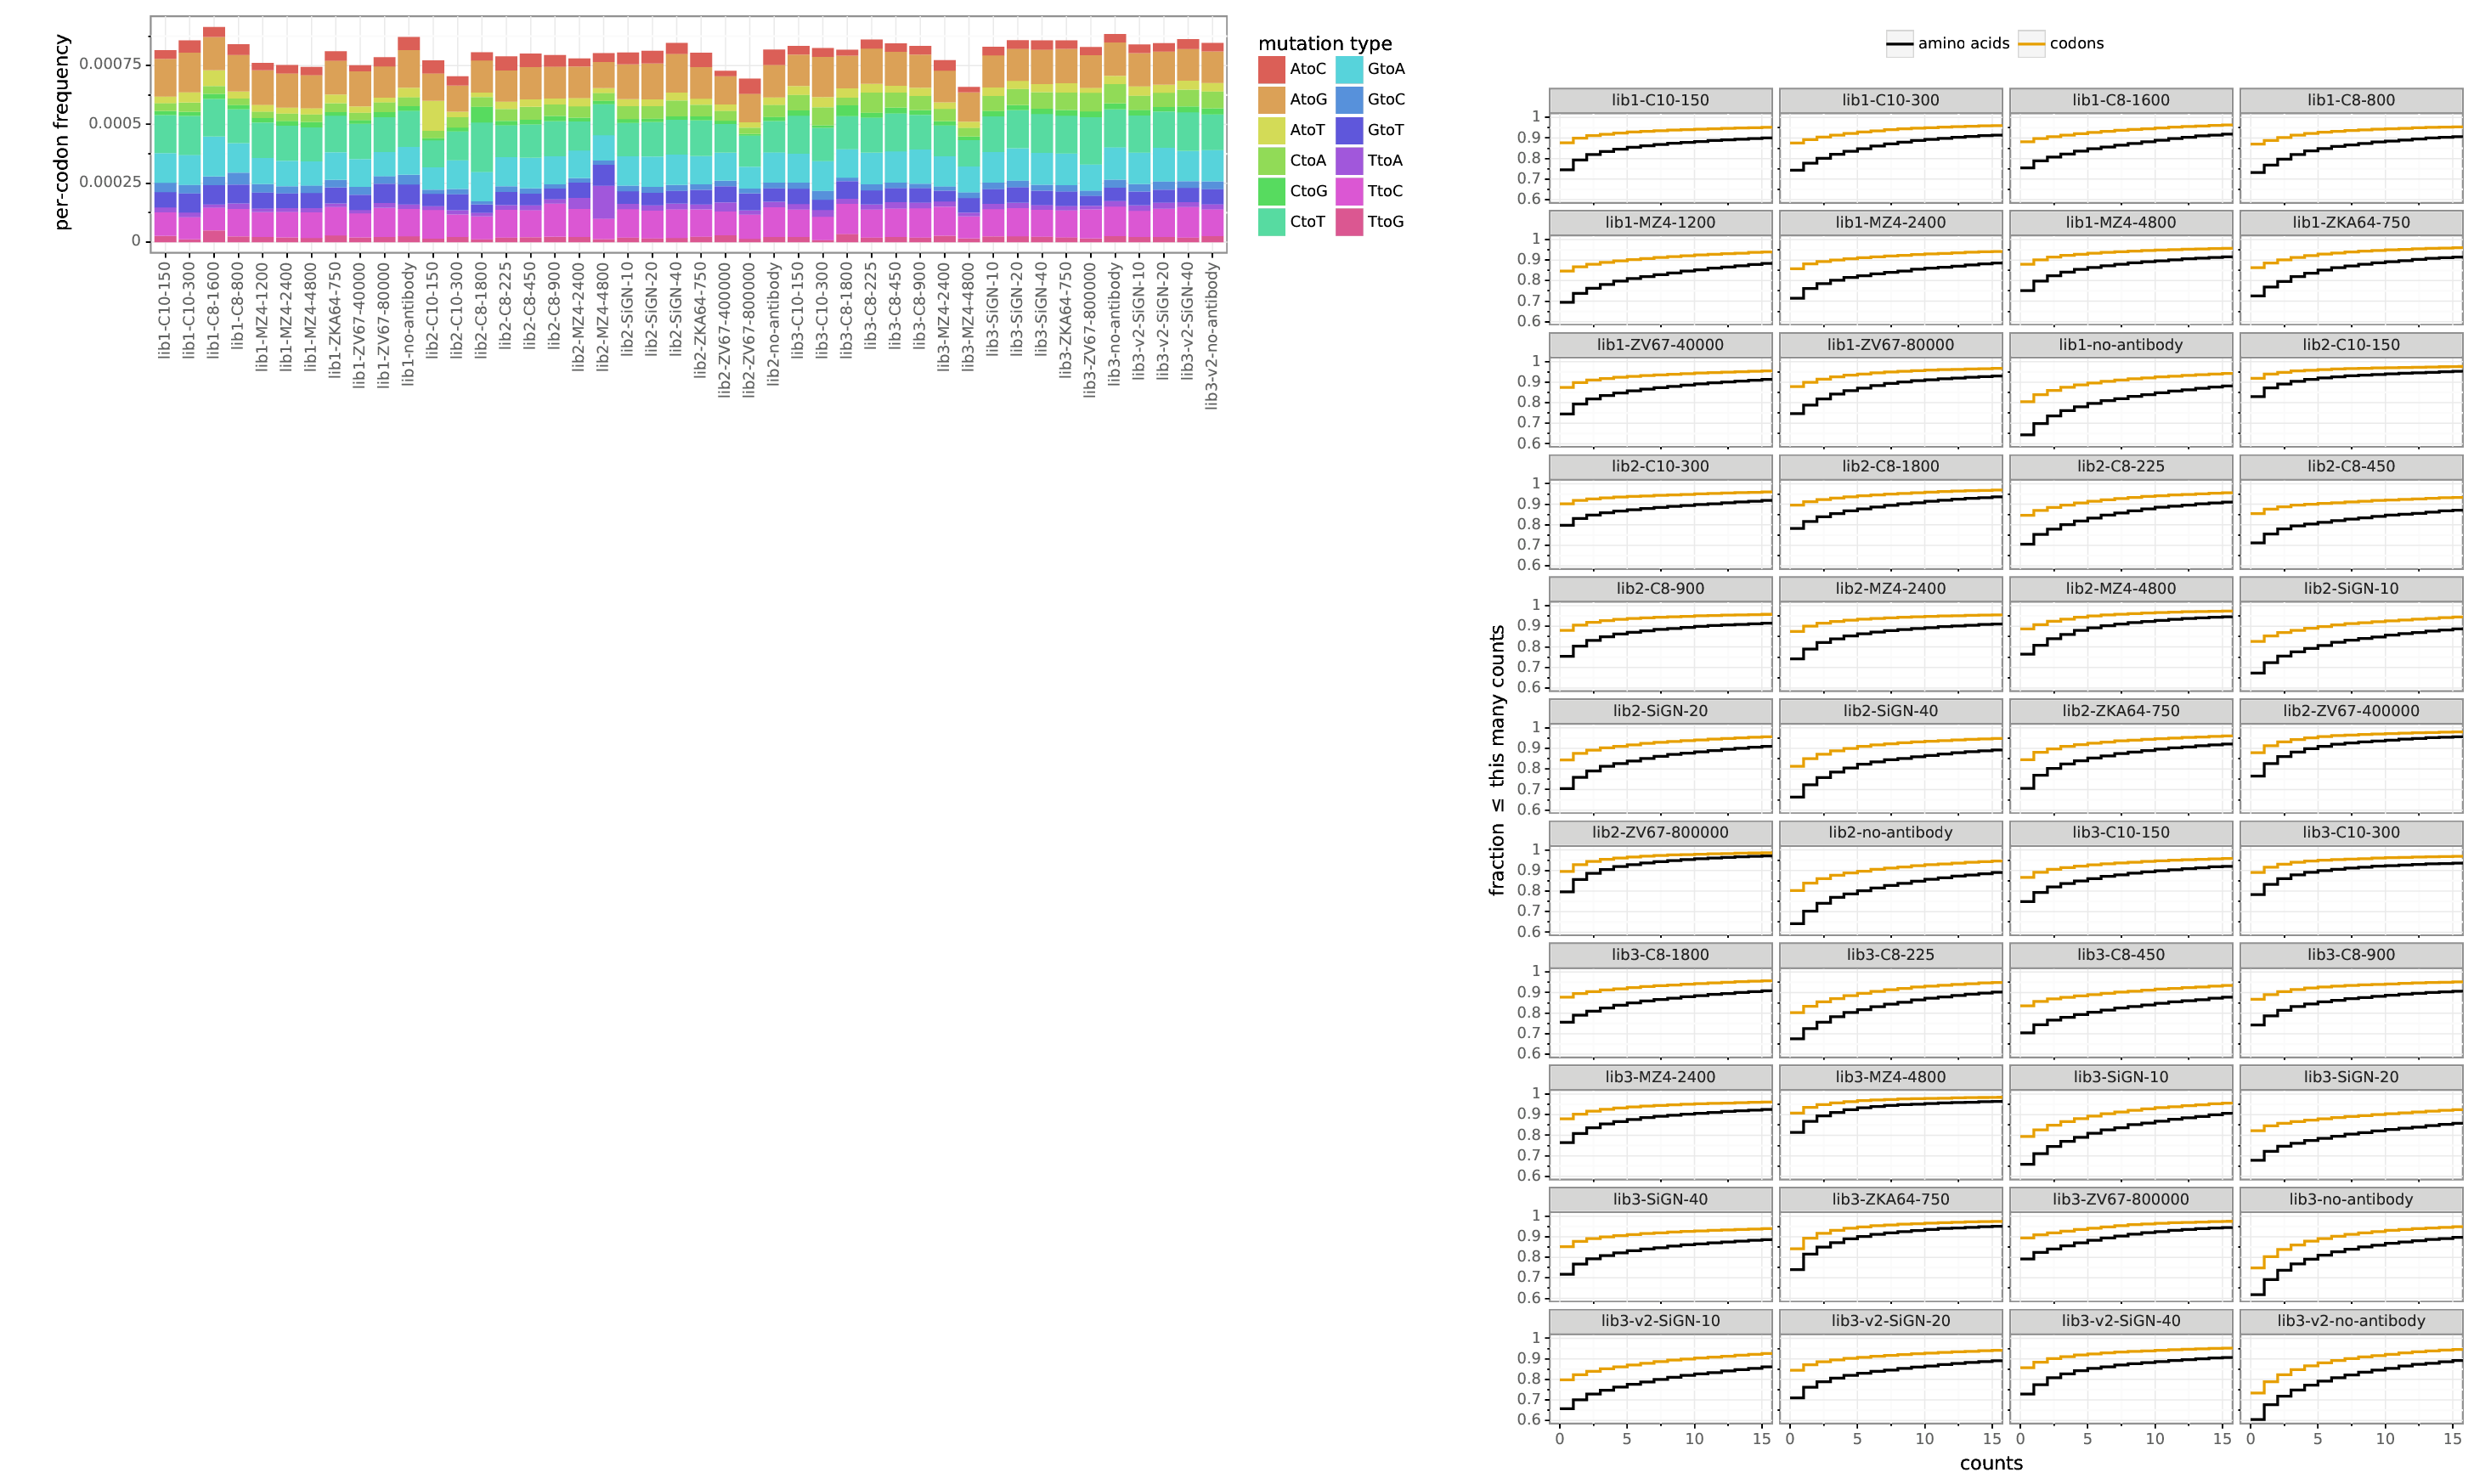

In [13]:
showPDF([os.path.join(summary + 'singlentchanges.pdf'),
         os.path.join(summary + 'cumulmutcounts.pdf')])

LEFT, ABOVE: per-codon frequency of various mutation types to evaluate for oxidative damage.
RIGHT, ABOVE: fraction of mutations that occurs a given #(count) of times. The no-ab (no antibody) control contains more diversity than the antibody- or serum-selected conditions.

# Differential selection

Next, I will use [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) to compute differential selection at each site along E protein in each sample. 

In [14]:
# make directory for individual concentrations diffsel results
diffseldir = os.path.join(resultsdir + 'diffsel')
os.makedirs(diffseldir, exist_ok = True)

In [15]:
# make batchfile for diffsel
# must contain selection column 'sel'
# must contain mock column 'mock'
# may contain error correction column 'err'

diffsel_batch = (
    samples
    .query('selection != "no-antibody"')
    .assign(sel = lambda x: x['name'],
            group = lambda x: x['antibody'],
            mock = lambda x: x['library'] + '-no-antibody')
    .drop(columns = ['R1', 'name'])
    # .drop(none_index)
    # .drop(noAb_index)
    .assign(name = lambda x: x['library']+'-'+x['selection'])
    # .rename(columns = {'library' : 'name'})
    [['library','group', 'name', 'sel', 'mock', 'percent_infectivity']]
    .reset_index(drop = True)
    )
diffsel_batch.head()

library     group           name            sel              mock  \
0    lib1  EDE1-C10   lib1-C10-150   lib1-C10-150  lib1-no-antibody   
1    lib1  EDE1-C10   lib1-C10-300   lib1-C10-300  lib1-no-antibody   
2    lib1   EDE1-C8   lib1-C8-1600   lib1-C8-1600  lib1-no-antibody   
3    lib1   EDE1-C8    lib1-C8-800    lib1-C8-800  lib1-no-antibody   
4    lib1       MZ4  lib1-MZ4-1200  lib1-MZ4-1200  lib1-no-antibody   

  percent_infectivity  
0               0.51%  
1               0.11%  
2               0.01%  
3               0.57%  
4               5.22%

In [16]:
# write individual concentration diffsel batchfile to csv
diffsel_batchfile = os.path.join(diffseldir + '/batch.csv')
diffsel_batch.to_csv(diffsel_batchfile, index = False)

# run dms2_batch_diffsel for individual concentration batchfile
baka = ! dms2_batch_diffsel \
        --batchfile {diffsel_batchfile} \
        --summaryprefix summary \
        --indir {codons_batch_subamp} \
        --outdir {diffseldir} \
        --ncpus 16 \
        --use_existing {use_existing}

## Calculating correlation between pseudo-technical replicates
We can consider antibodies tested at mutiple concentraitons as pseudo-technical replicates and see how well they correlate. If these pseudo-technical replicates do correlate, we could combine data and calcualte differential selection that way. 


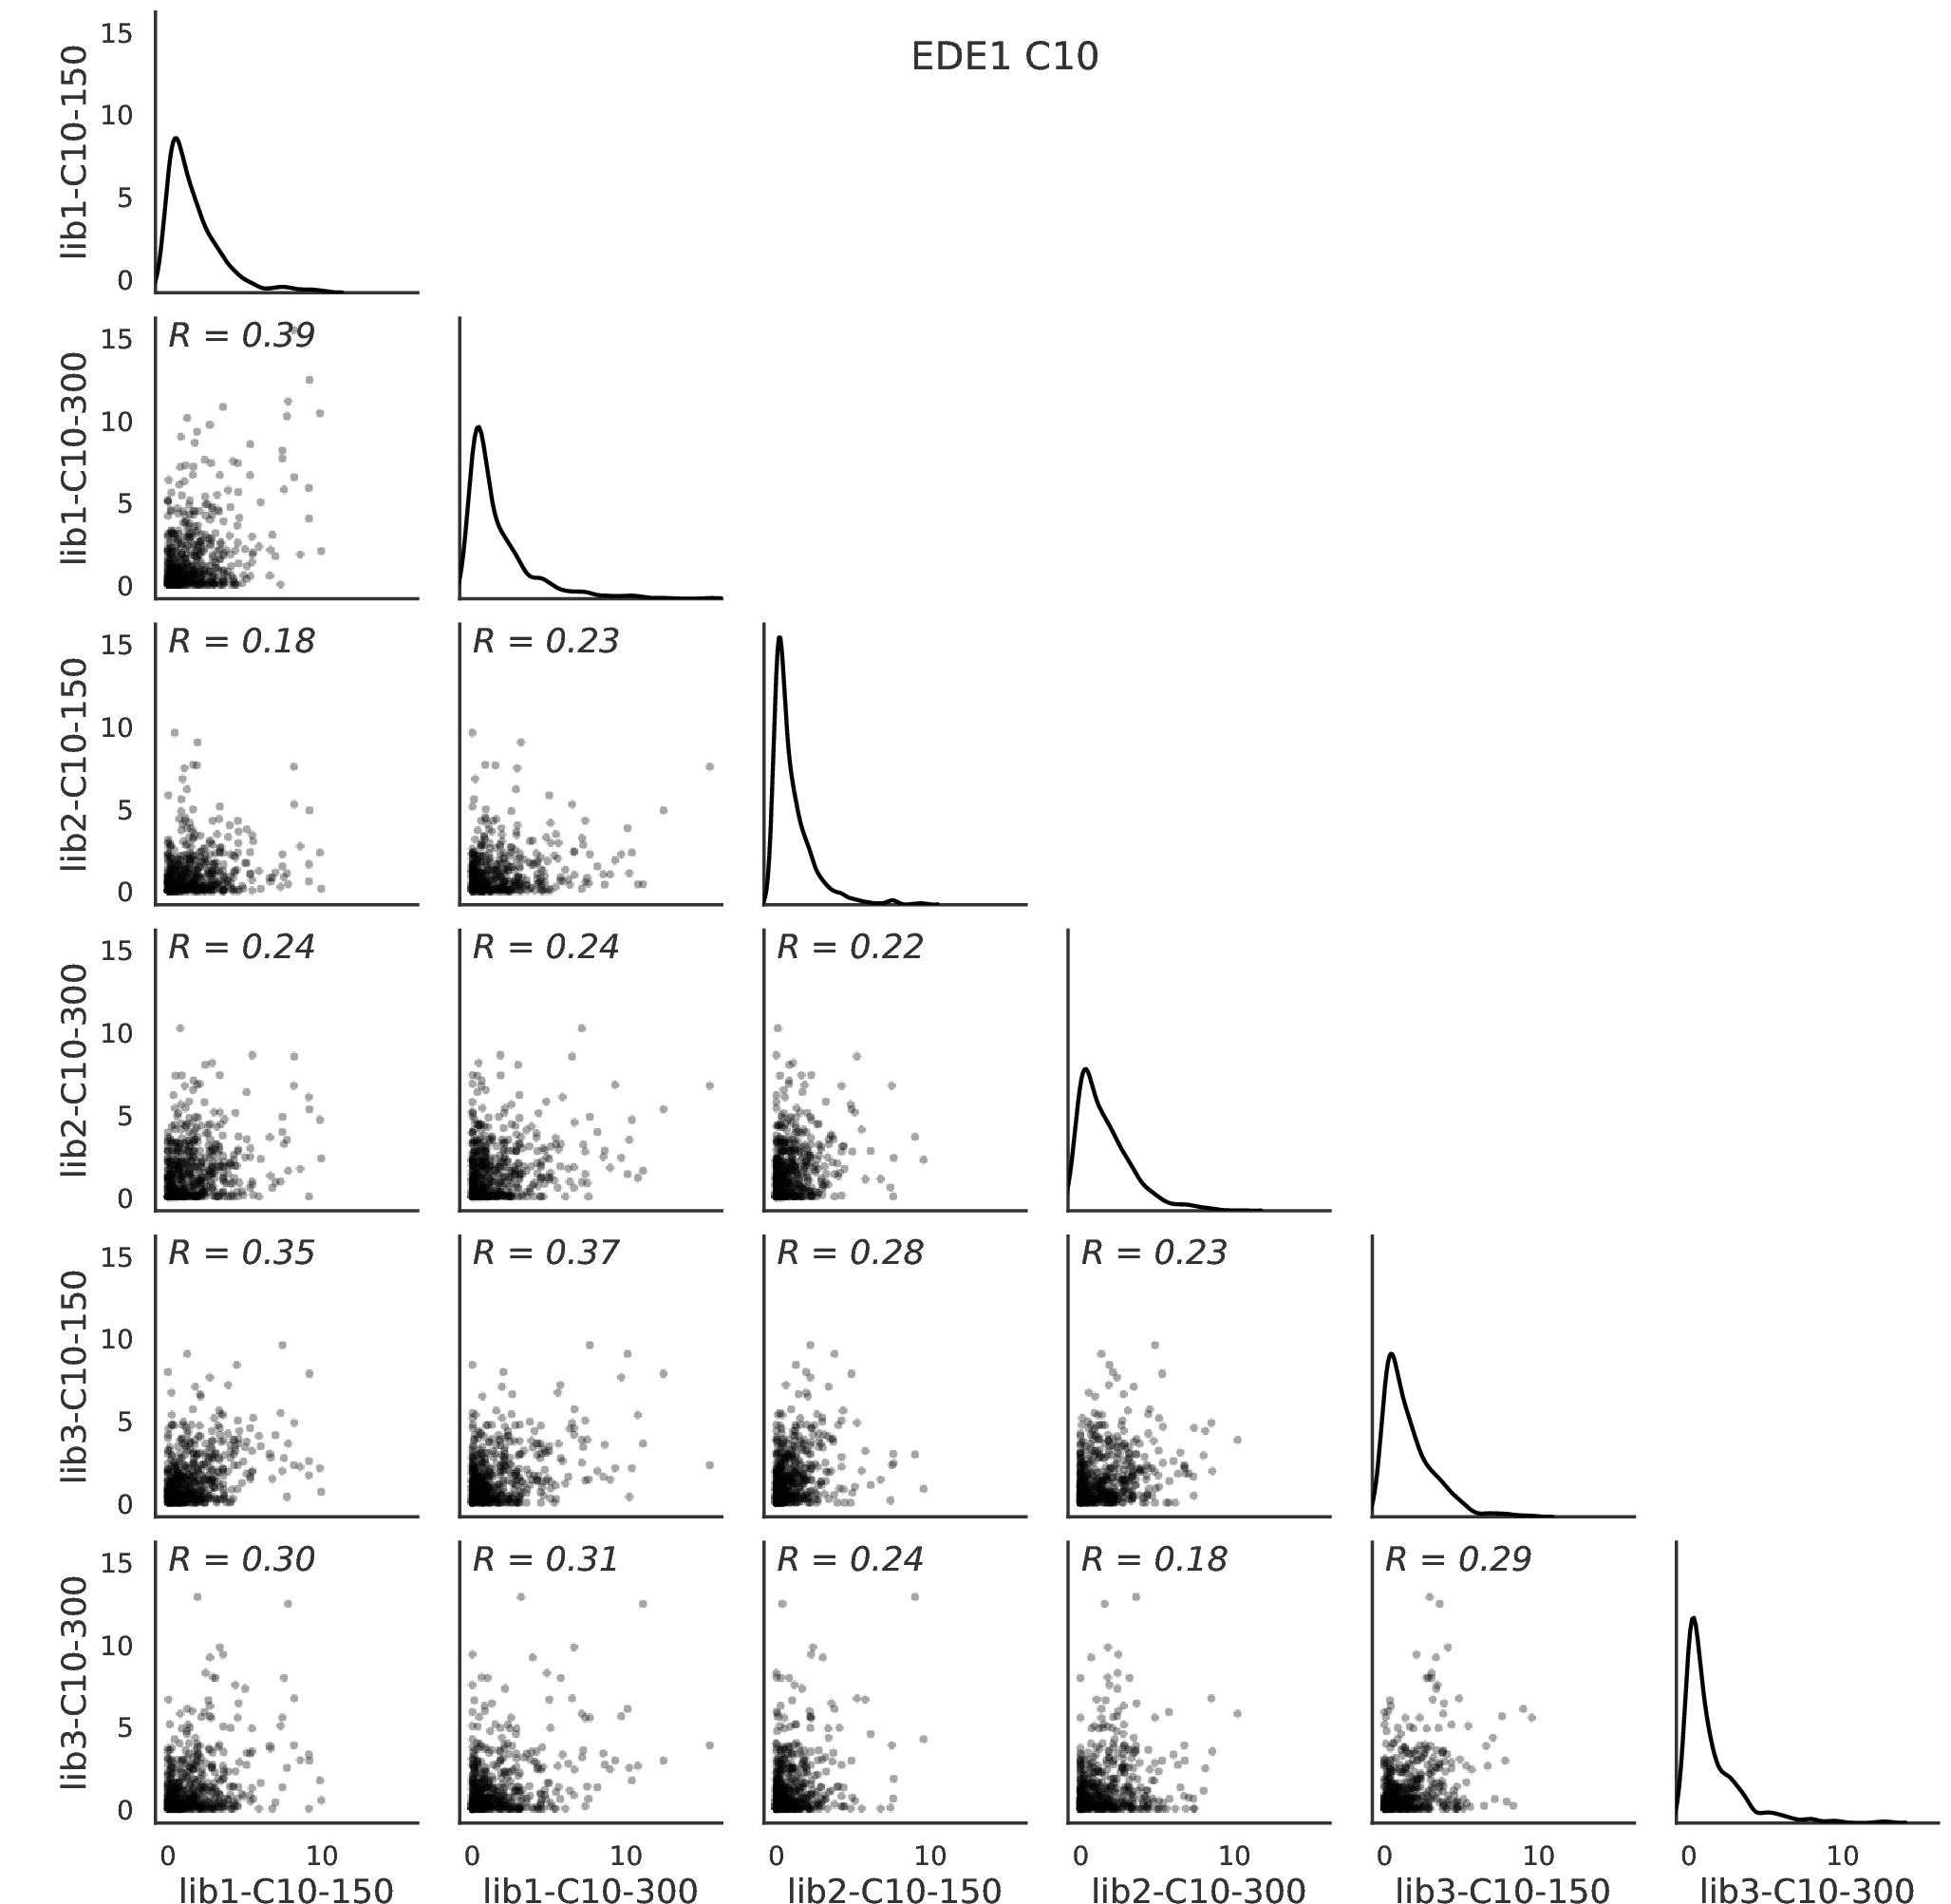

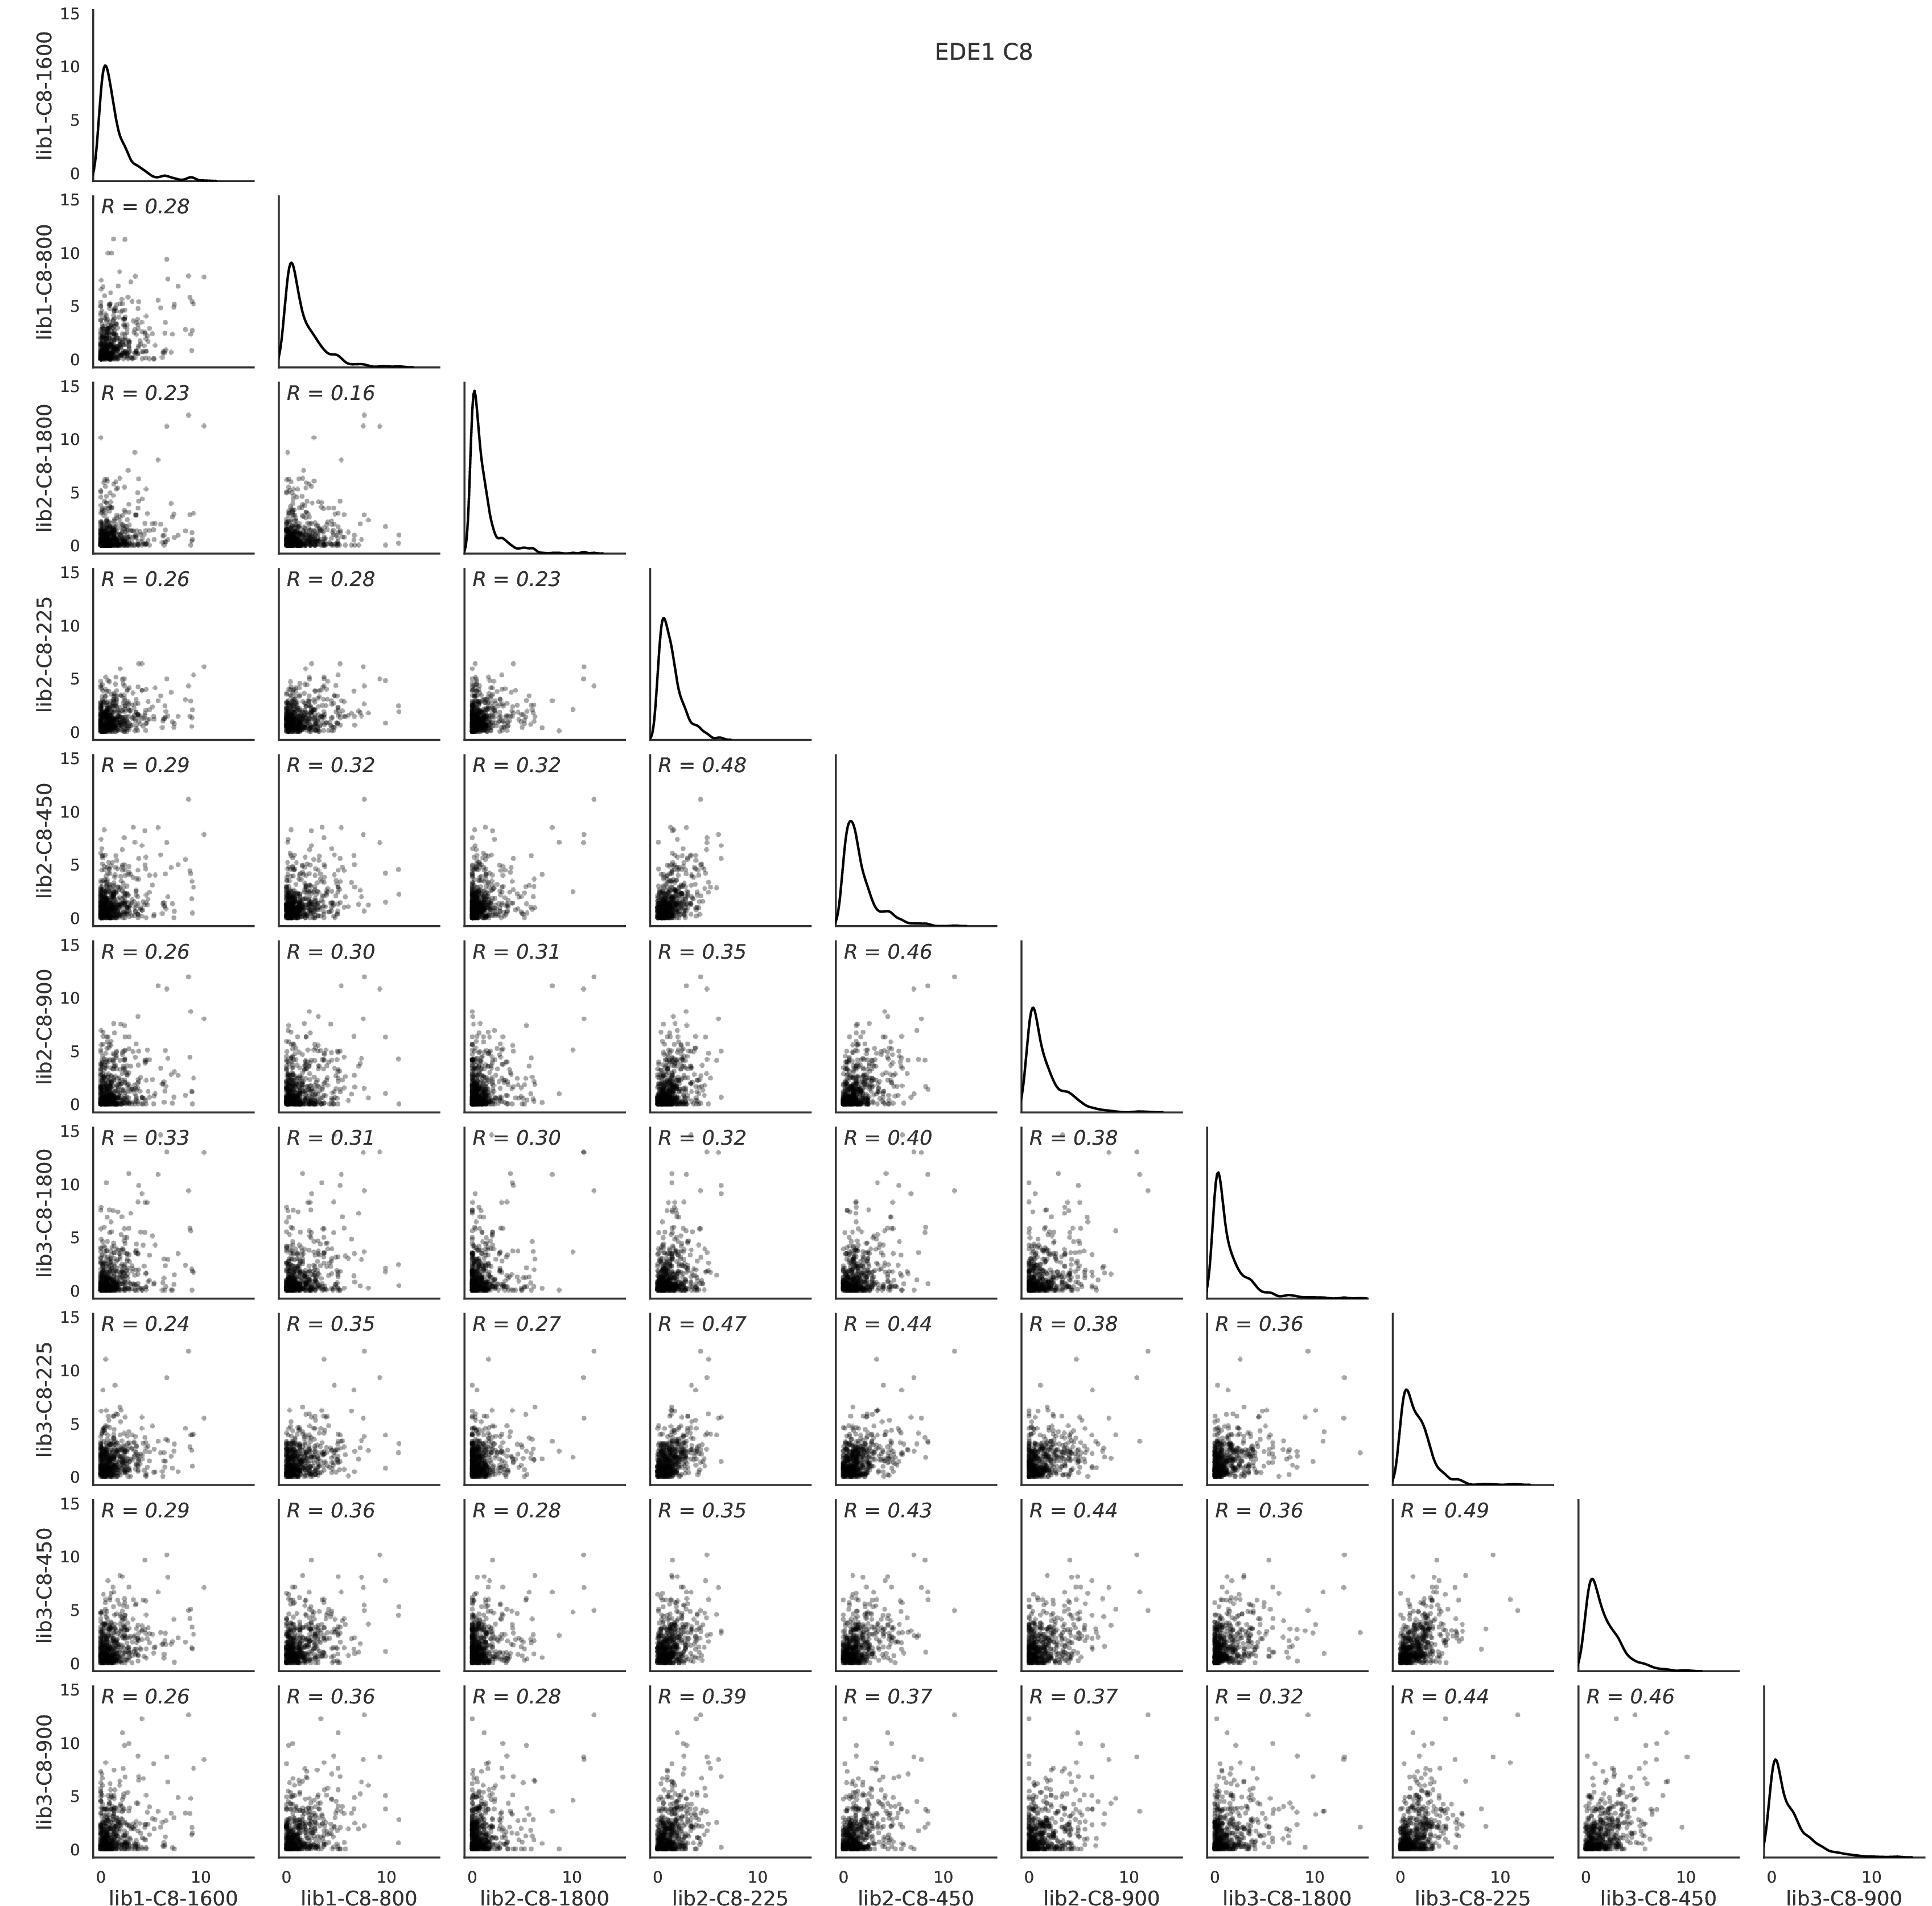

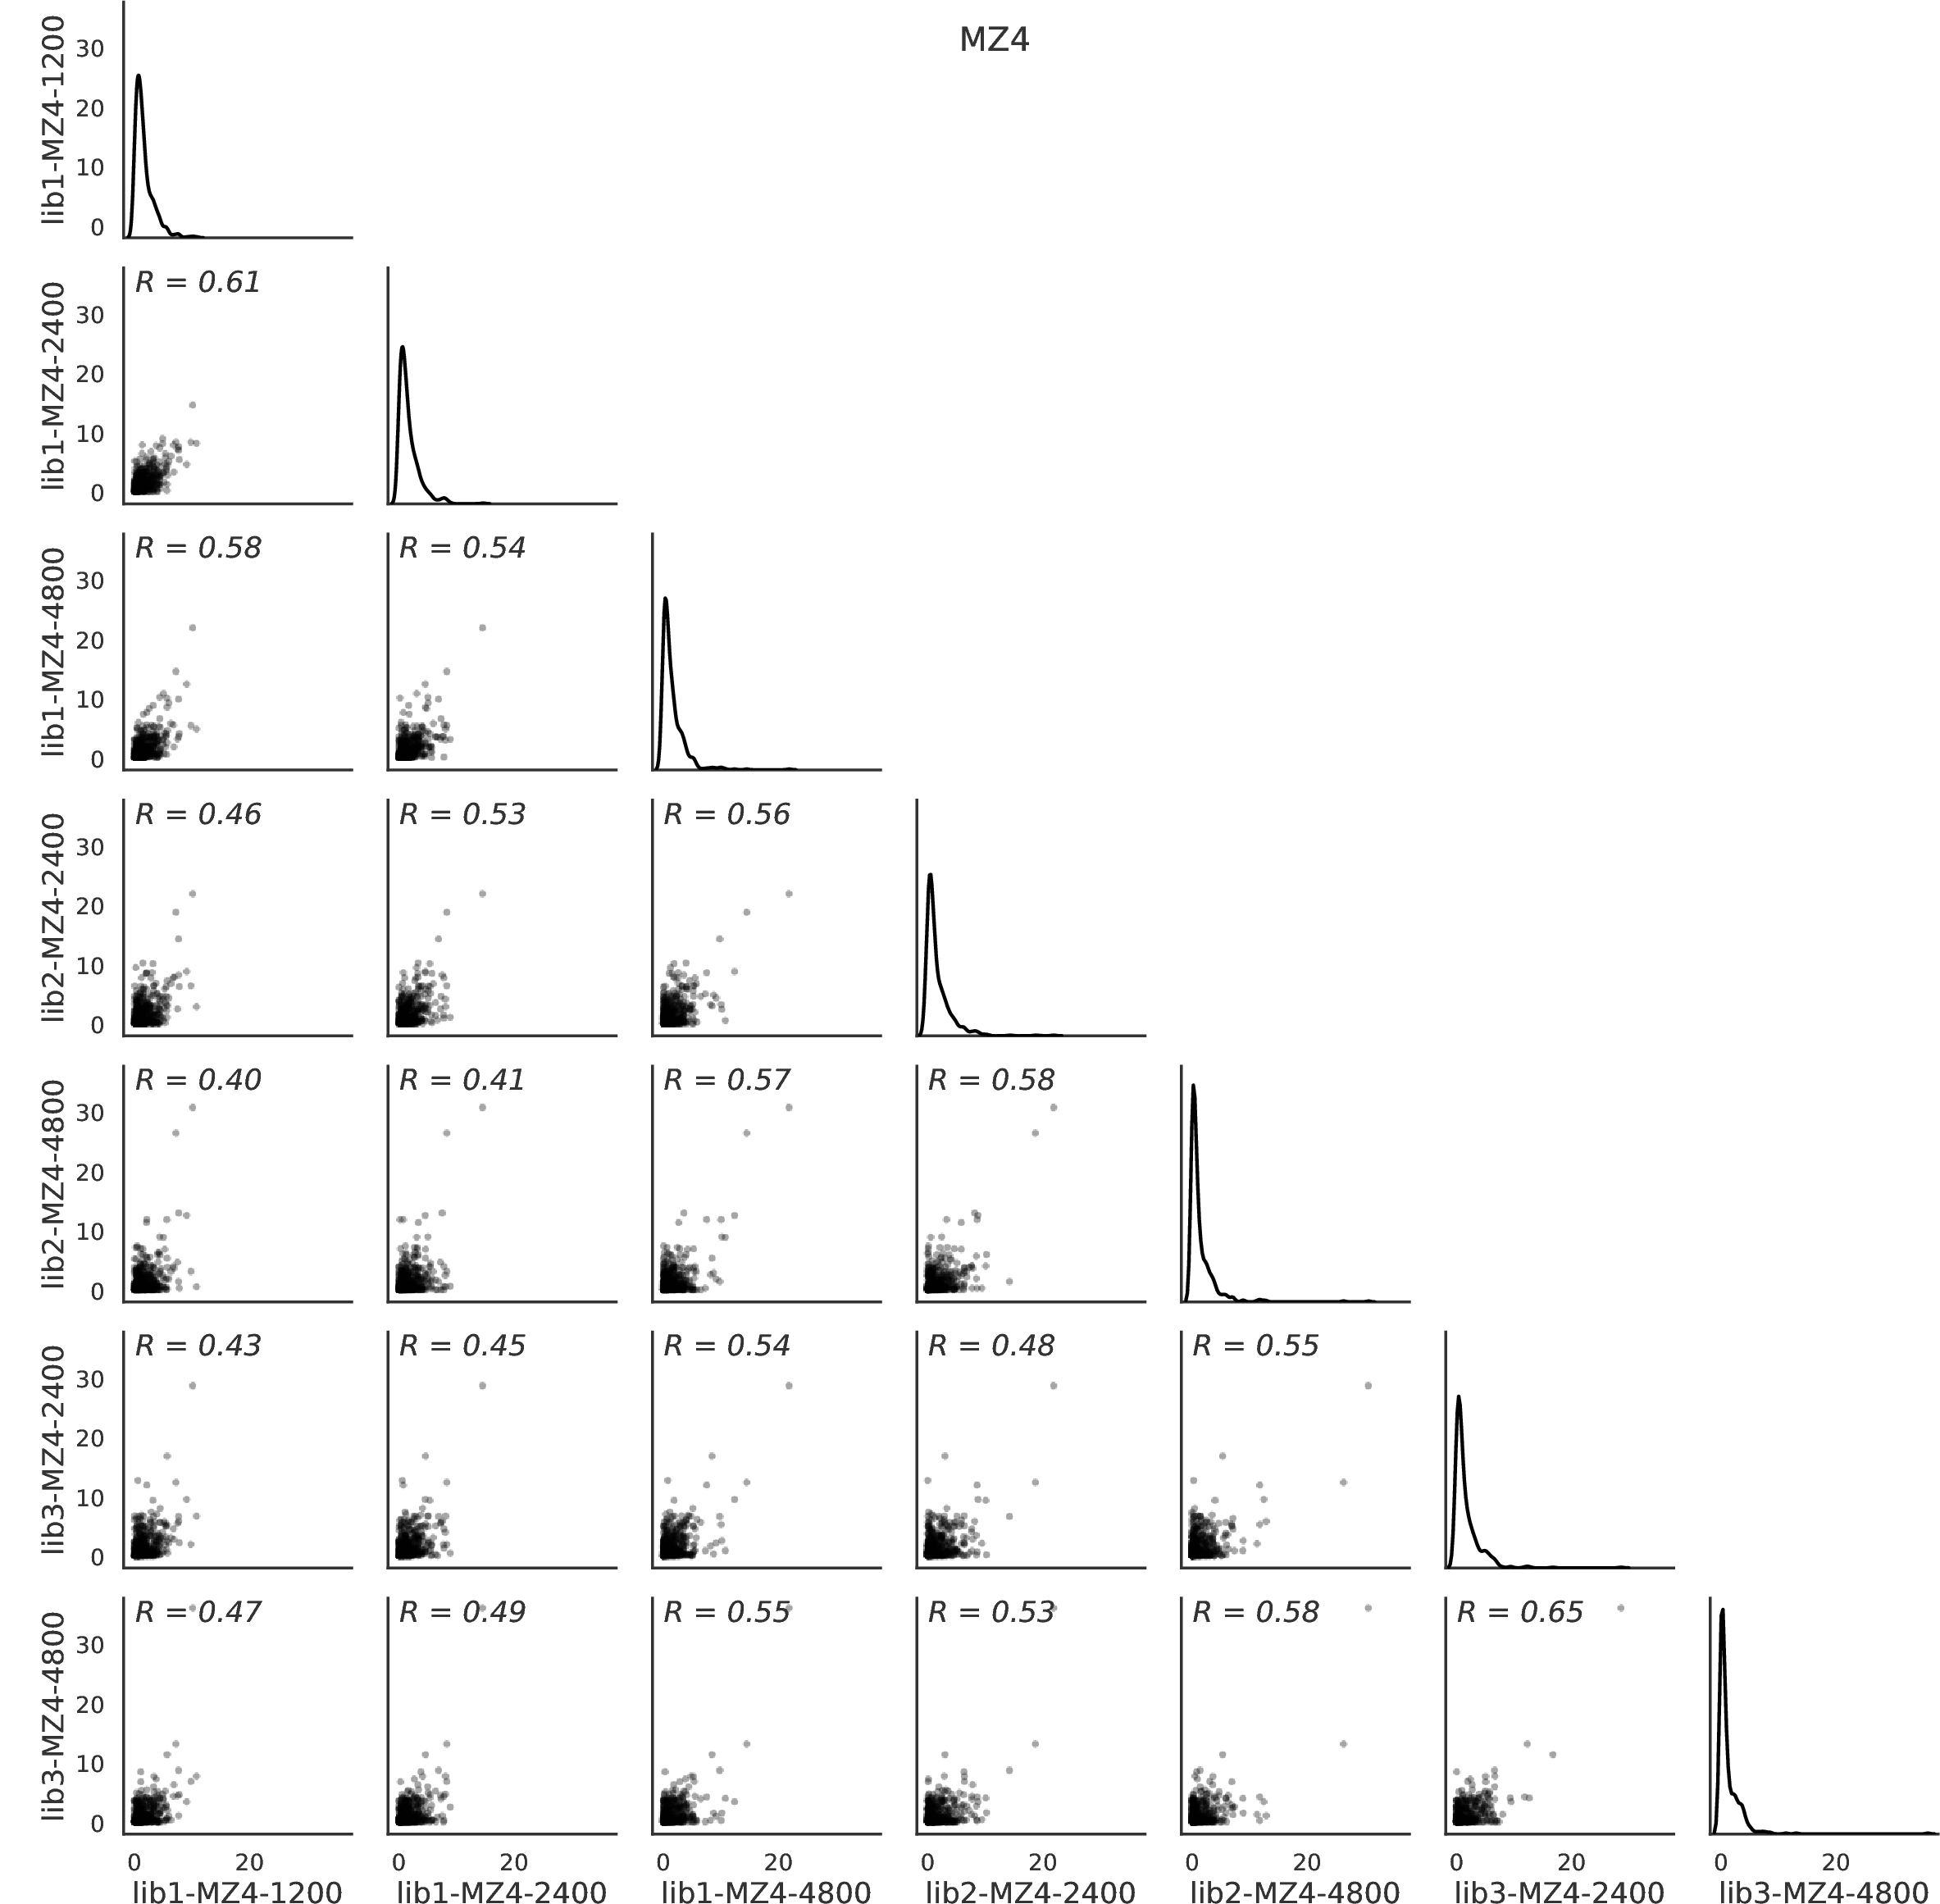

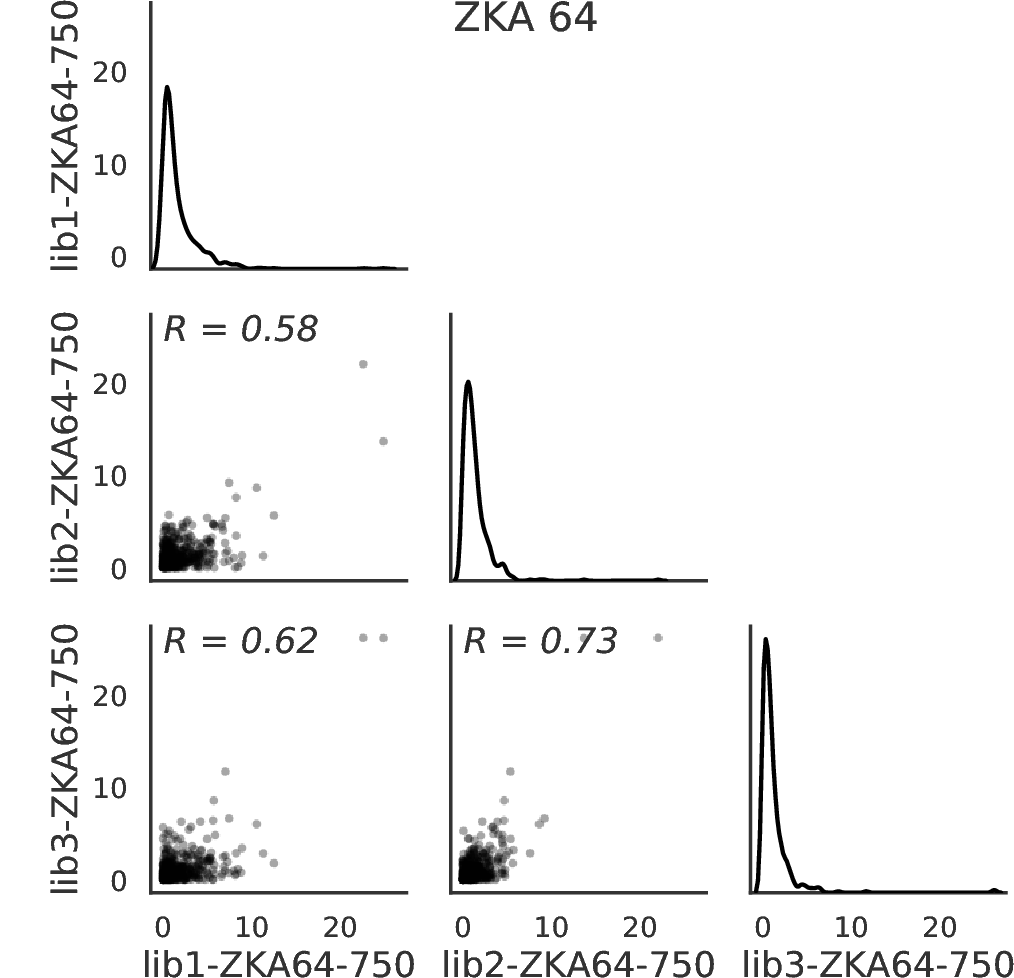

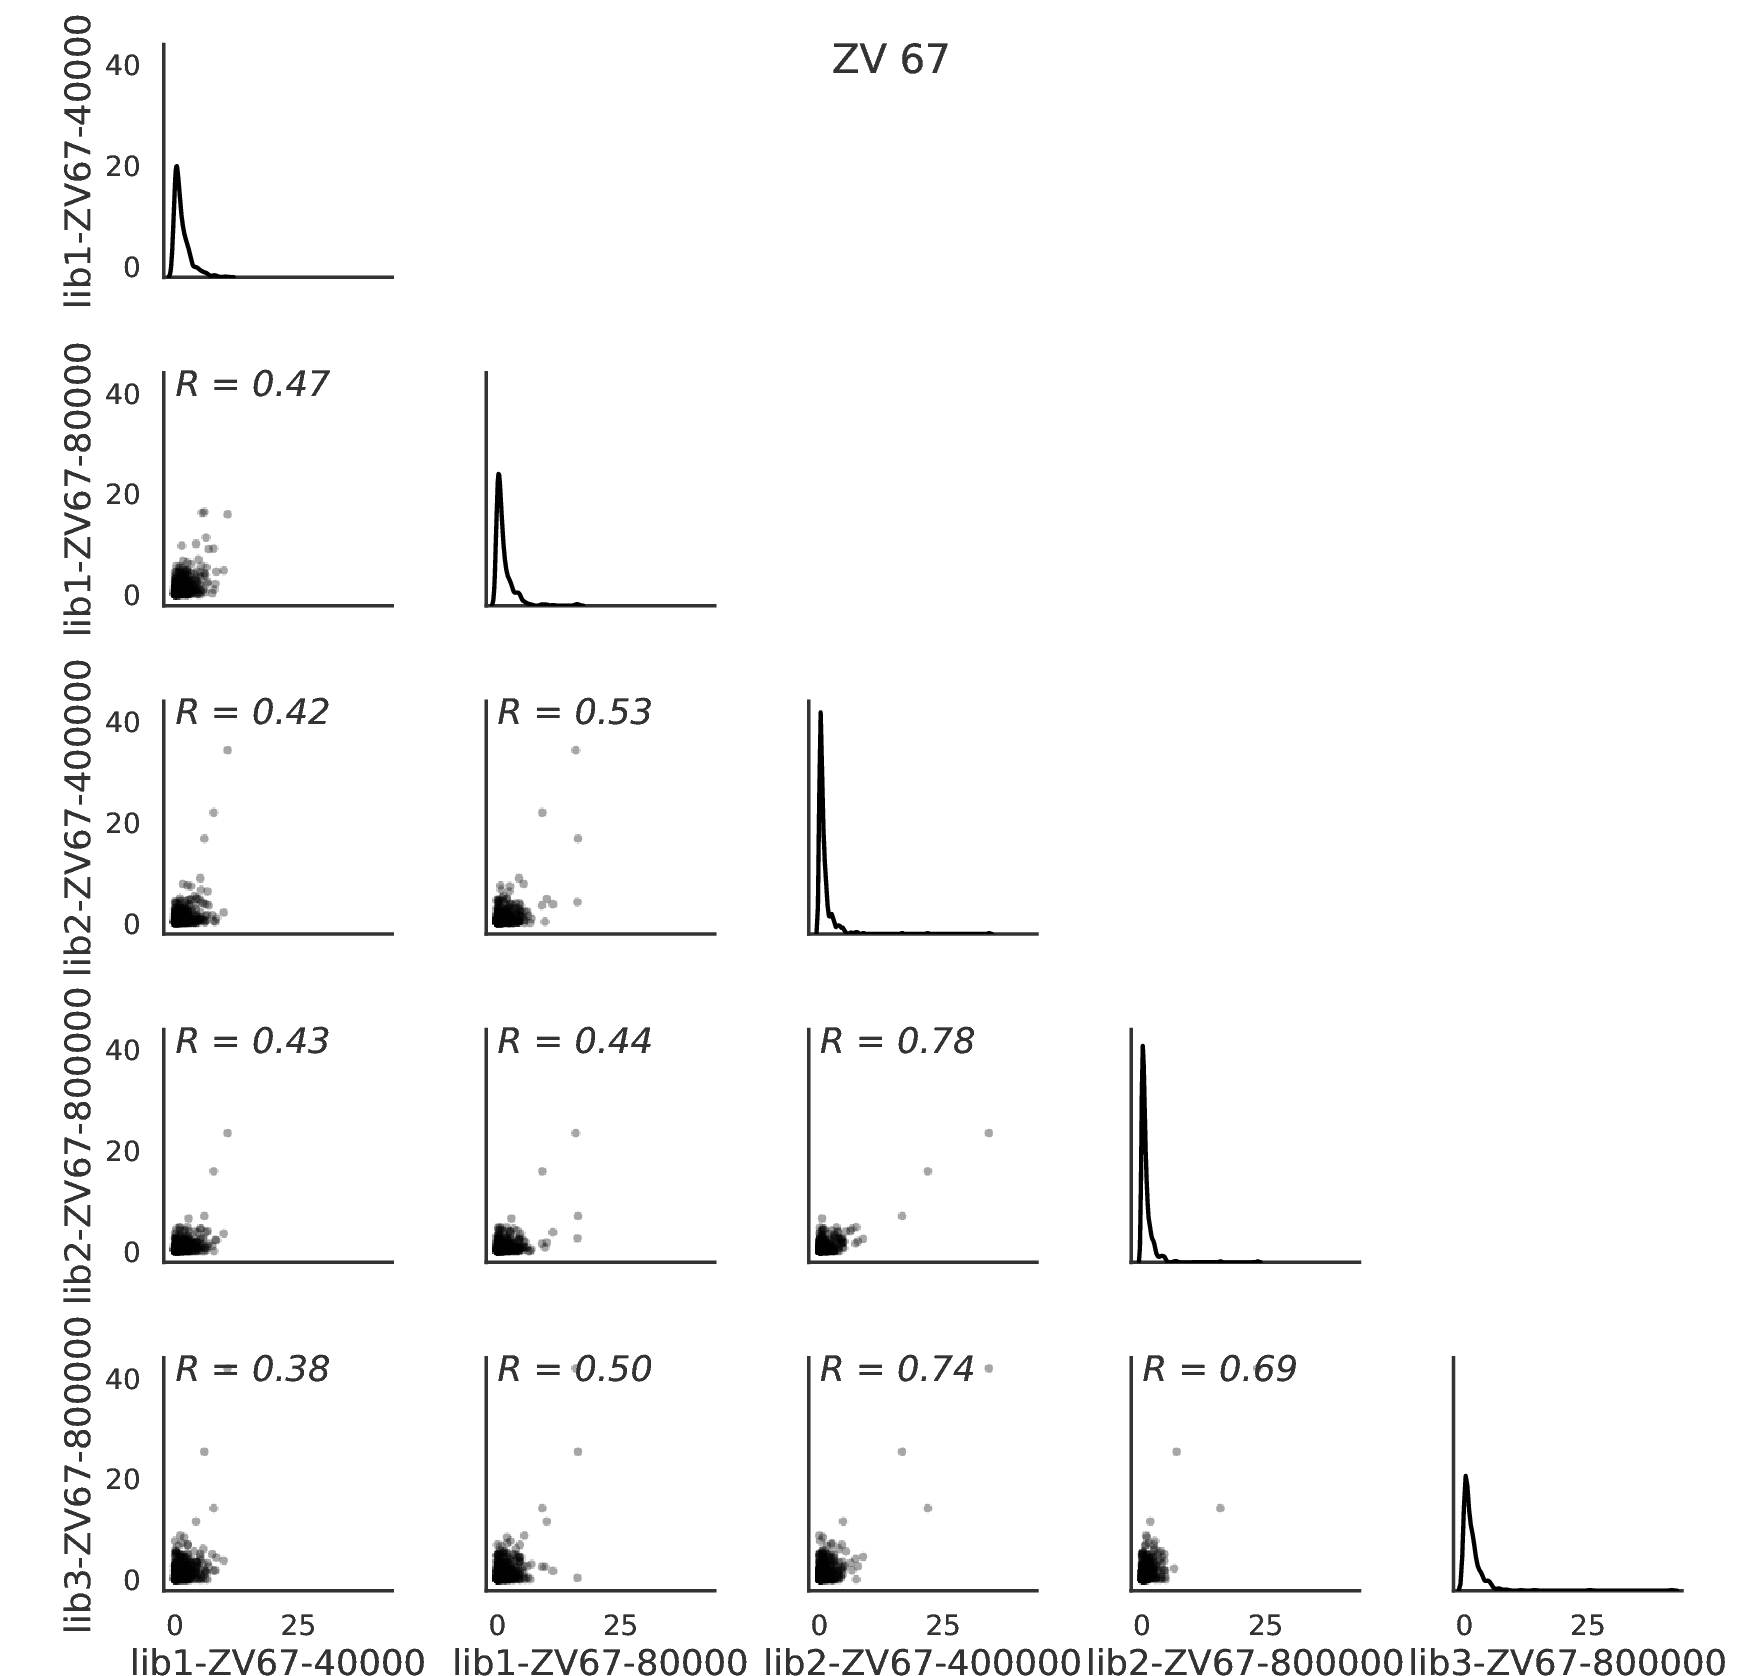

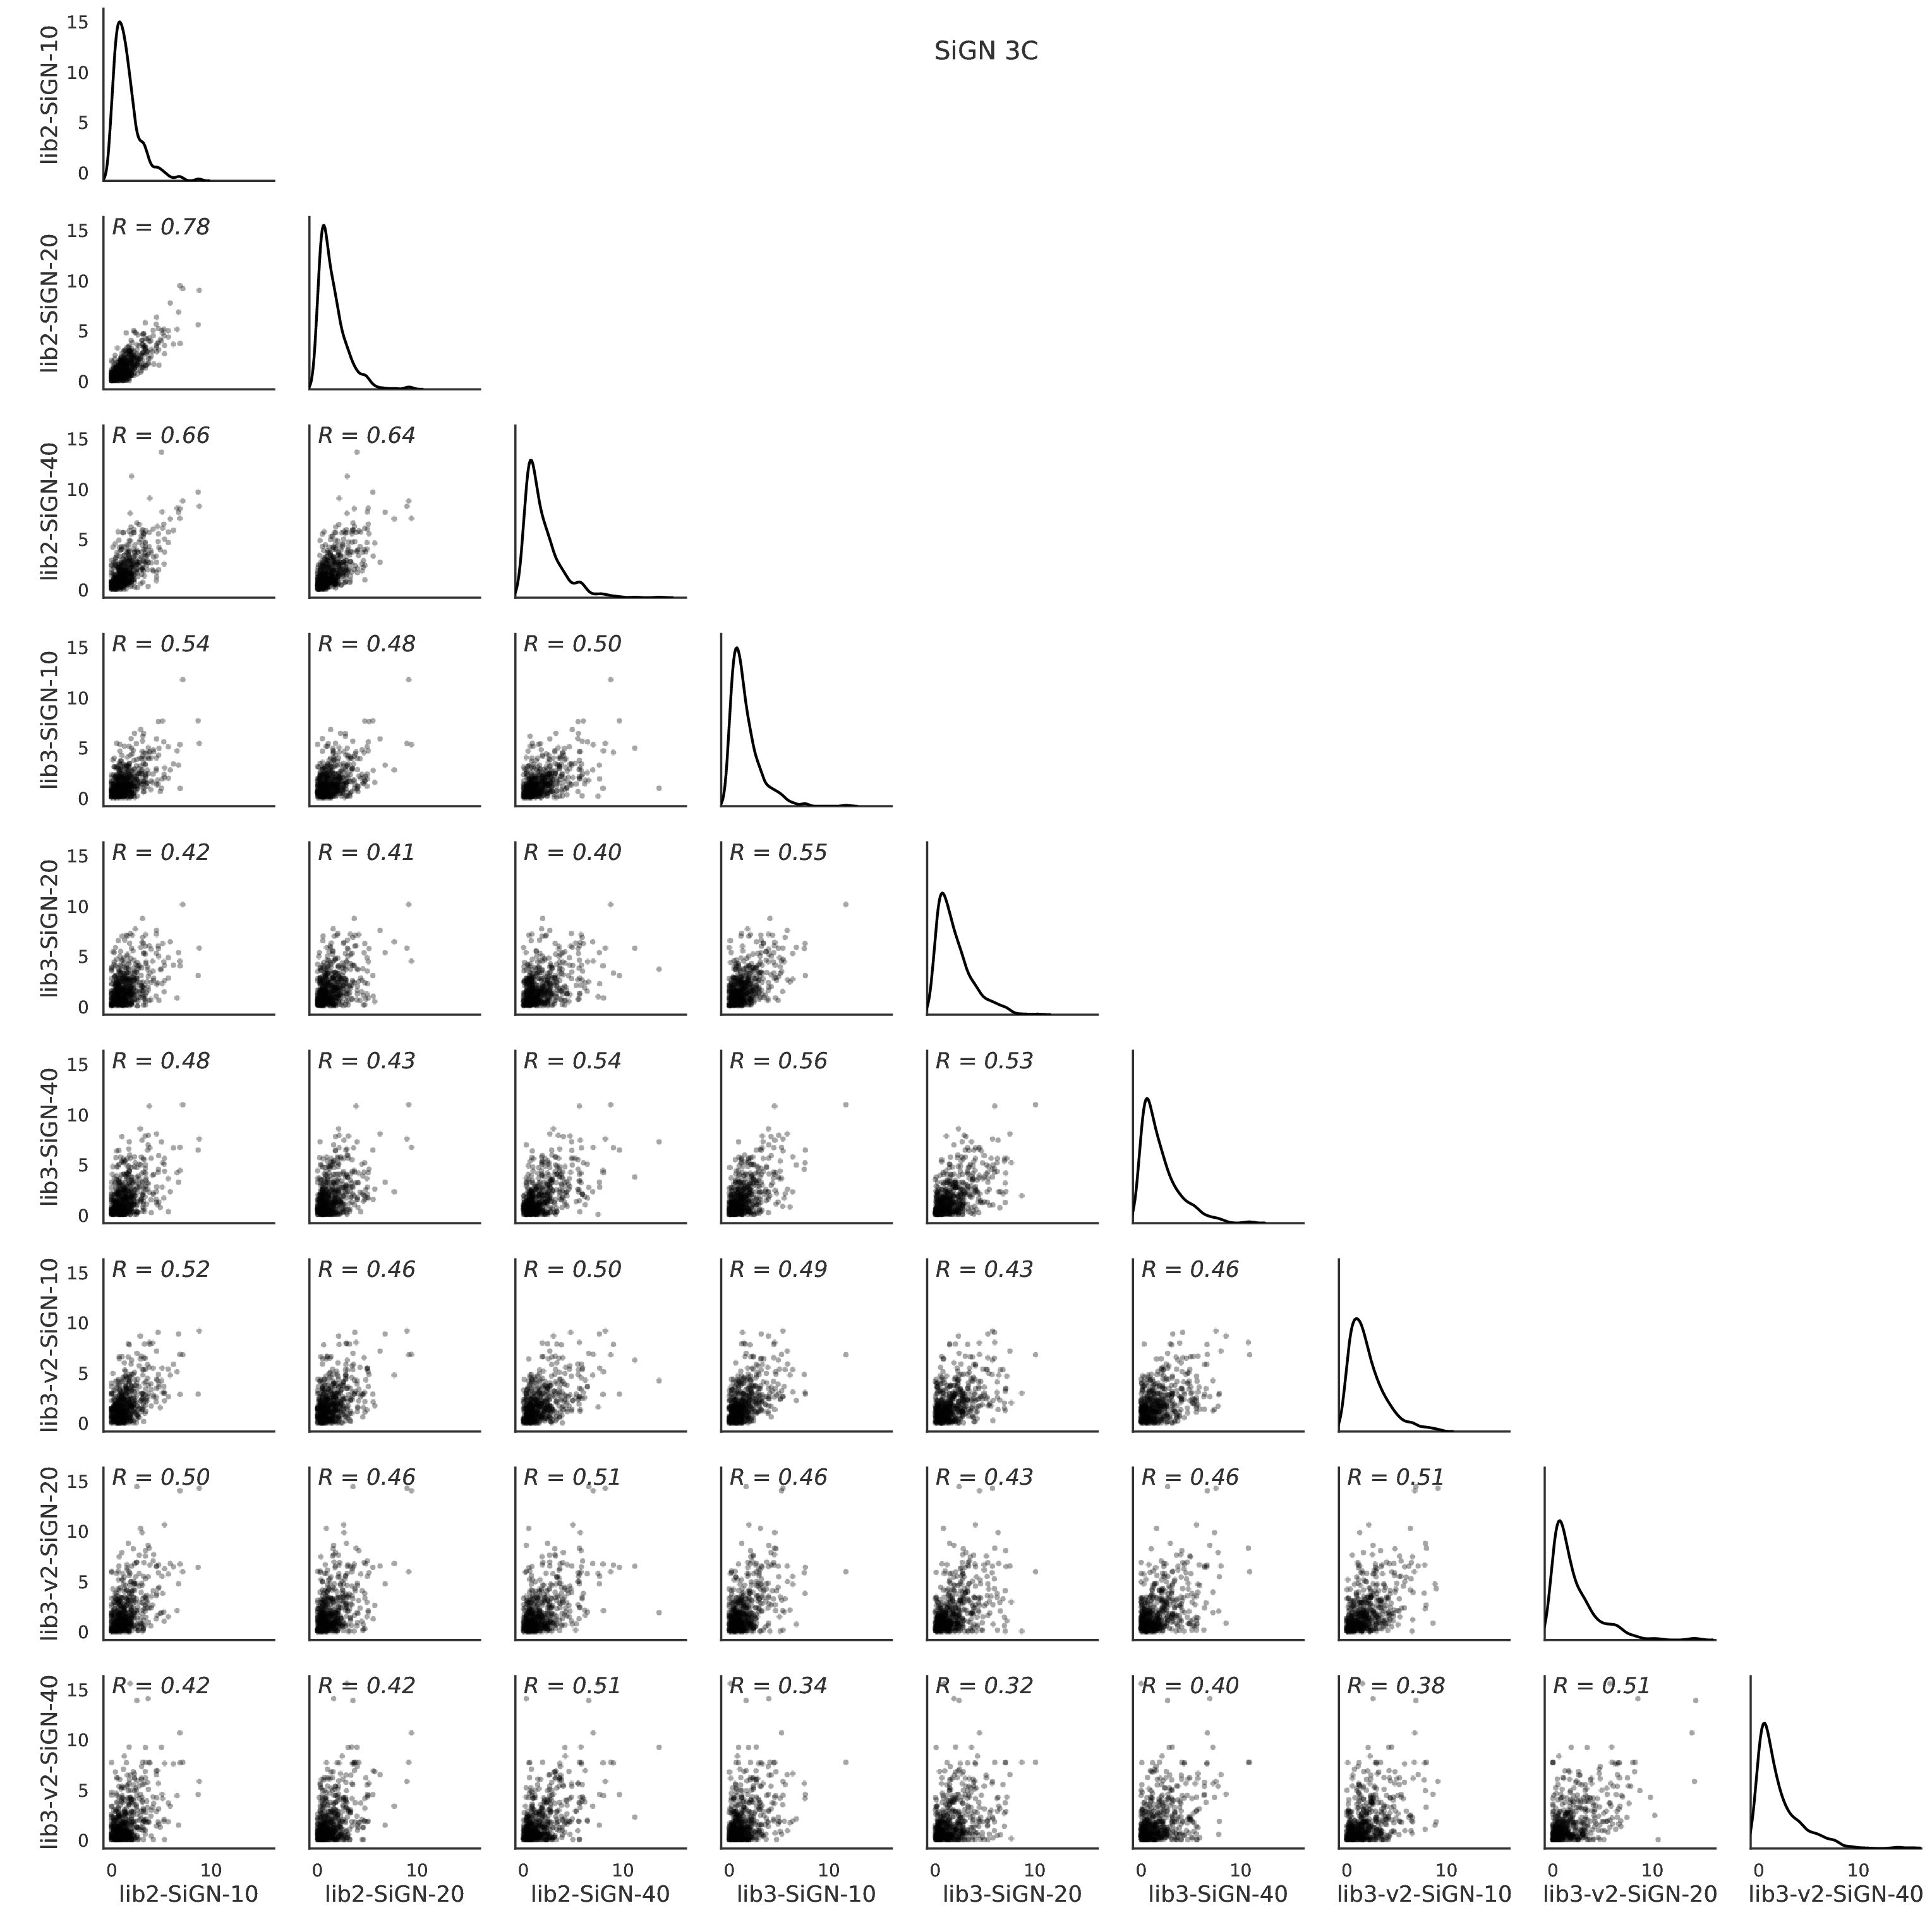

In [17]:
for antibody in diffsel_batch.group.unique():
    showPDF([os.path.join(diffseldir, f'summary_{antibody}-positivesitediffselcorr.pdf')])
    print("\n")        

These plots show that the strongest pseudo-technical replicate selections and biological replicate selections occured in ZKA-64, MZ4 and ZV-67, with R values in the 0.6-0.7 range. EDE1-C10 and EDE1-C8 correlations are somewhat weaker, peaking in the R=0.5-0.6 range.

I will try combining all datasets and display those data as logoplots below. 

## Mean and median differential selection displayed as logoplots
Using [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html), we can create logoplots of the results of the mean differential selection data. 

In [18]:
# make directory for mean diffsel logoplots
mean_logo_dir = os.path.join(resultsdir + 'mean_logoplots/')
os.makedirs(mean_logo_dir, exist_ok = True)

# make directory for median diffsel logoplots
median_logo_dir = os.path.join(resultsdir + 'median_logoplots/')
os.makedirs(median_logo_dir, exist_ok = True)

In [19]:
# for each antibody group in diffsel, run dms2_logoplot to calculate mean differential selection
for ab in diffsel_batch.query('group != "control-antibody"').group.unique():
    diffselfile = os.path.join(diffseldir, f'summary_{ab}-meanmutdiffsel.csv')
    baka = ! dms2_logoplot \
        --outdir {mean_logo_dir} \
        --ncpus 16 \
        --name {ab} \
        --diffsel {diffselfile} \
        --restrictdiffsel positive \
        --nperline 101 \
        --scalebar 10 "diffsel = 10" \
        --underlay yes \
        --use_existing {use_existing}
# Jesse's overlay of WT seq is generated during the funcational selection analysis - at some point I will need to go back and do this

logoplot for EDE1-C10 shown below, saved to ./results/mean_logoplots/EDE1-C10_diffsel.pdf


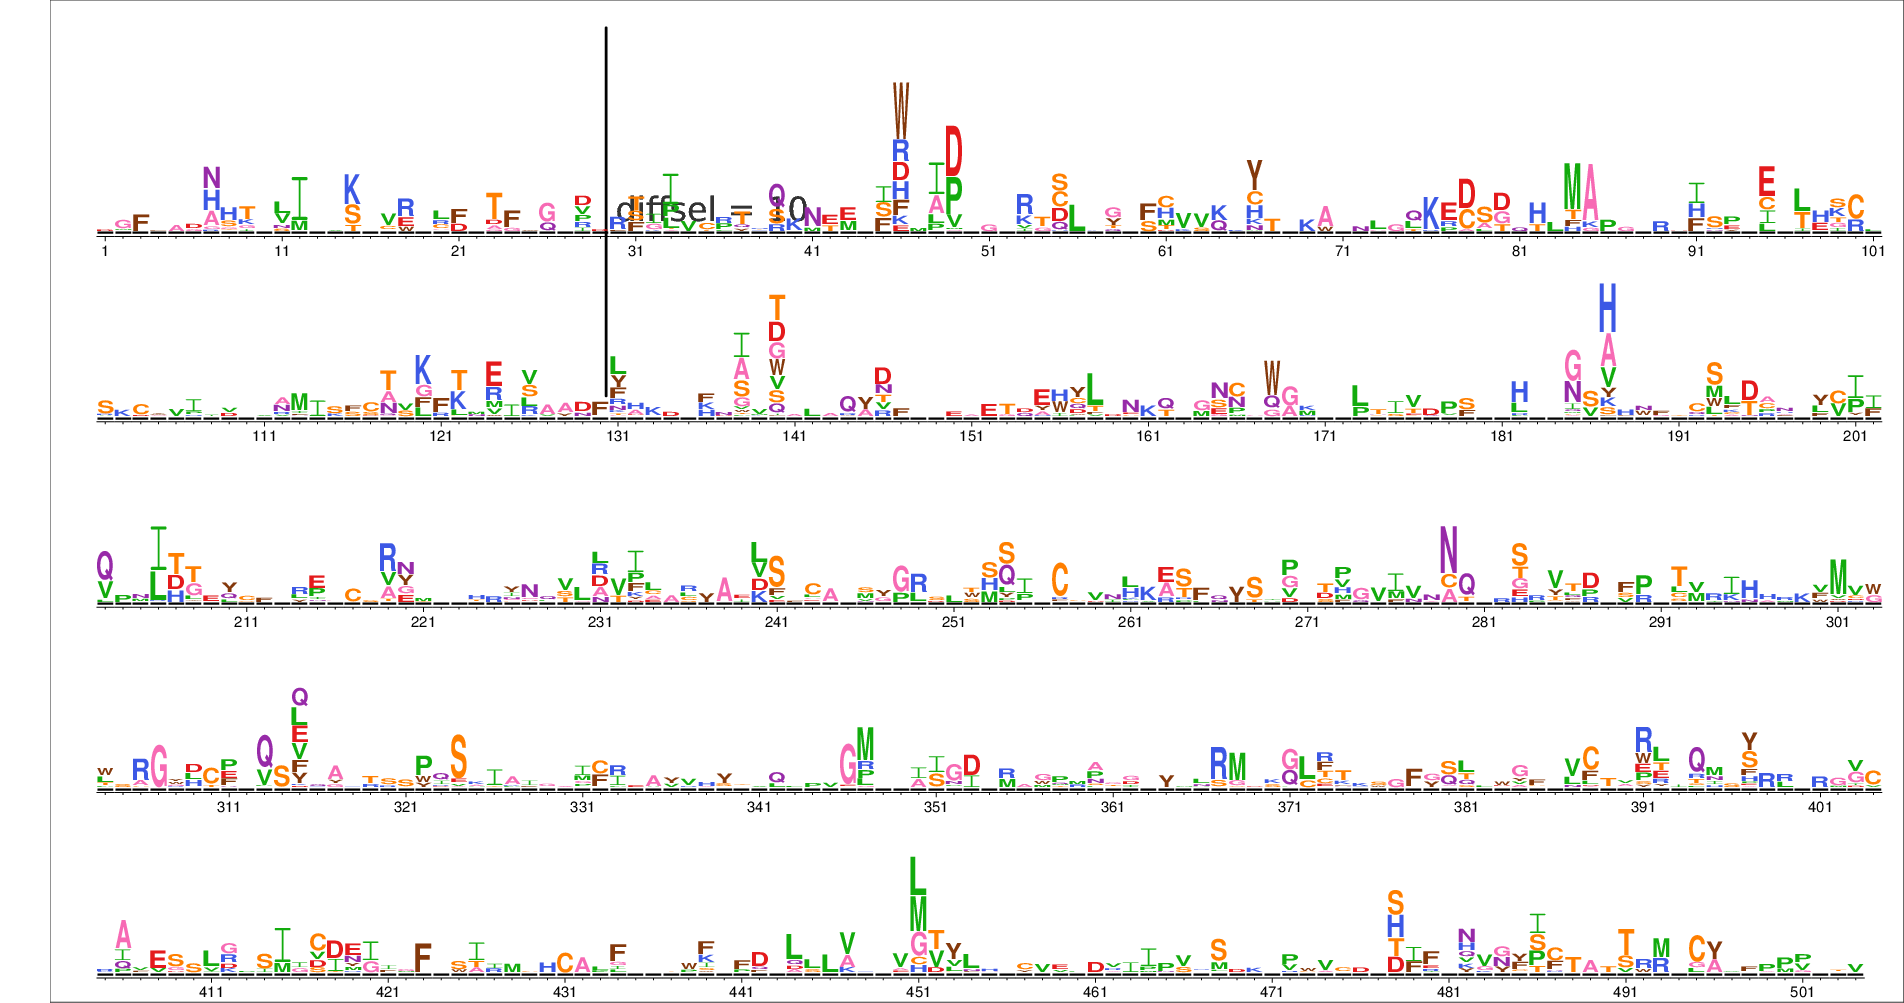

logoplot for EDE1-C8 shown below, saved to ./results/mean_logoplots/EDE1-C8_diffsel.pdf


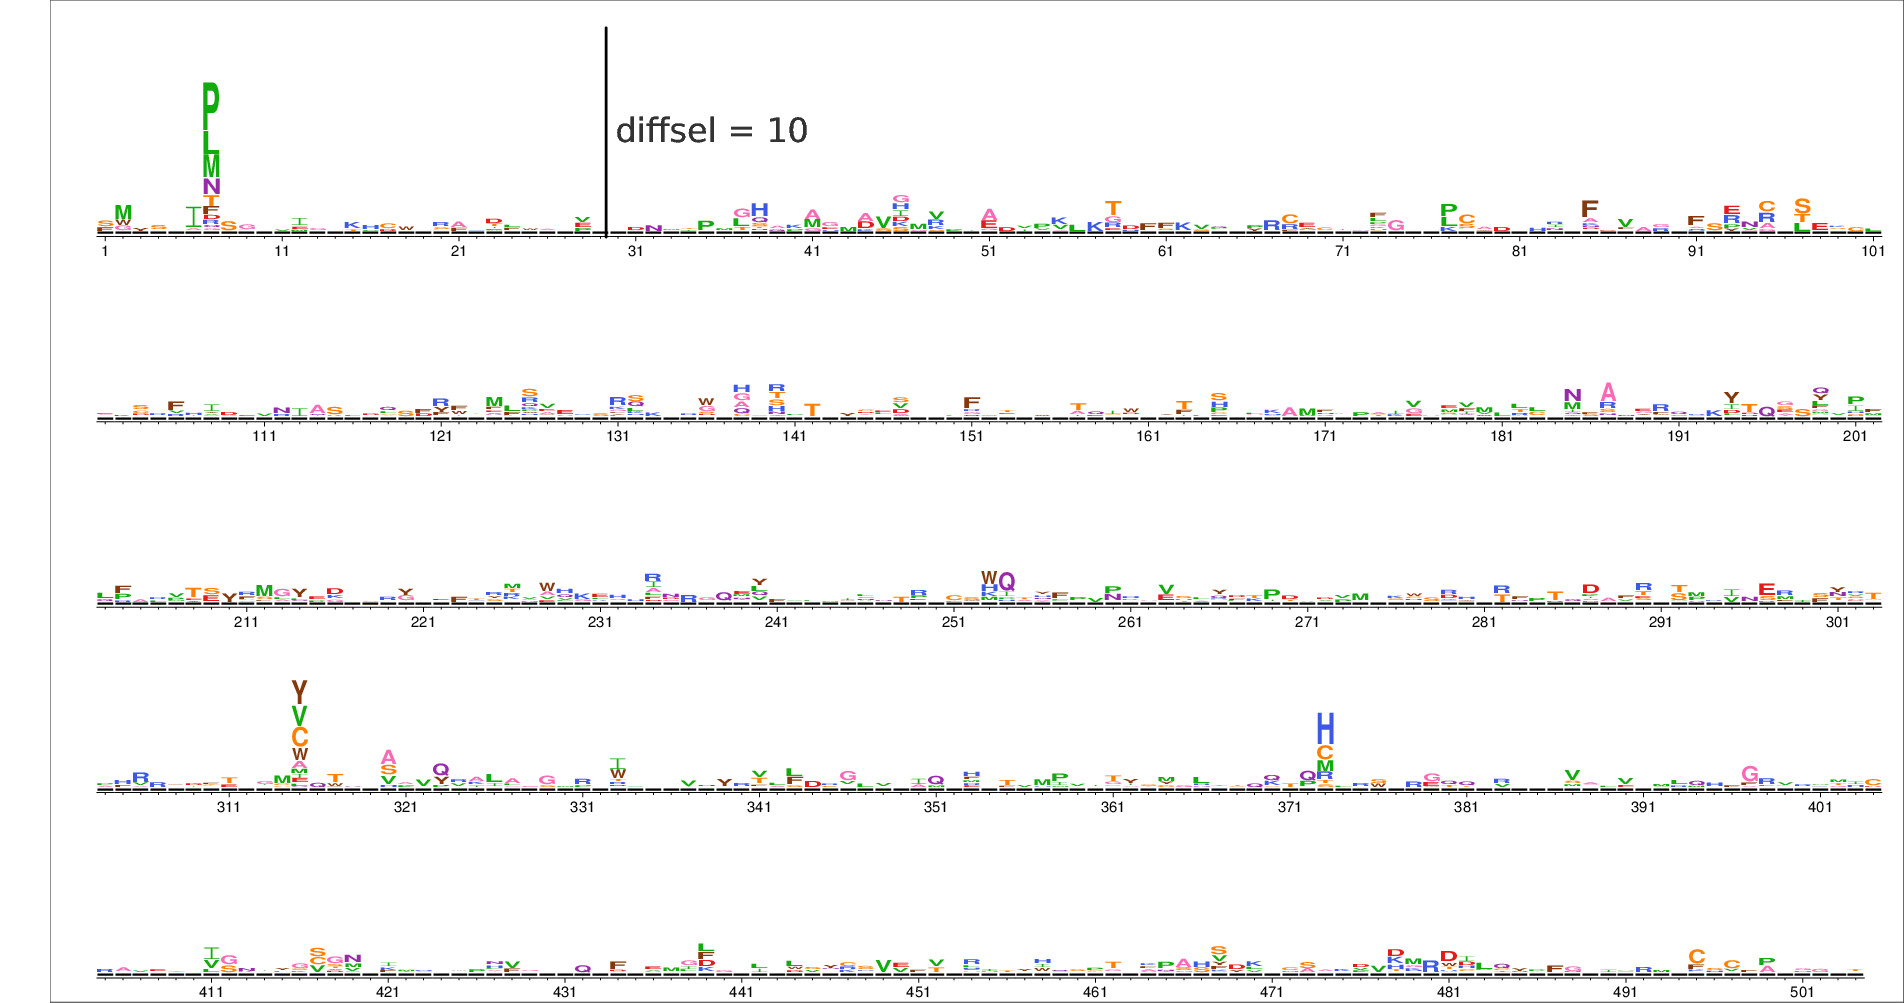

logoplot for MZ4 shown below, saved to ./results/mean_logoplots/MZ4_diffsel.pdf


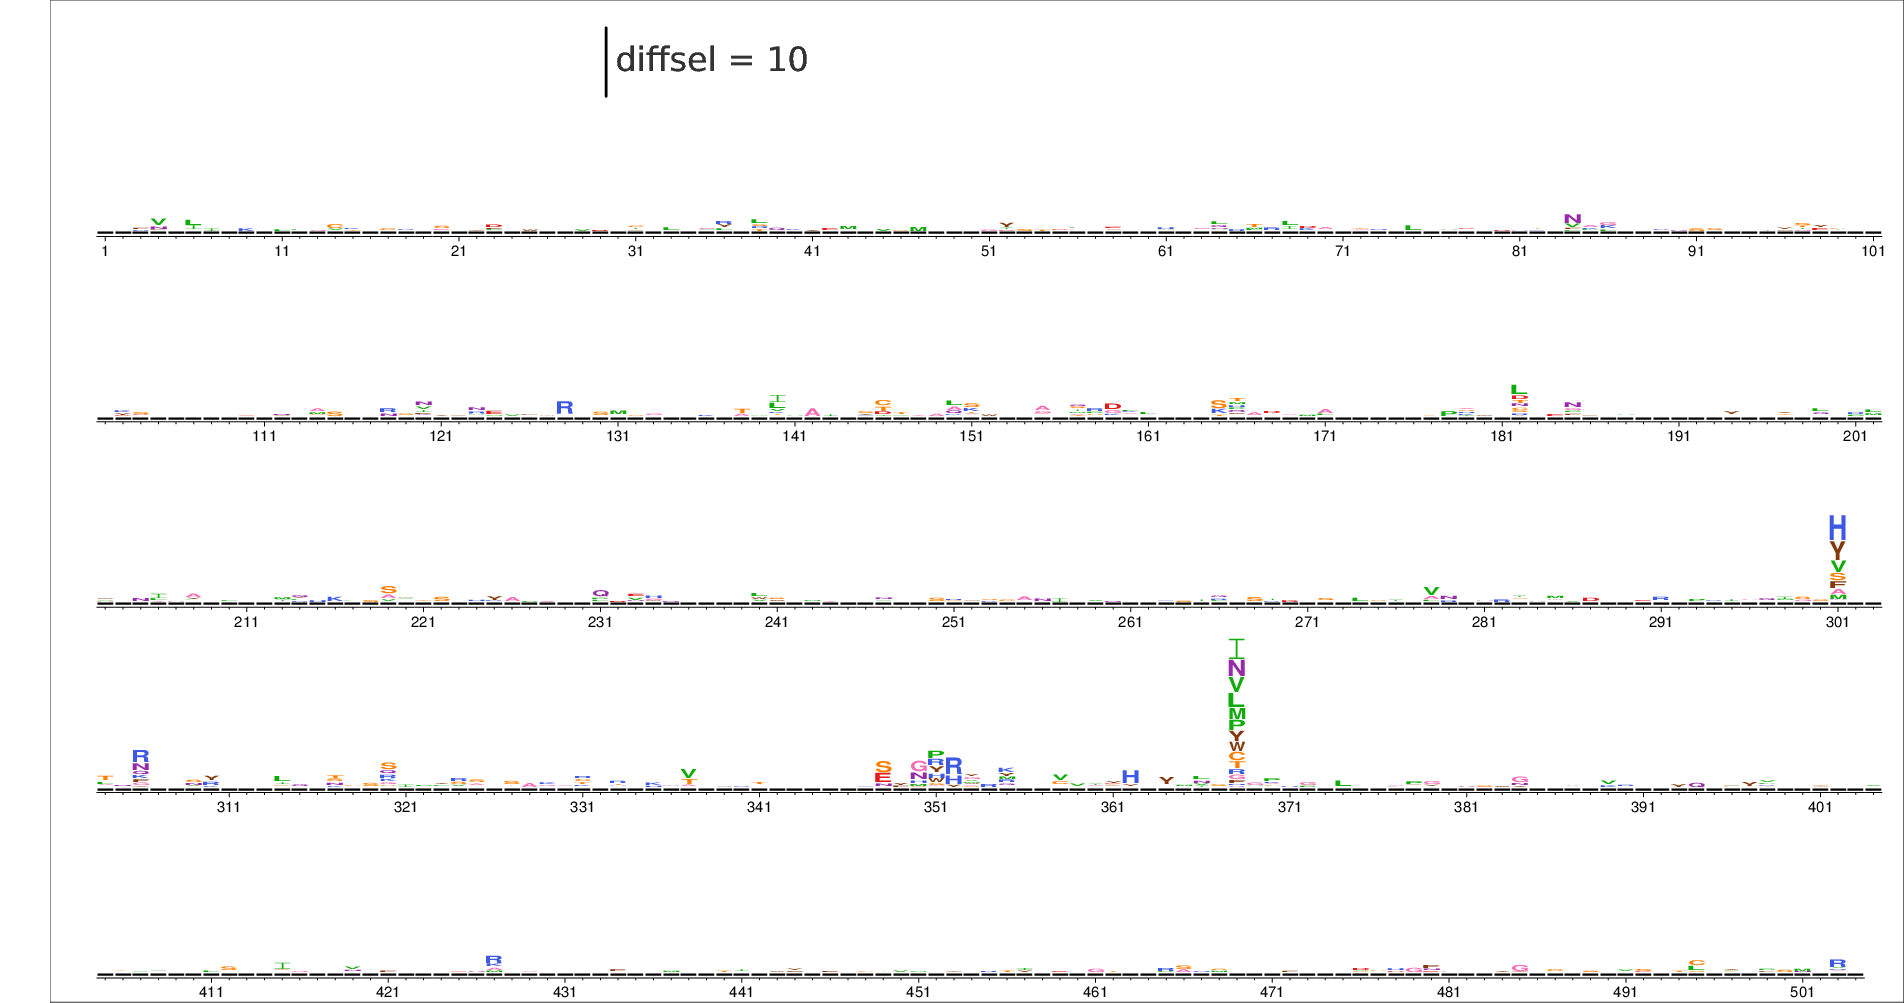

logoplot for ZKA-64 shown below, saved to ./results/mean_logoplots/ZKA-64_diffsel.pdf


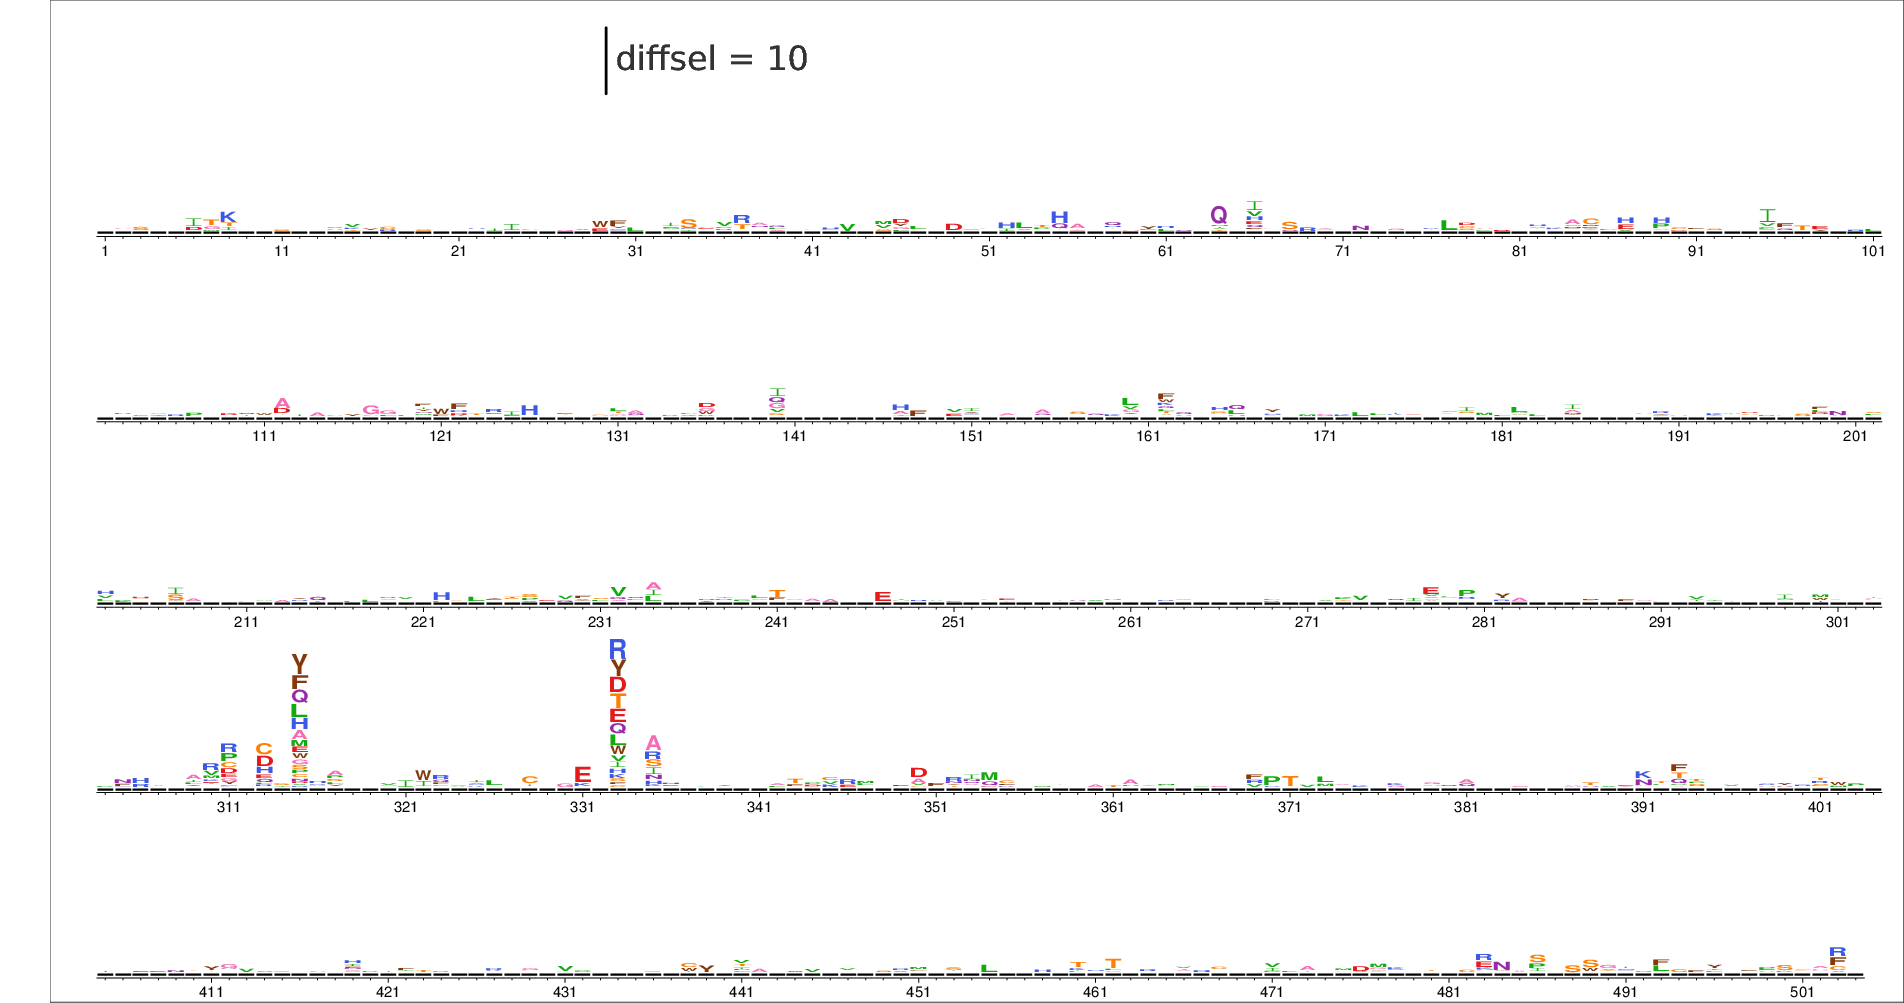

logoplot for ZV-67 shown below, saved to ./results/mean_logoplots/ZV-67_diffsel.pdf


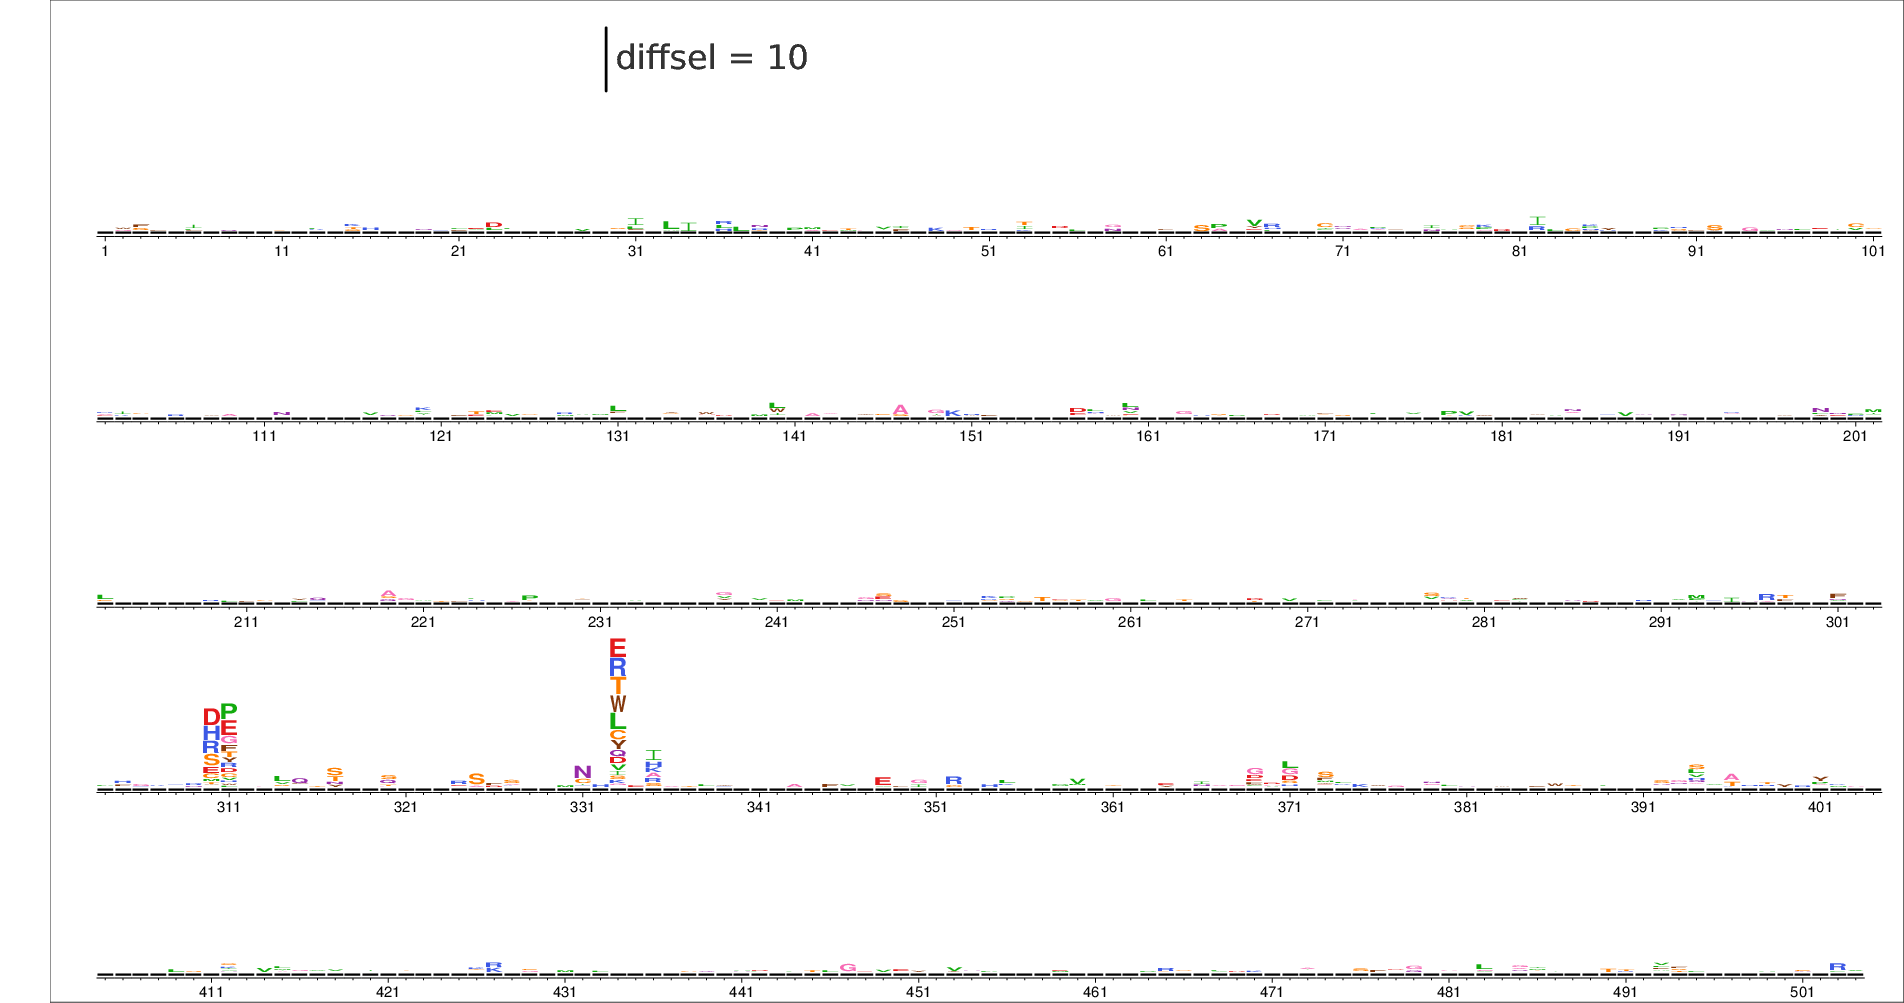

logoplot for SiGN-3C shown below, saved to ./results/mean_logoplots/SiGN-3C_diffsel.pdf


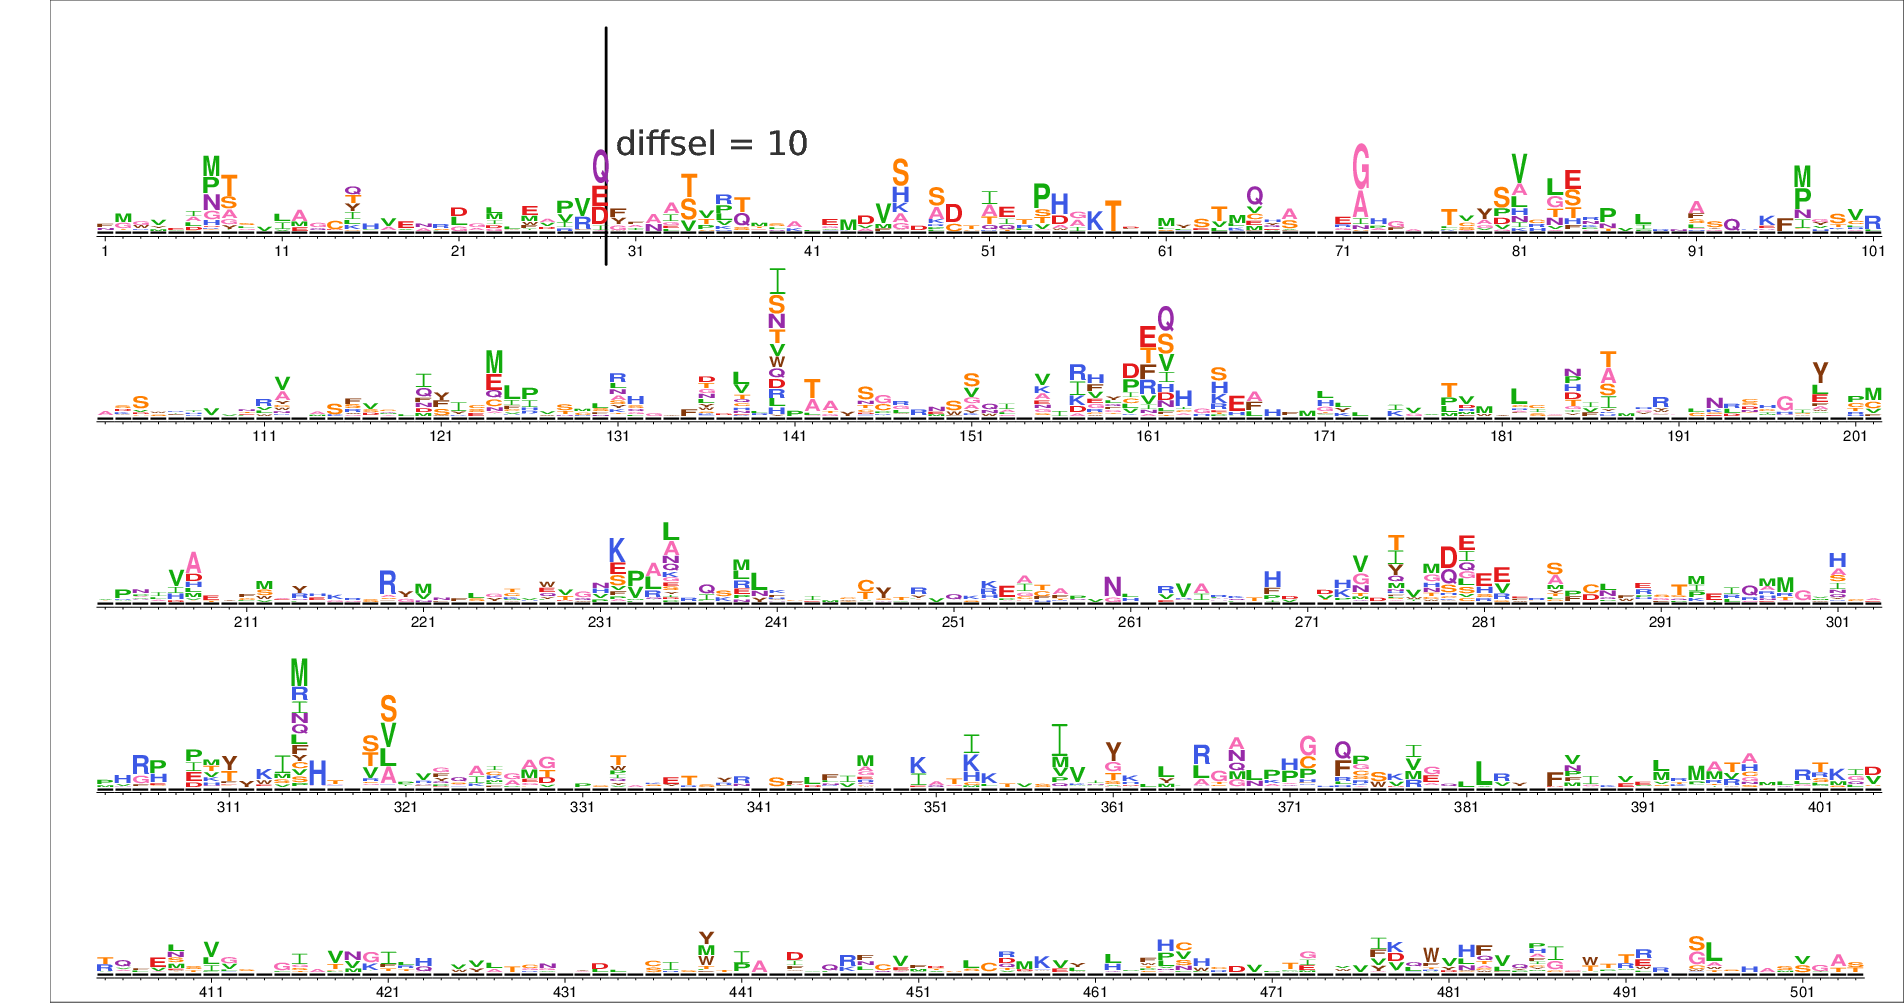

In [20]:
# show logoplot results by antibody 'group'
for sample in diffsel_batch['group'].unique():
    print(f'logoplot for {sample} shown below, saved to ' + os.path.join(mean_logo_dir, sample + '_diffsel.pdf'))
    showPDF(os.path.join(mean_logo_dir, sample + '_diffsel.pdf'))

Shown above are the mean of all concentraions of antibodies used in selections. It may be more informative to see the median, thereby reducing outlier effects from individual biological replicates. This is shown below. 

logoplot for EDE1-C10 shown below, saved to ./results/median_logoplots/EDE1-C10_diffsel.pdf


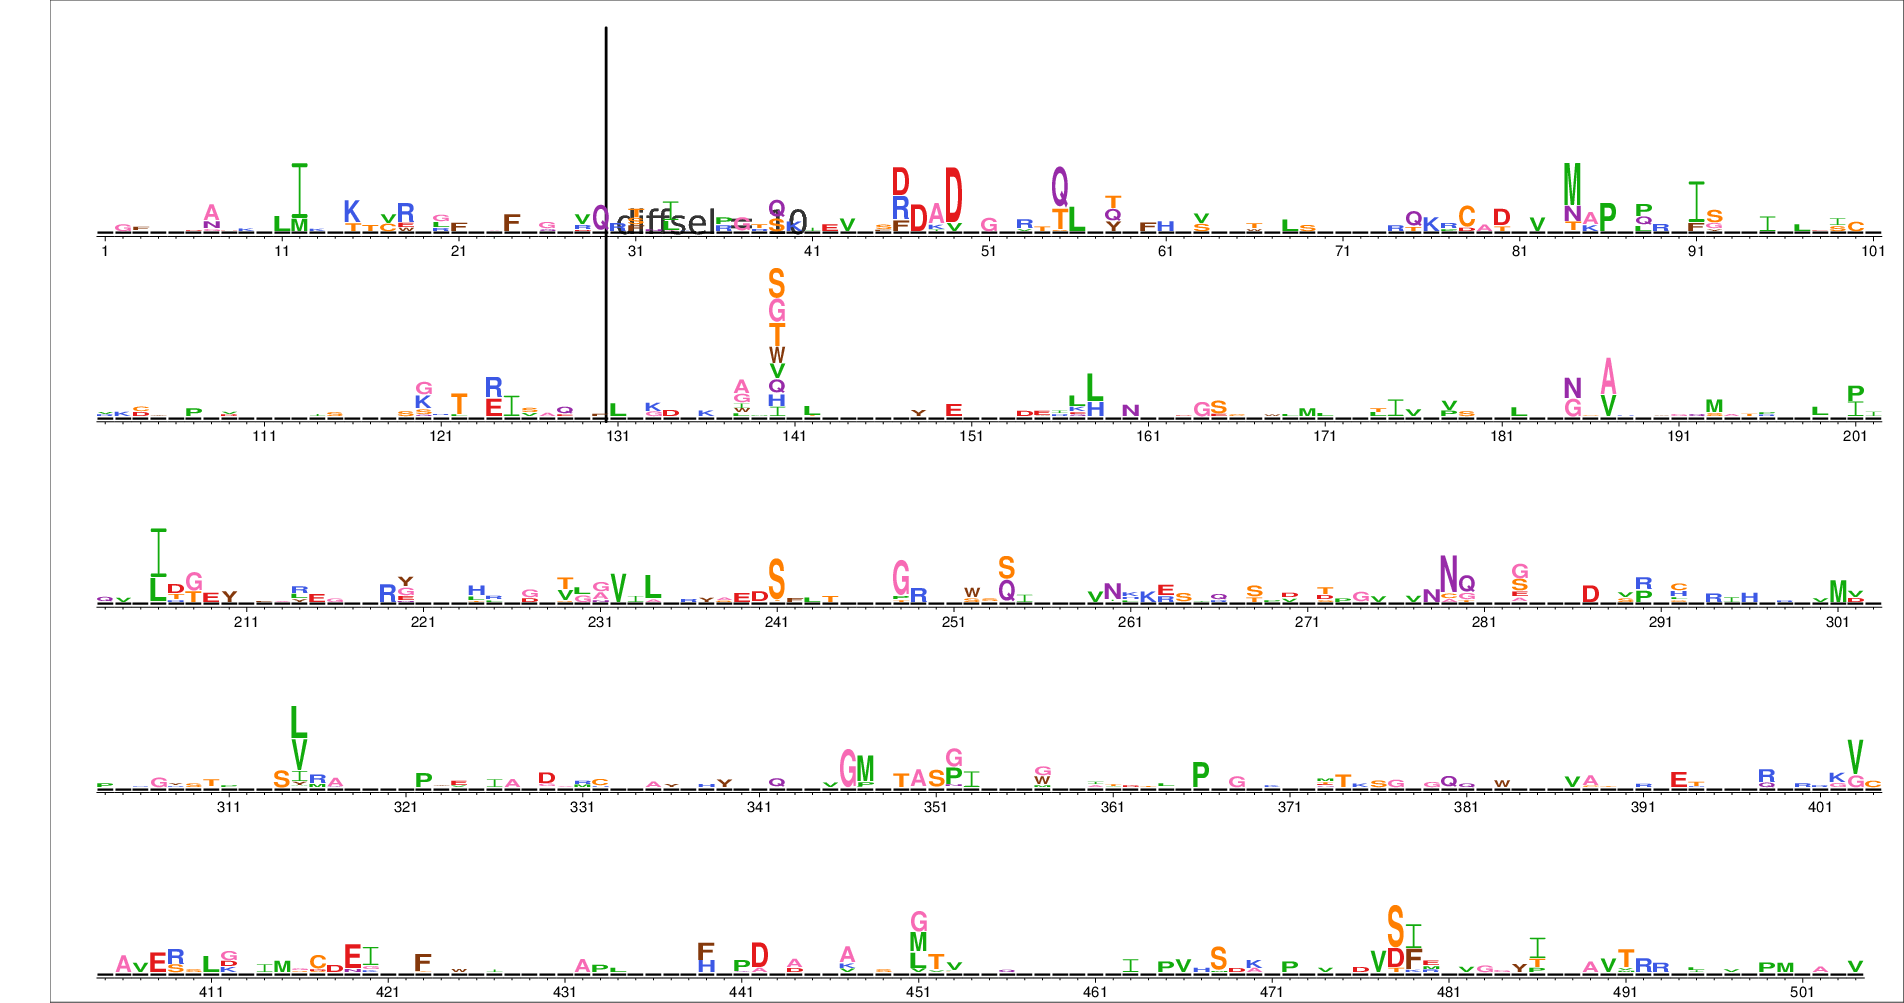

logoplot for EDE1-C8 shown below, saved to ./results/median_logoplots/EDE1-C8_diffsel.pdf


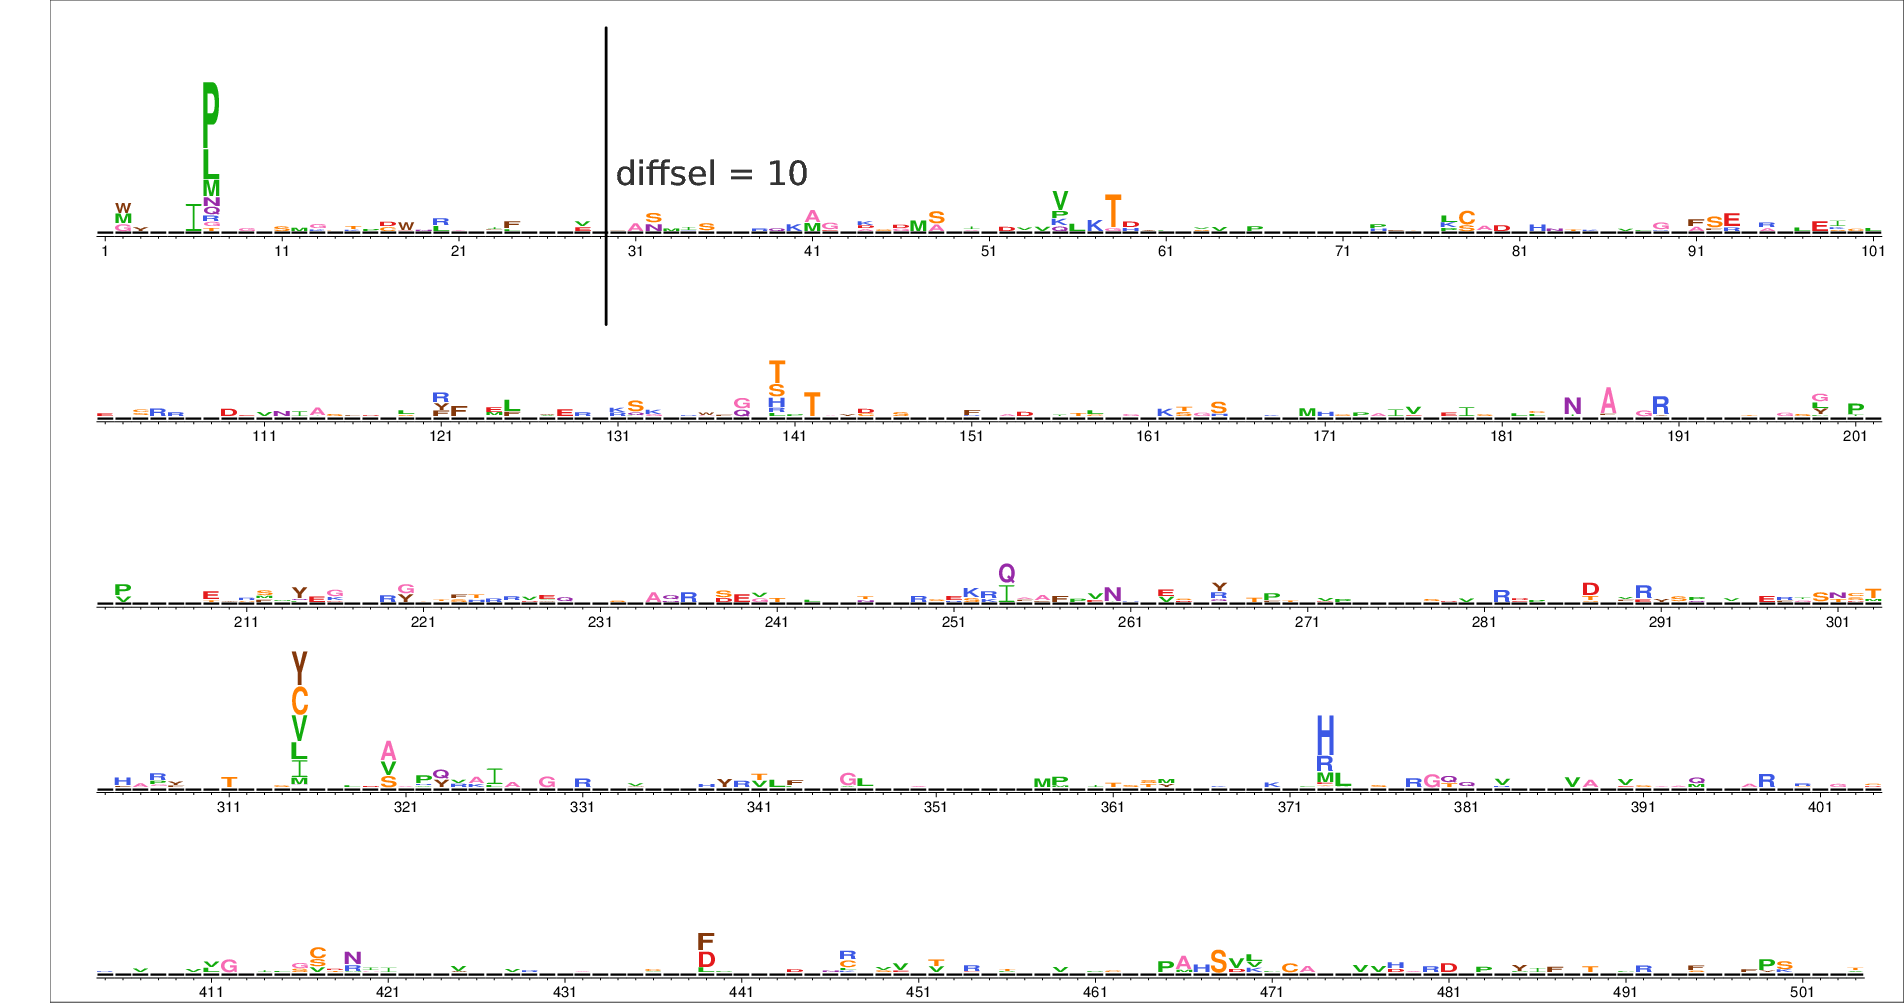

logoplot for MZ4 shown below, saved to ./results/median_logoplots/MZ4_diffsel.pdf


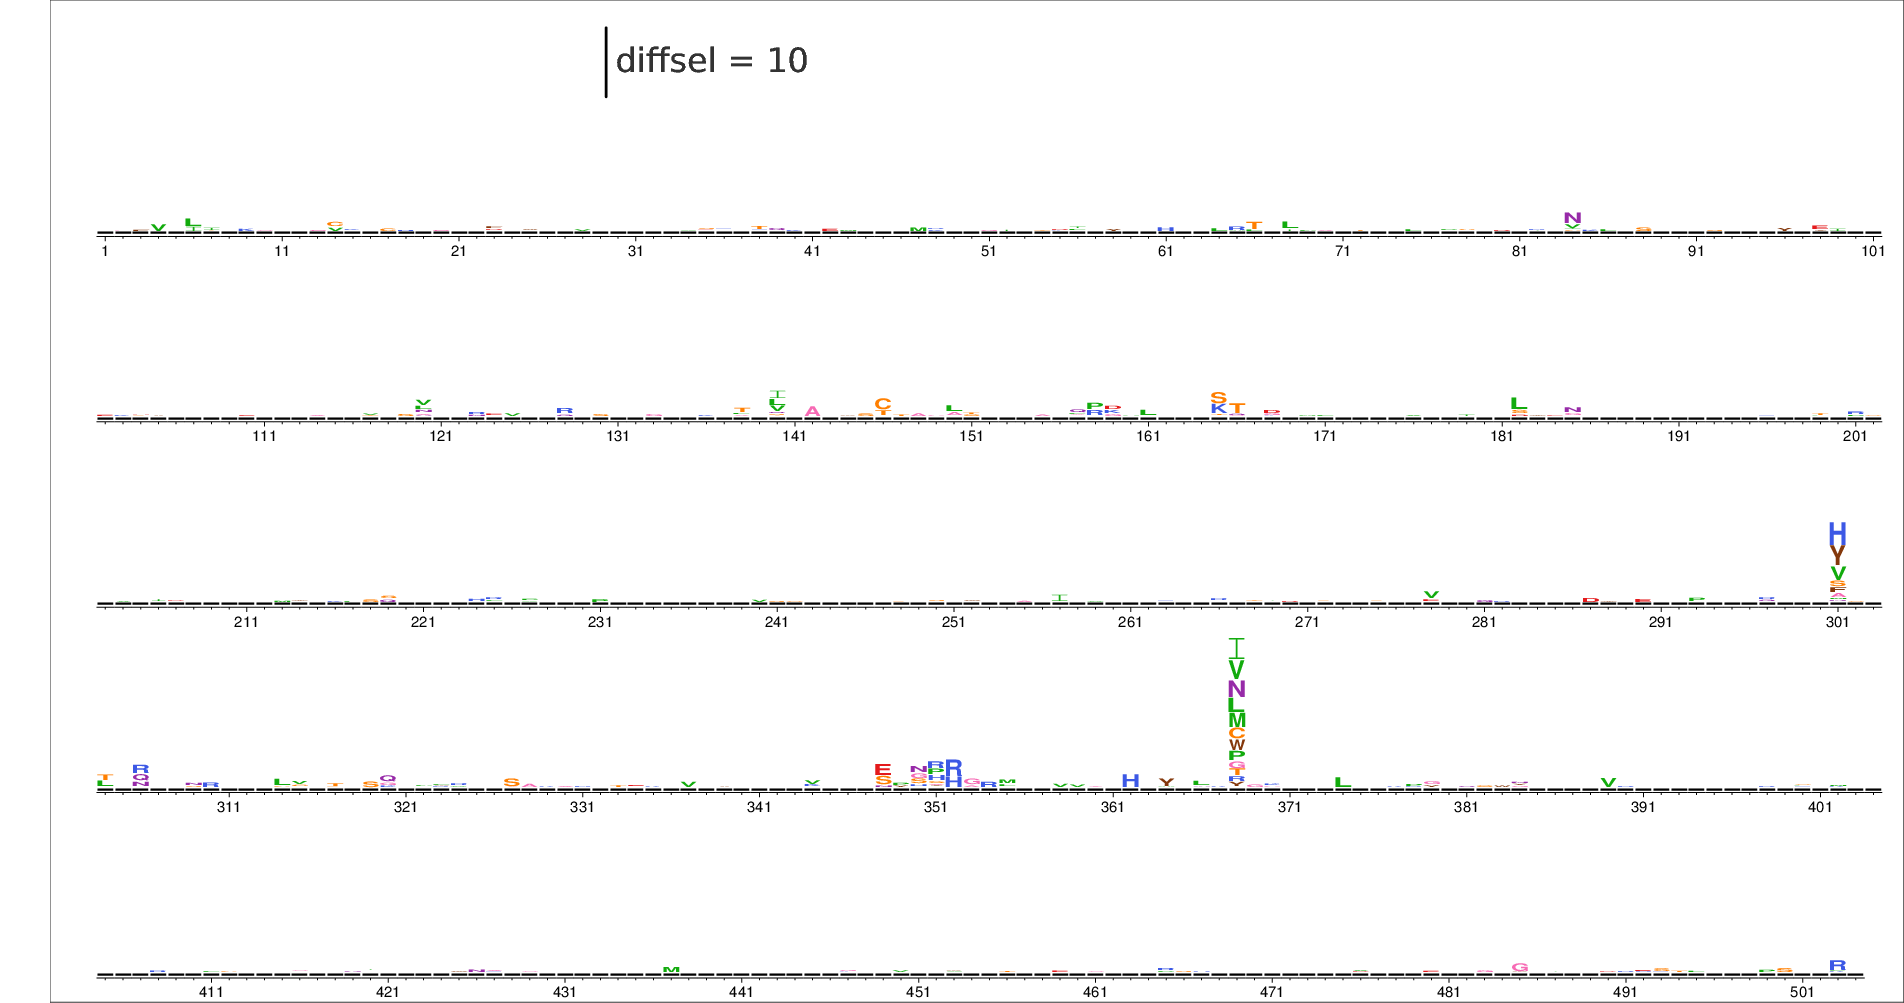

logoplot for ZKA-64 shown below, saved to ./results/median_logoplots/ZKA-64_diffsel.pdf


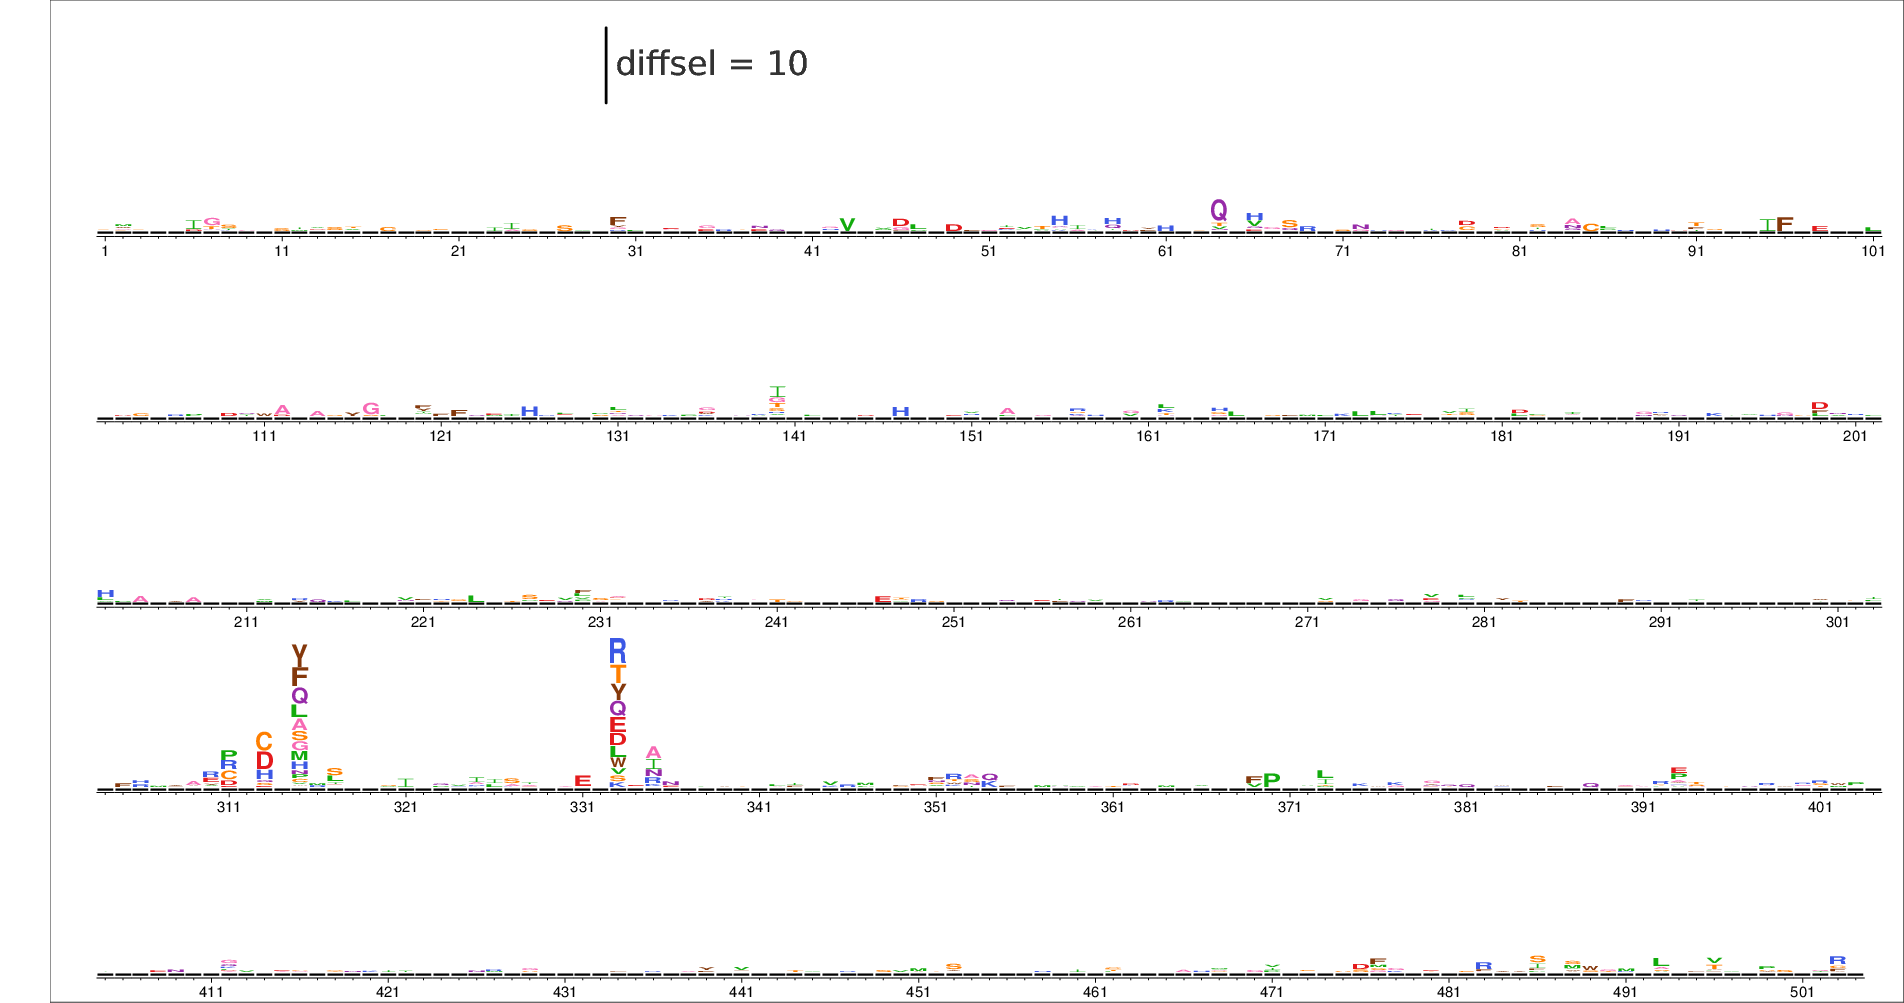

logoplot for ZV-67 shown below, saved to ./results/median_logoplots/ZV-67_diffsel.pdf


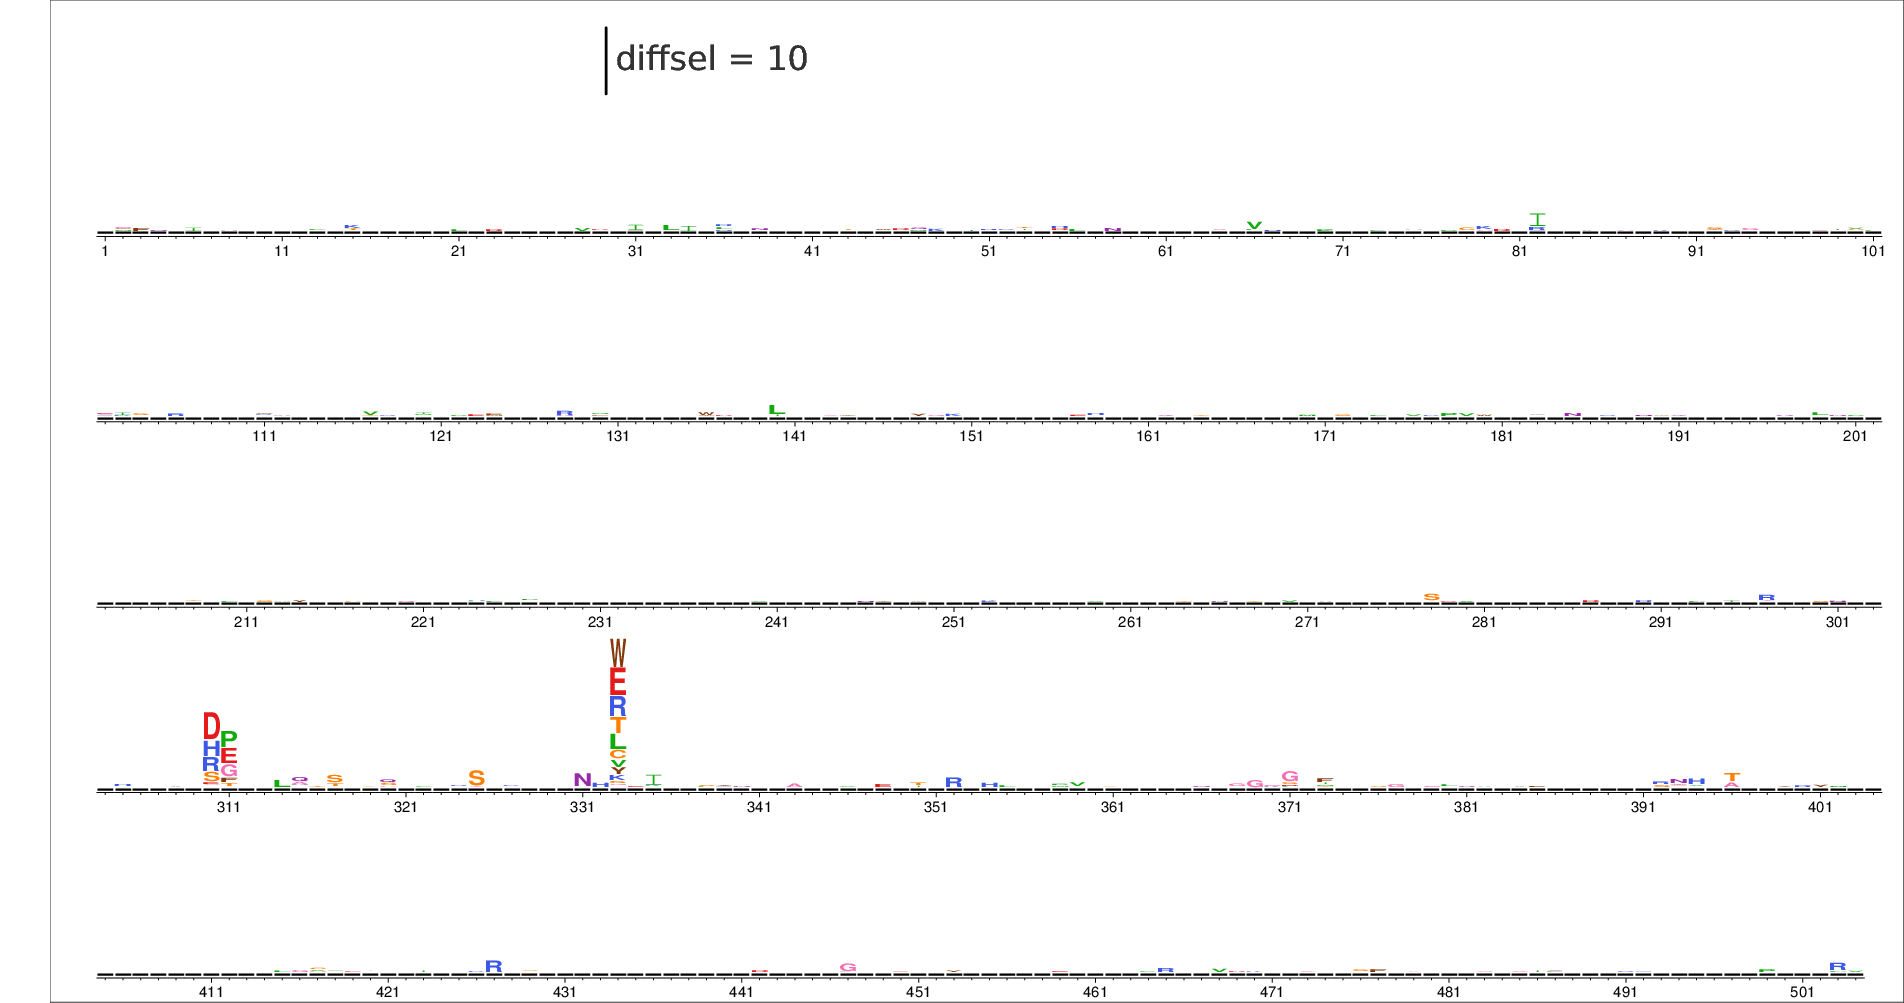

logoplot for SiGN-3C shown below, saved to ./results/median_logoplots/SiGN-3C_diffsel.pdf


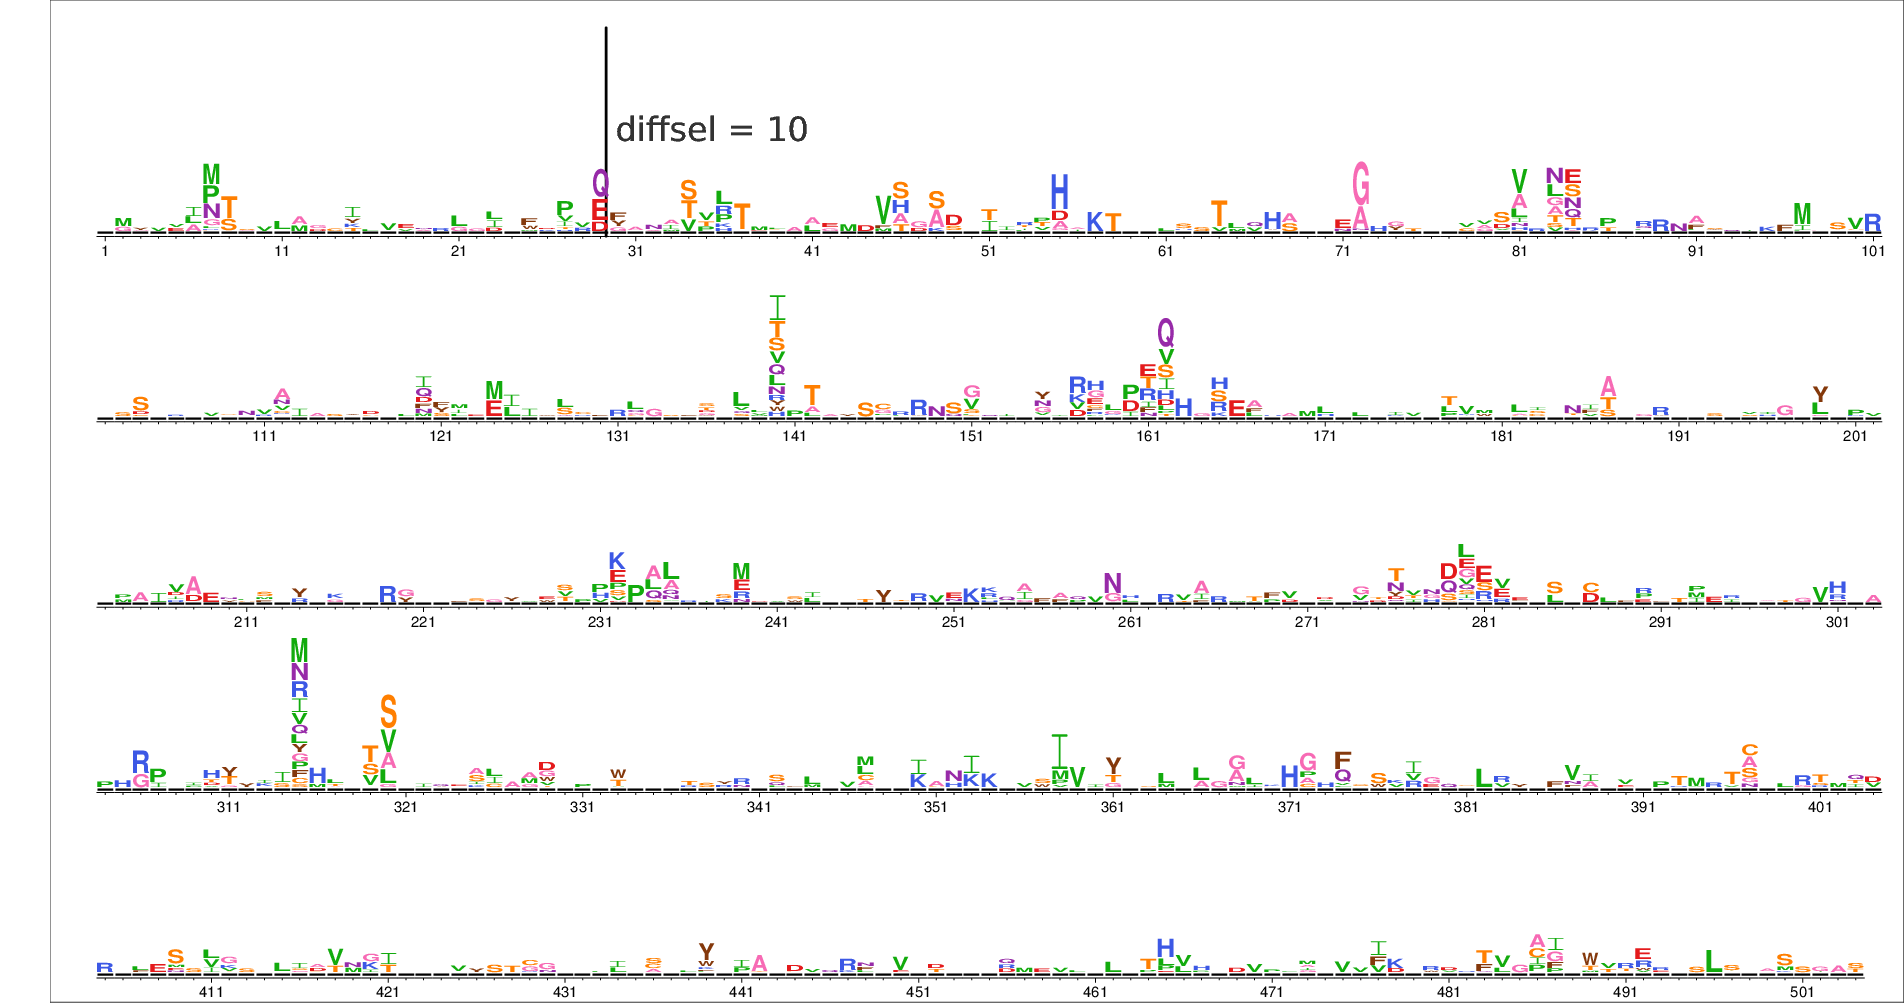

In [21]:
# for each antibody group in diffsel, run dms2_logoplot to calculate mean differential selection
for ab in diffsel_batch.query('group != "control-antibody"').group.unique():
    diffselfile = os.path.join(diffseldir, f'summary_{ab}-medianmutdiffsel.csv')
    baka = ! dms2_logoplot \
        --outdir {median_logo_dir} \
        --ncpus 16 \
        --name {ab} \
        --diffsel {diffselfile} \
        --restrictdiffsel positive \
        --nperline 101 \
        --scalebar 10 "diffsel = 10" \
        --underlay yes \
        --use_existing {use_existing}
# Jesse's overlay of WT seq is generated during the funcational selection analysis - at some point I will need to go back and do this

# show logoplot results by antibody 'group'
for sample in diffsel_batch['group'].unique():
    print(f'logoplot for {sample} shown below, saved to ' + os.path.join(median_logo_dir, sample + '_diffsel.pdf'))
    showPDF(os.path.join(median_logo_dir, sample + '_diffsel.pdf'))

## Calculating diffsel using selected concentrations
We can also cherry-pick single concentrations from each library biological replicate selection based on the strength of their correlation with each other and show mean and median differential selection. 

In [43]:
# pick concentrations
lib1_C10 = diffsel_batch.query('name == "lib1-C10-300"')
lib2_C10 = diffsel_batch.query('name == "lib2-C10-300"')
lib3_C10 = diffsel_batch.query('name == "lib3-C10-150"')

lib1_C8 = diffsel_batch.query('name == "lib1-C8-800"')
lib2_C8 = diffsel_batch.query('name == "lib2-C8-450"')
lib3_C8 = diffsel_batch.query('name == "lib3-C8-450"')

lib1_MZ4 = diffsel_batch.query('name == "lib1-MZ4-4800"')
lib2_MZ4 = diffsel_batch.query('name == "lib2-MZ4-4800"')
lib3_MZ4 = diffsel_batch.query('name == "lib3-MZ4-2400"')

lib1_ZKA64 = diffsel_batch.query('name == "lib1-ZKA64-750"')
lib2_ZKA64 = diffsel_batch.query('name == "lib2-ZKA64-750"')
lib3_ZKA64 = diffsel_batch.query('name == "lib3-ZKA64-750"')

lib1_ZV67 = diffsel_batch.query('name == "lib1-ZV67-80000"')
lib2_ZV67 = diffsel_batch.query('name == "lib2-ZV67-400000"')
lib3_ZV67 = diffsel_batch.query('name == "lib3-ZV67-800000"')

lib1_SiGN = diffsel_batch.query('name == "lib2-SiGN-40"')
lib2_SiGN = diffsel_batch.query('name == "lib3-SiGN-40"')
# lib3_SiGN = diffsel_batch.query('name == "lib3-v2-SiGN-40"')

In [44]:
# make list of selected dataframes and merge to single dataframe
selected_dataframes = [lib1_C10, lib2_C10, lib3_C10,
                       lib1_C8, lib2_C8, lib3_C8,
                       lib1_MZ4, lib2_MZ4, lib3_MZ4,
                       lib1_ZKA64, lib2_ZKA64, lib3_ZKA64,
                       lib1_ZV67, lib2_ZV67, lib3_ZV67,
                       lib1_SiGN, lib2_SiGN, lib3_SiGN]

selected_diffsel_batch = reduce(lambda  left,right: 
                                pd.merge(left,right,how='outer'), 
                                selected_dataframes)

selected_diffsel_batch

library     group              name               sel  \
0      lib1  EDE1-C10      lib1-C10-300      lib1-C10-300   
1      lib2  EDE1-C10      lib2-C10-300      lib2-C10-300   
2      lib3  EDE1-C10      lib3-C10-150      lib3-C10-150   
3      lib1   EDE1-C8       lib1-C8-800       lib1-C8-800   
4      lib2   EDE1-C8       lib2-C8-450       lib2-C8-450   
5      lib3   EDE1-C8       lib3-C8-450       lib3-C8-450   
6      lib1       MZ4     lib1-MZ4-4800     lib1-MZ4-4800   
7      lib2       MZ4     lib2-MZ4-4800     lib2-MZ4-4800   
8      lib3       MZ4     lib3-MZ4-2400     lib3-MZ4-2400   
9      lib1    ZKA-64    lib1-ZKA64-750    lib1-ZKA64-750   
10     lib2    ZKA-64    lib2-ZKA64-750    lib2-ZKA64-750   
11     lib3    ZKA-64    lib3-ZKA64-750    lib3-ZKA64-750   
12     lib1     ZV-67   lib1-ZV67-80000   lib1-ZV67-80000   
13     lib2     ZV-67  lib2-ZV67-400000  lib2-ZV67-400000   
14     lib3     ZV-67  lib3-ZV67-800000  lib3-ZV67-800000   
15     lib2   SiGN-3C      lib2-SiGN-40      lib2-SiGN-40   
16     lib3   SiGN-3C      lib3-SiGN-40      lib3-SiGN-40   
17  lib3-v2   SiGN-3C   lib3-v2-SiGN-40   lib3-v2-SiGN-40   

                   mock percent_infectivity  
0      lib1-no-antibody               0.11%  
1      lib2-no-antibody               0.01%  
2      lib3-no-antibody               1.65%  
3      lib1-no-antibody               0.57%  
4      lib2-no-antibody               1.06%  
5      lib3-no-antibody               0.47%  
6      lib1-no-antibody               0.46%  
7      lib2-no-antibody               0.02%  
8      lib3-no-antibody               0.16%  
9      lib1-no-antibody               0.57%  
10     lib2-no-antibody               3.51%  
11     lib3-no-antibody               5.41%  
12     lib1-no-antibody               0.26%  
13     lib2-no-antibody               0.89%  
14     lib3-no-antibody               0.06%  
15     lib2-no-antibody               0.95%  
16     lib3-no-antibody               0.19%  
17  lib3-v2-no-antibody               1.65%

In [45]:
# make new selected_diffseldir 
selected_diffseldir = os.path.join(resultsdir + 'selected_diffsel/')
os.makedirs(selected_diffseldir, exist_ok=True)

# write individual concentration diffsel batchfile to csv
selected_diffsel_batchfile = os.path.join(selected_diffseldir + 'batch.csv')
selected_diffsel_batch.to_csv(selected_diffsel_batchfile, index = False)

# run dms2_batch_diffsel for individual concentration batchfile
baka = ! dms2_batch_diffsel \
        --batchfile {selected_diffsel_batchfile} \
        --summaryprefix summary \
        --indir {codons_batch_subamp} \
        --outdir {selected_diffseldir} \
        --ncpus 16 \
        --use_existing {use_existing}

In [46]:
# make directories for mean and median selected diffsel
mean_sel_logodir = os.path.join(resultsdir + 'mean_selected_logoplots/')
os.makedirs(mean_sel_logodir, exist_ok = True)

# make directory for median diffsel logoplots
median_sel_logodir = os.path.join(resultsdir + 'median_selected_logoplots/')
os.makedirs(median_sel_logodir, exist_ok = True)

logoplot for EDE1-C10 shown below, saved to ./results/mean_selected_logoplots/EDE1-C10_diffsel.pdf


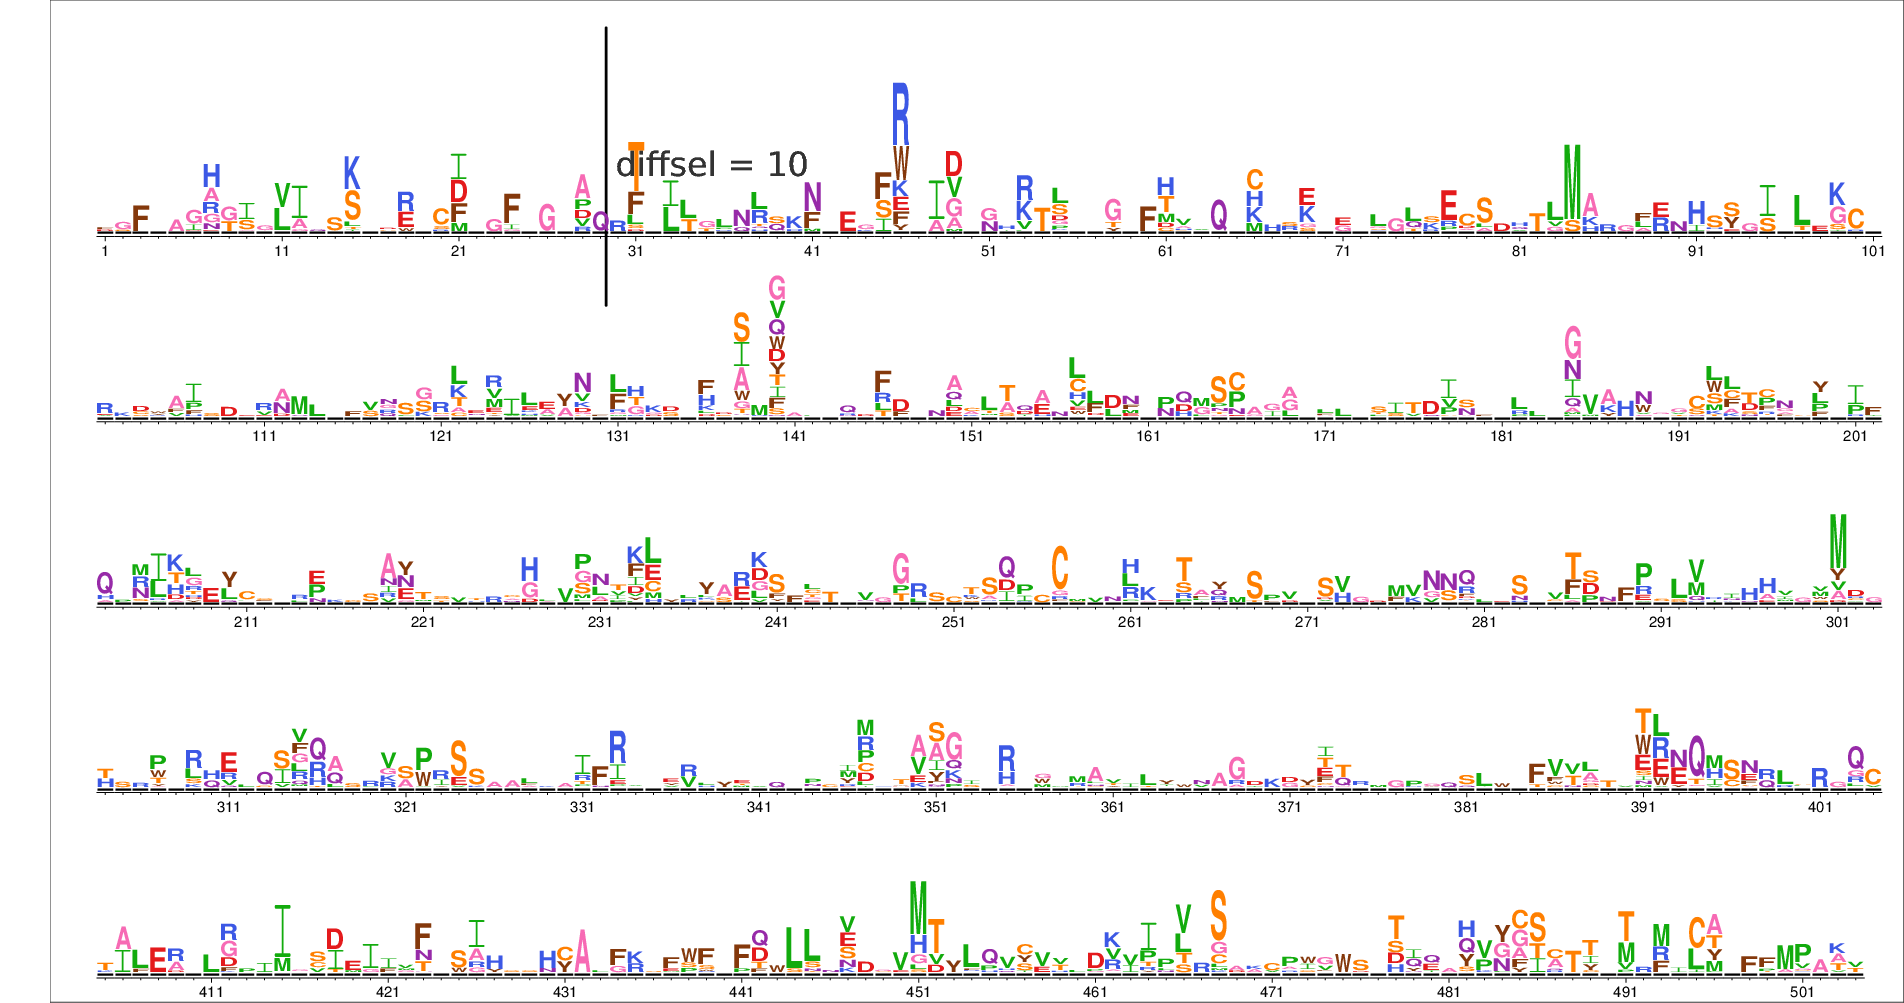

logoplot for EDE1-C8 shown below, saved to ./results/mean_selected_logoplots/EDE1-C8_diffsel.pdf


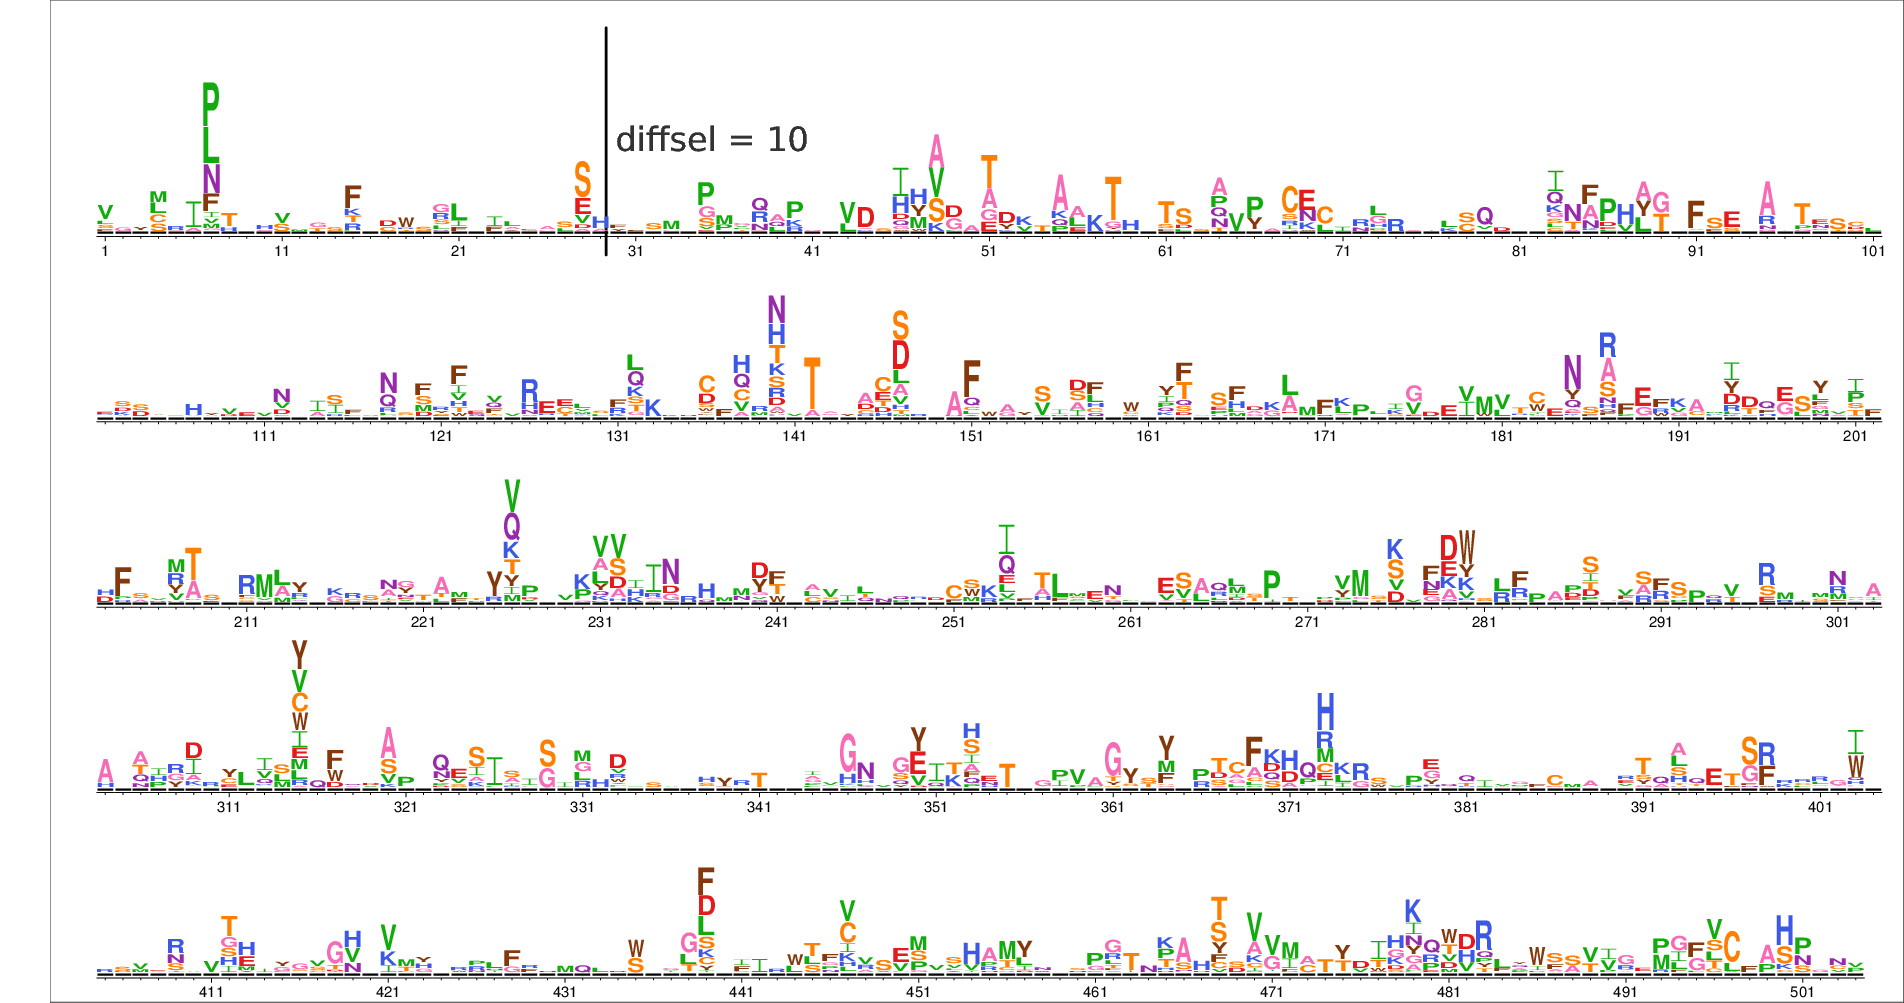

logoplot for MZ4 shown below, saved to ./results/mean_selected_logoplots/MZ4_diffsel.pdf


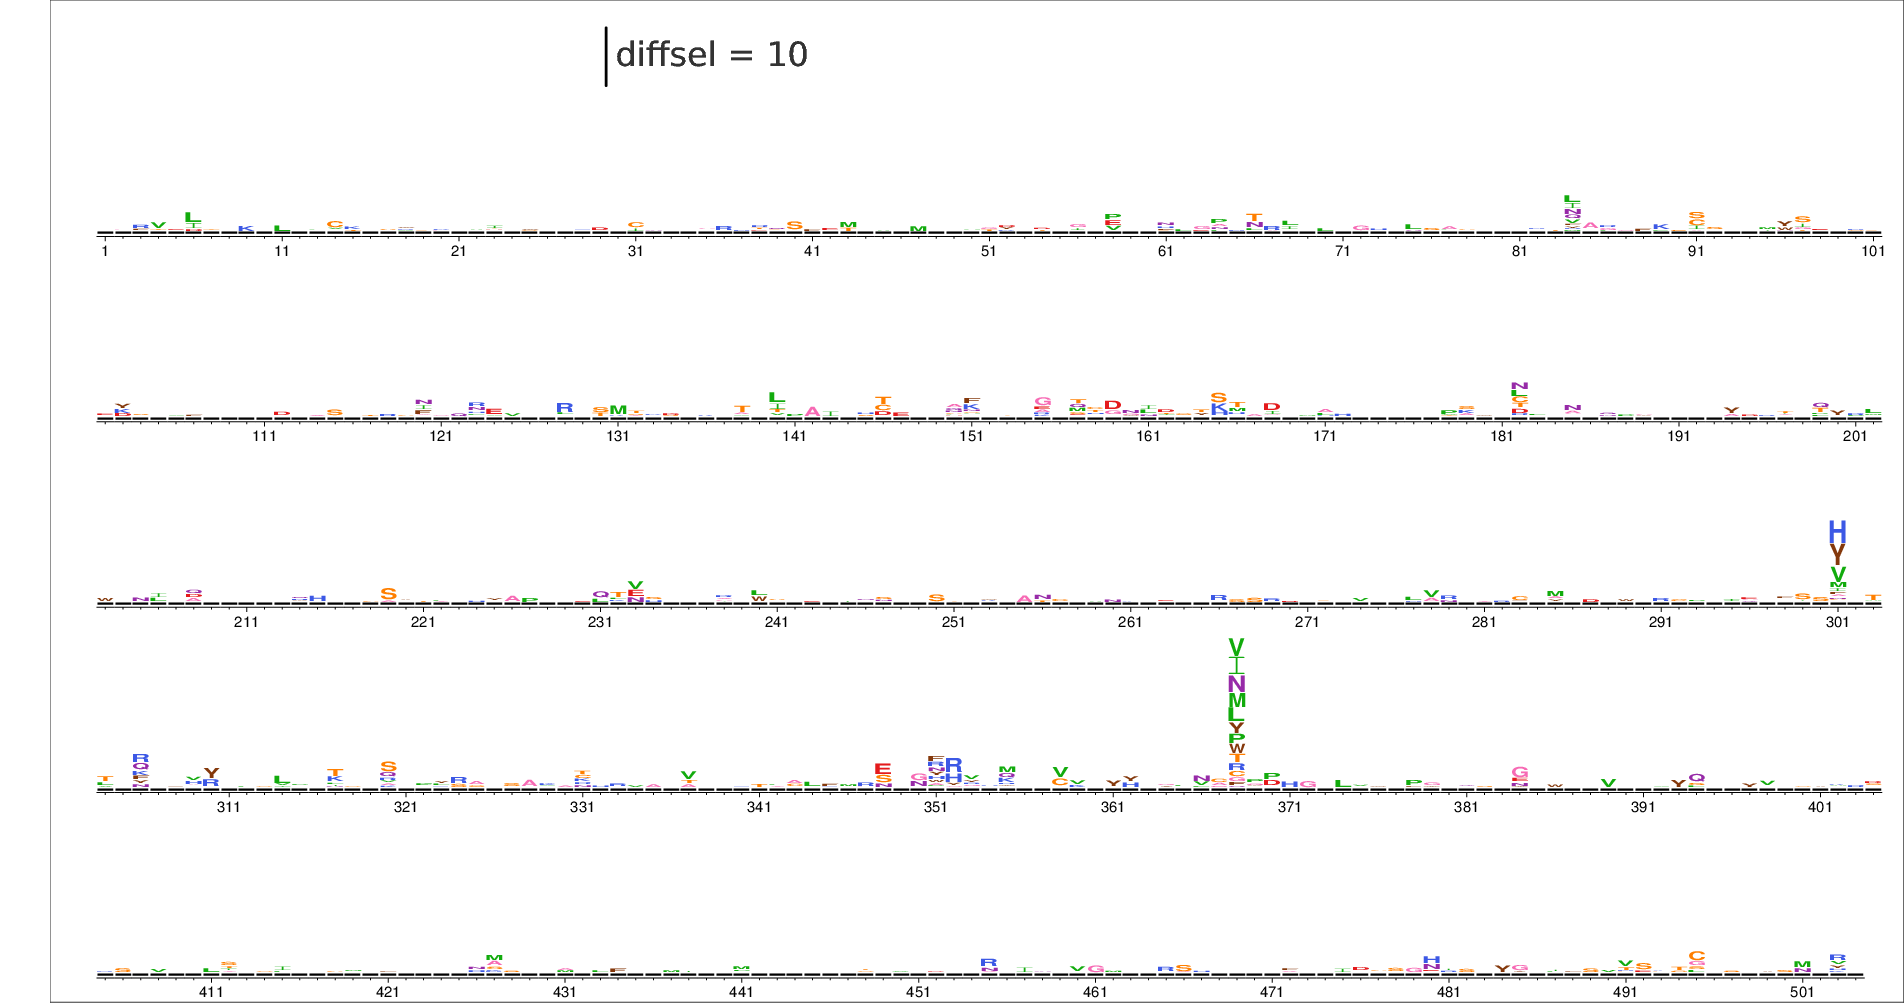

logoplot for ZKA-64 shown below, saved to ./results/mean_selected_logoplots/ZKA-64_diffsel.pdf


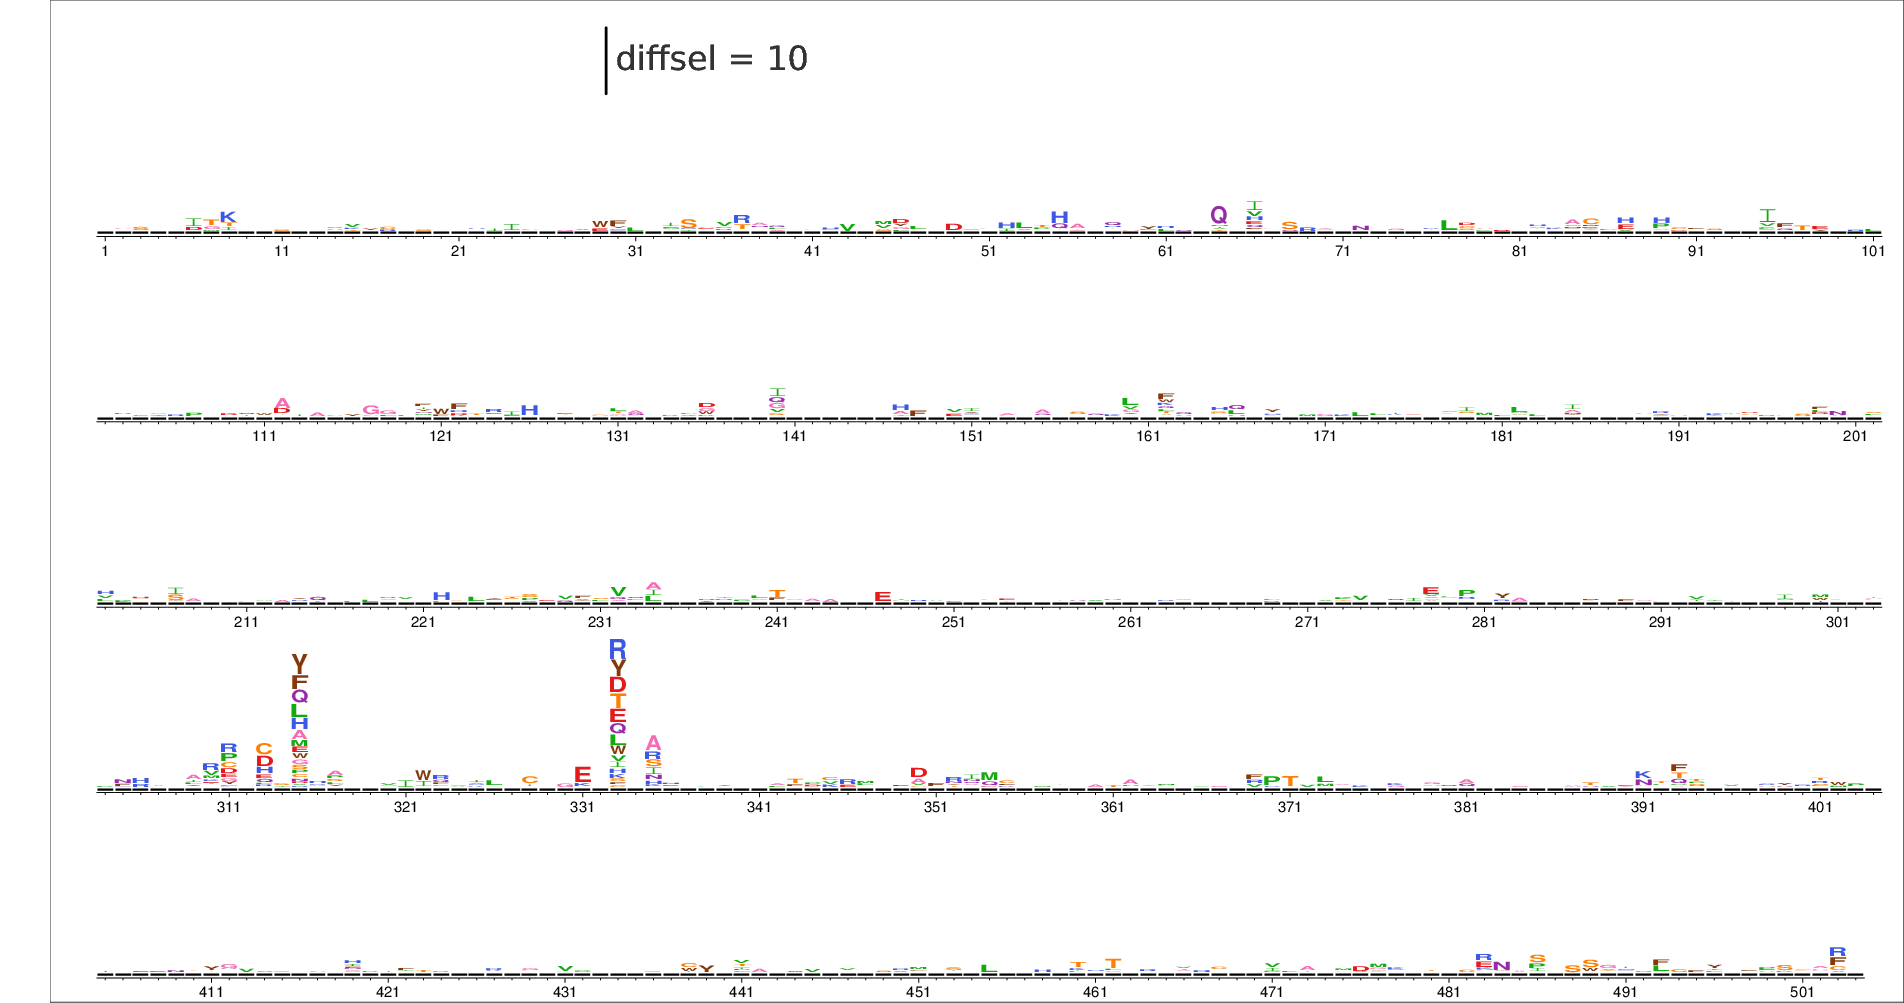

logoplot for ZV-67 shown below, saved to ./results/mean_selected_logoplots/ZV-67_diffsel.pdf


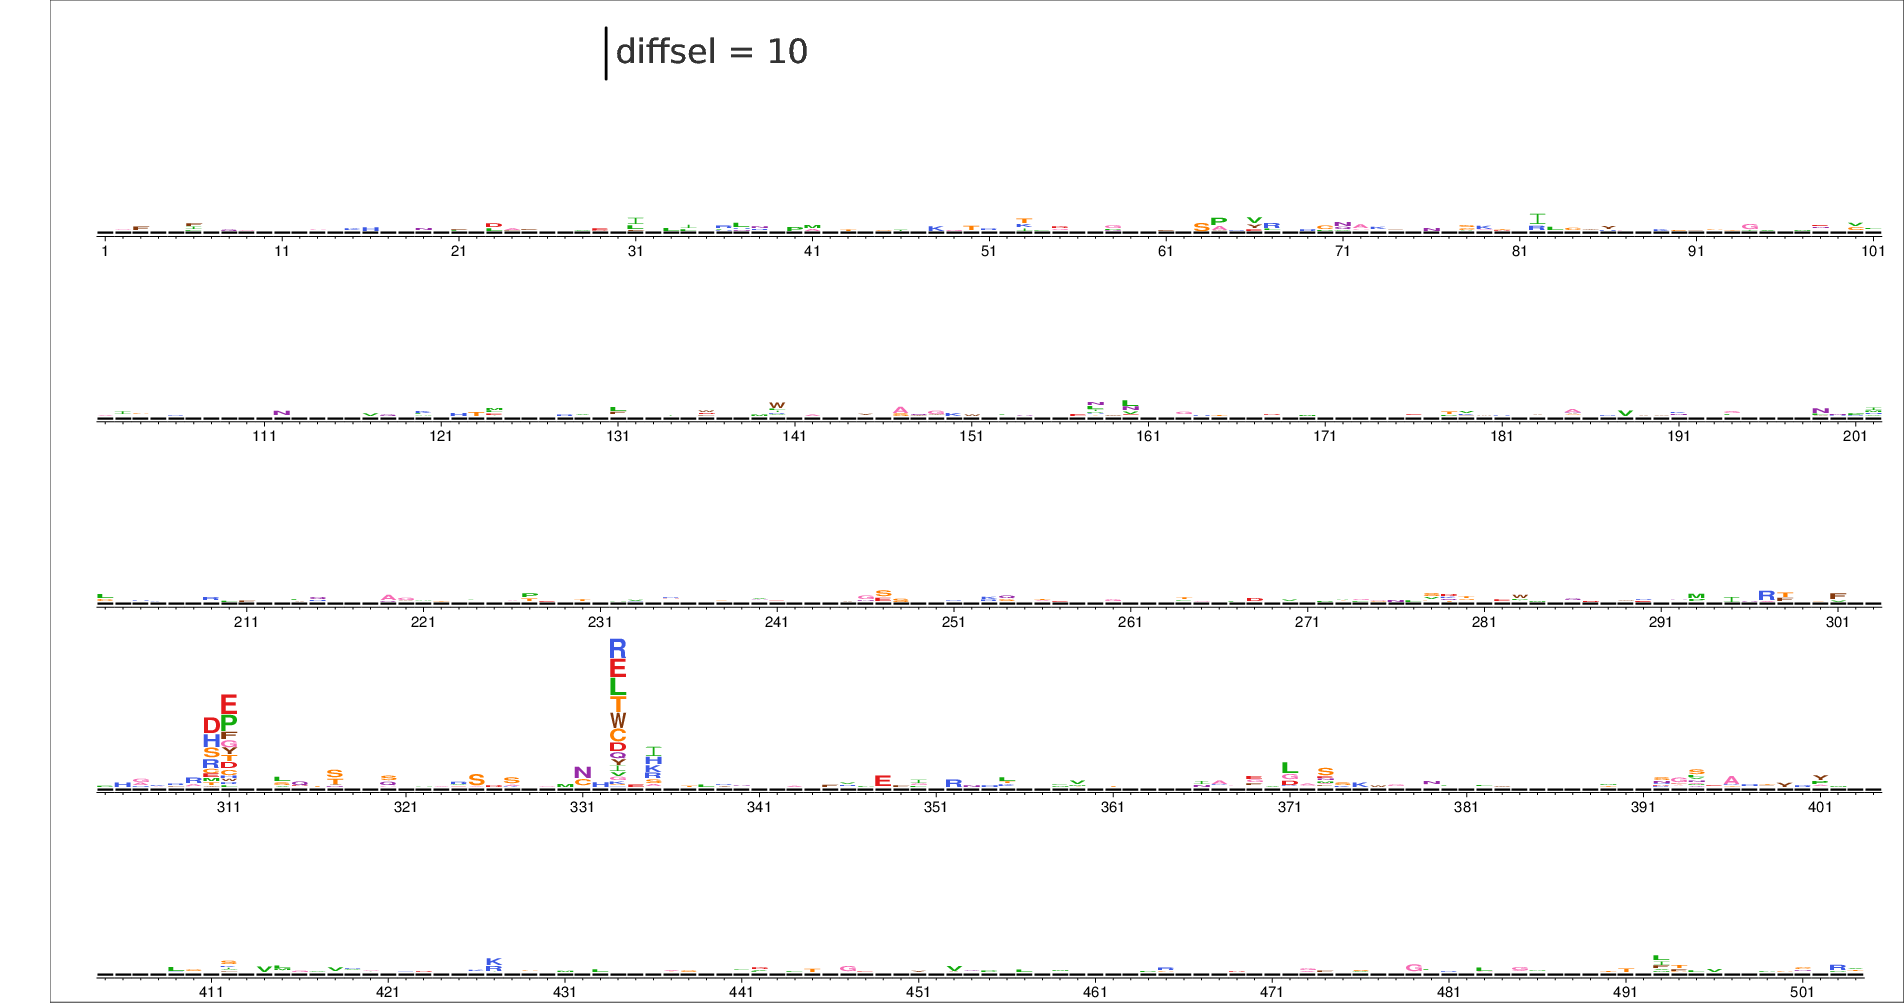

logoplot for SiGN-3C shown below, saved to ./results/mean_selected_logoplots/SiGN-3C_diffsel.pdf


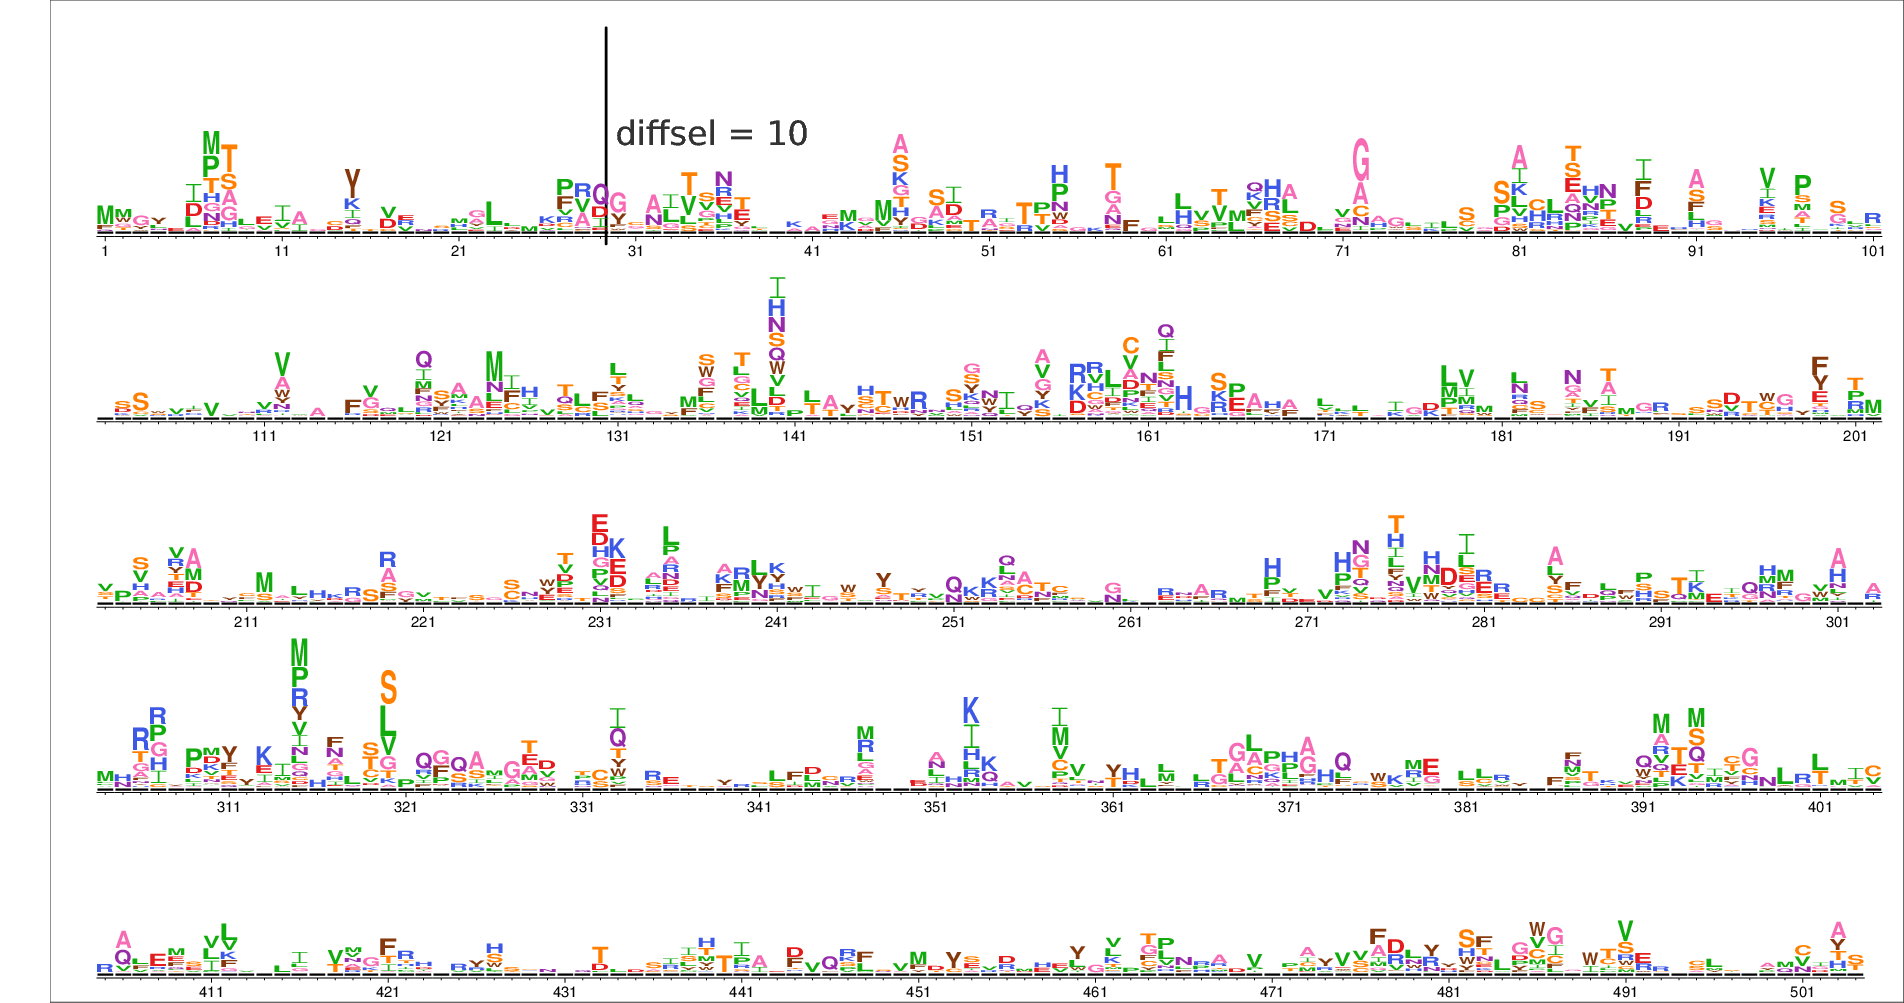

In [47]:
# for each selected antibody concentration, produce averaged grouped logoplots
for ab in selected_diffsel_batch.group.unique():
    diffselfile = os.path.join(selected_diffseldir, f'summary_{ab}-meanmutdiffsel.csv')
    baka = ! dms2_logoplot \
        --outdir {mean_sel_logodir} \
        --ncpus 16 \
        --name {ab} \
        --diffsel {diffselfile} \
        --restrictdiffsel positive \
        --nperline 101 \
        --scalebar 10 "diffsel = 10" \
        --underlay yes \
        --use_existing {use_existing}

# show logoplot results by antibody 'group'
for sample in selected_diffsel_batch['group'].unique():
    print(f'logoplot for {sample} shown below, saved to ' + os.path.join(mean_sel_logodir, sample + '_diffsel.pdf'))
    showPDF(os.path.join(mean_sel_logodir, sample + '_diffsel.pdf'))

logoplot for EDE1-C10 shown below, saved to ./results/median_selected_logoplots/EDE1-C10_diffsel.pdf


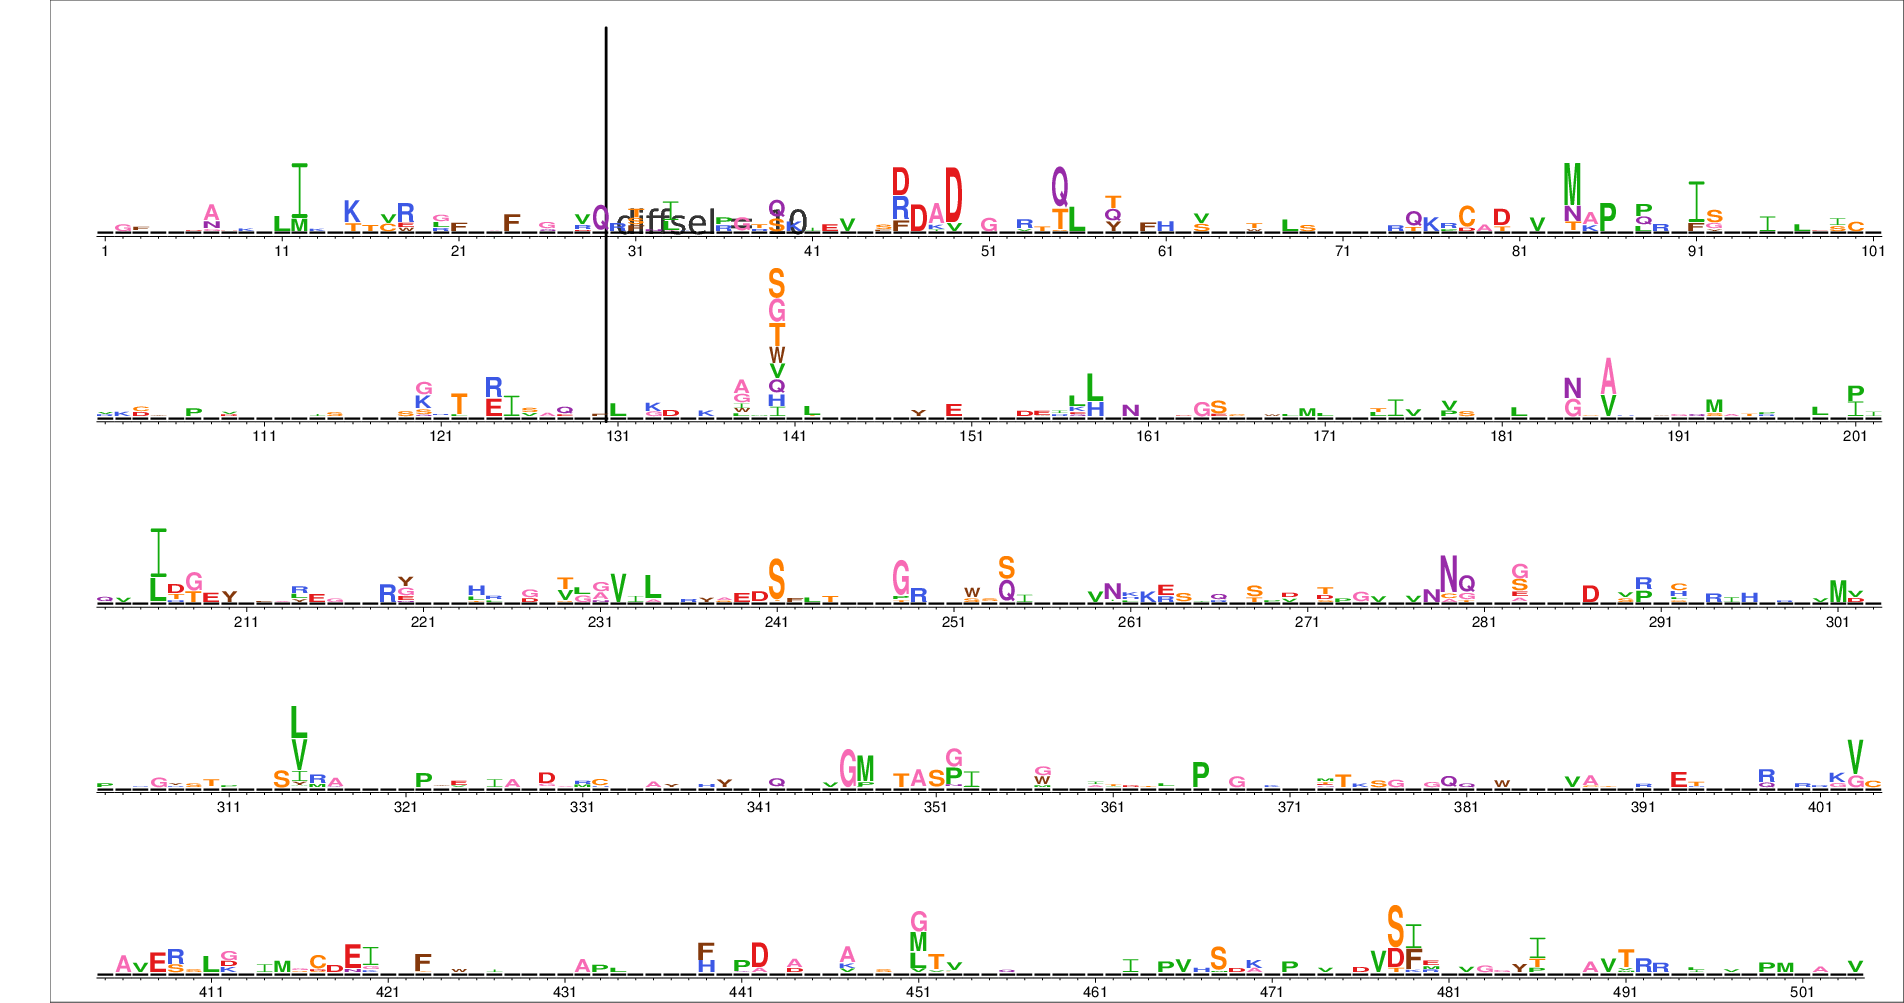

logoplot for EDE1-C8 shown below, saved to ./results/median_selected_logoplots/EDE1-C8_diffsel.pdf


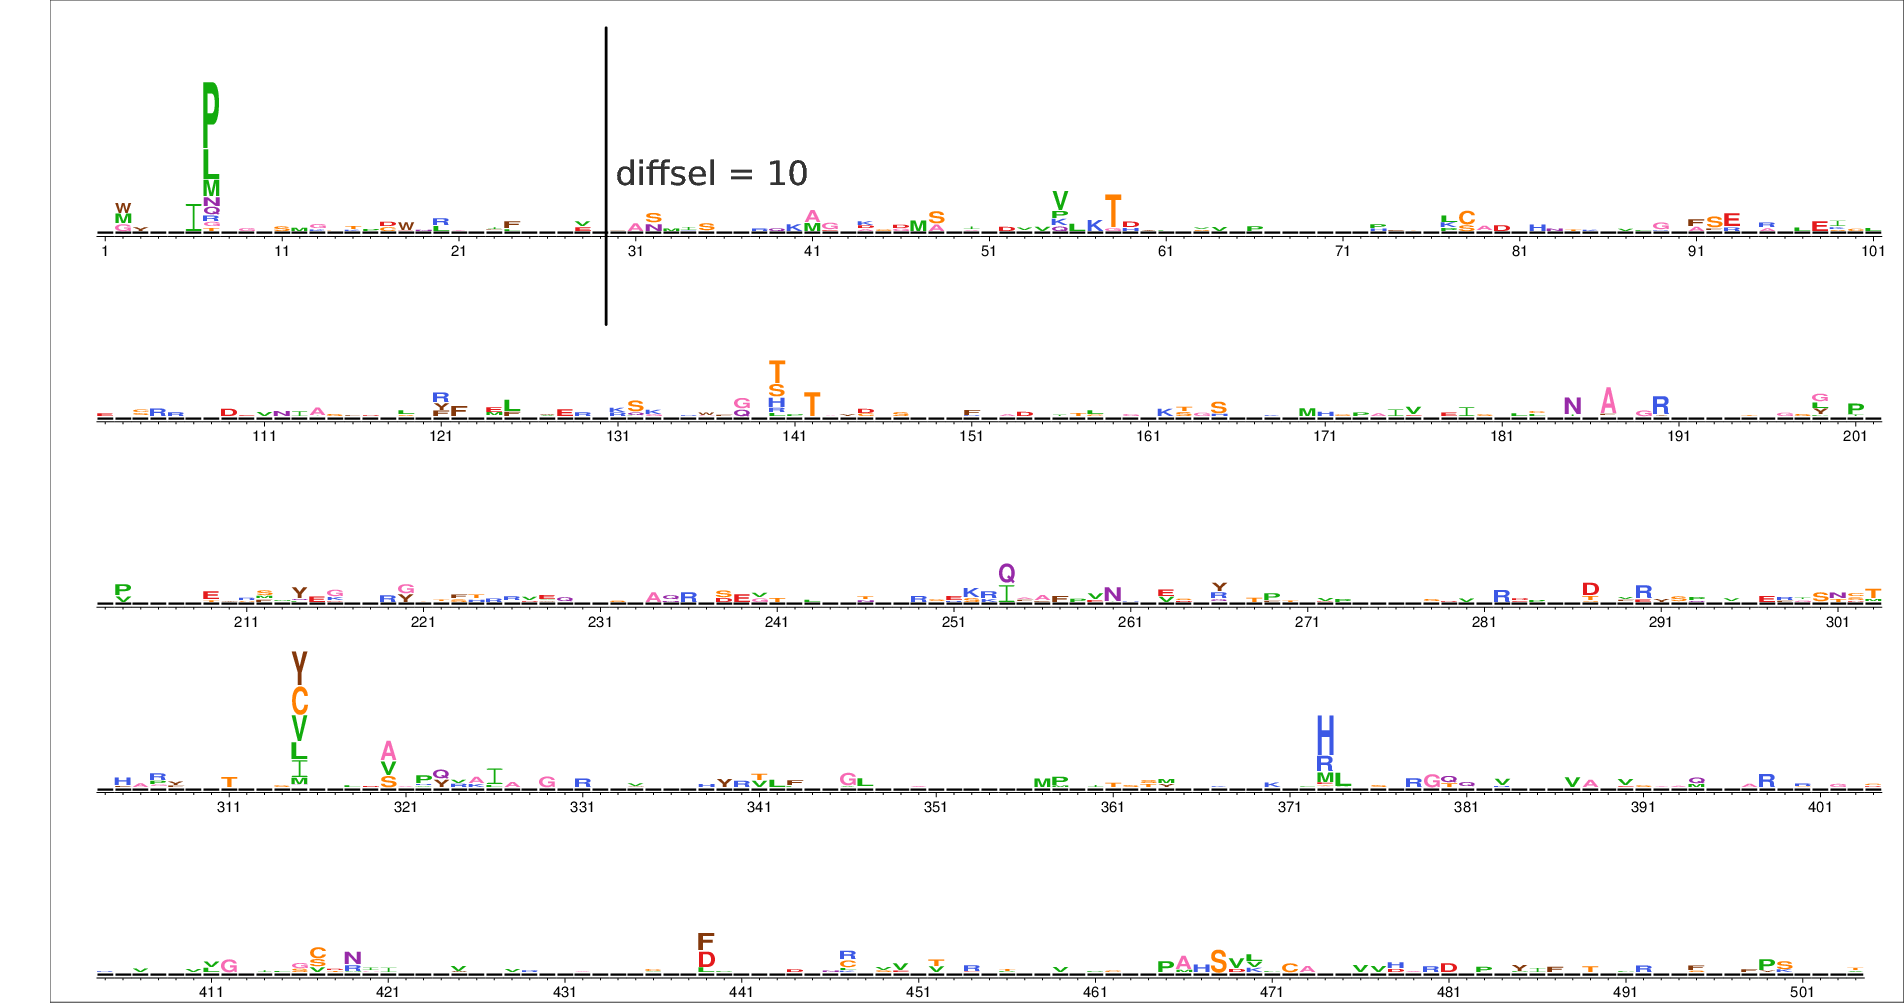

logoplot for MZ4 shown below, saved to ./results/median_selected_logoplots/MZ4_diffsel.pdf


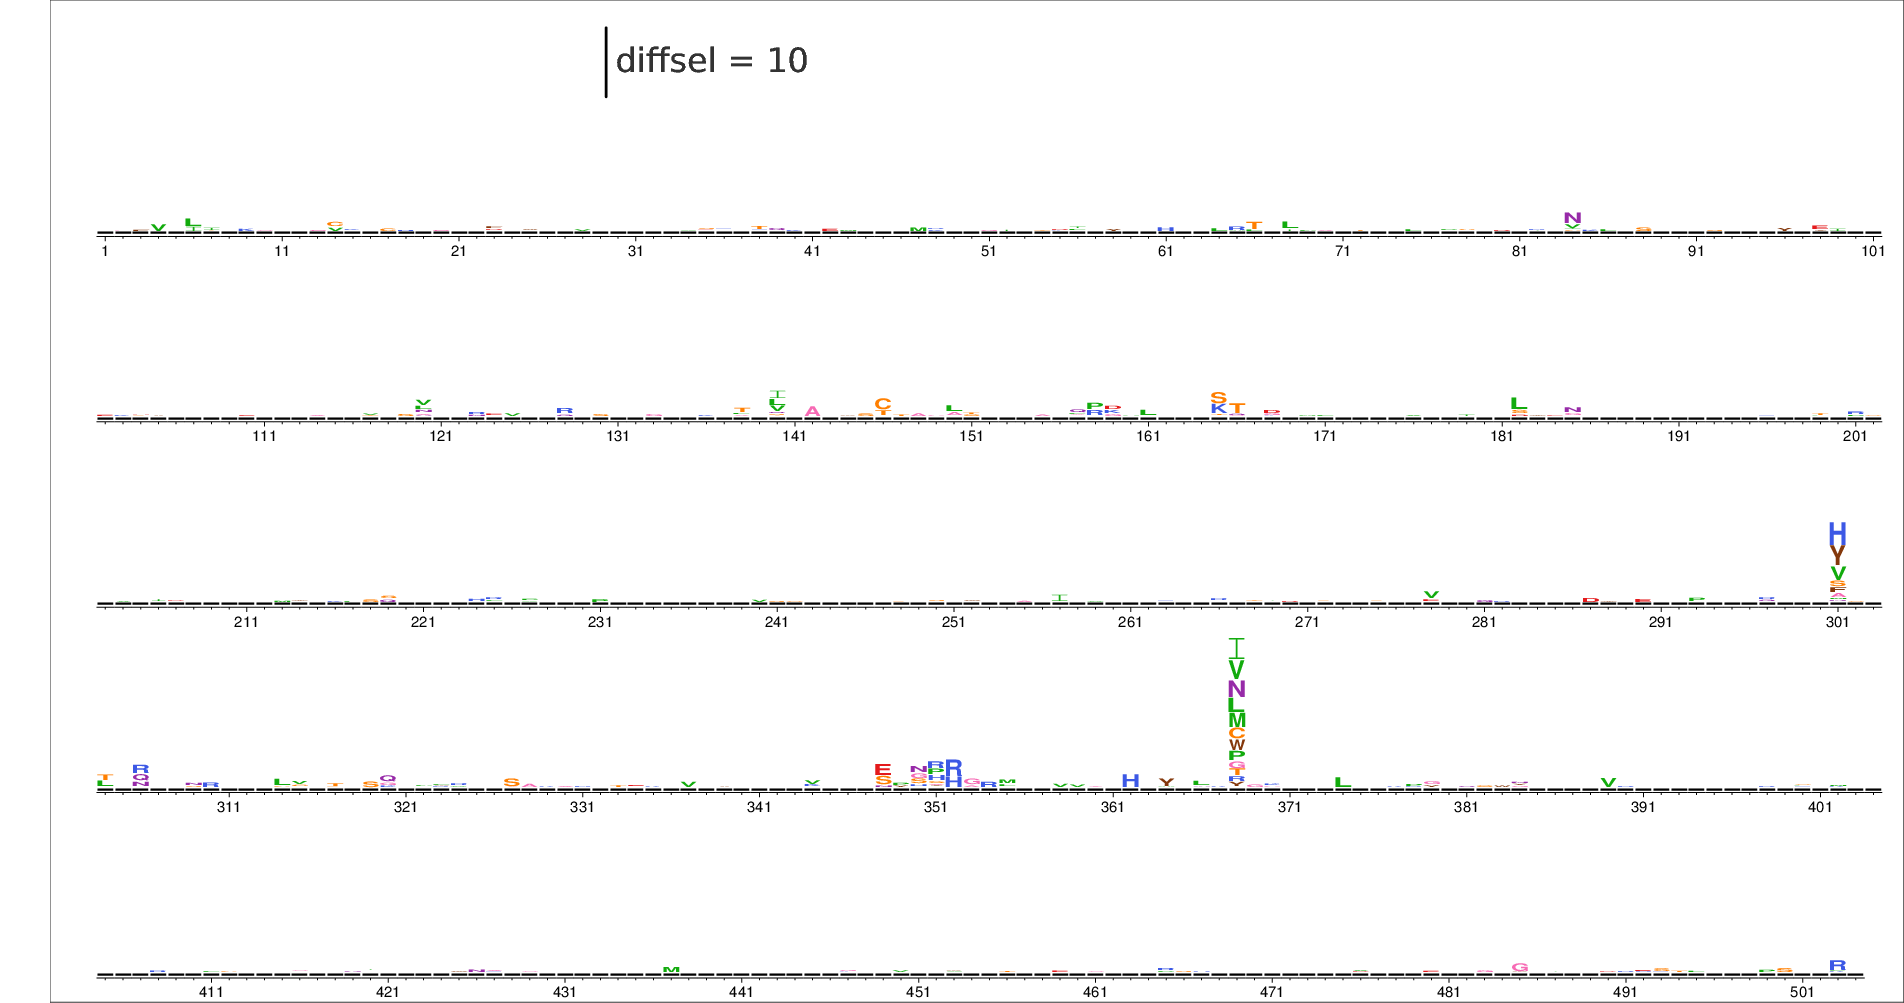

logoplot for ZKA-64 shown below, saved to ./results/median_selected_logoplots/ZKA-64_diffsel.pdf


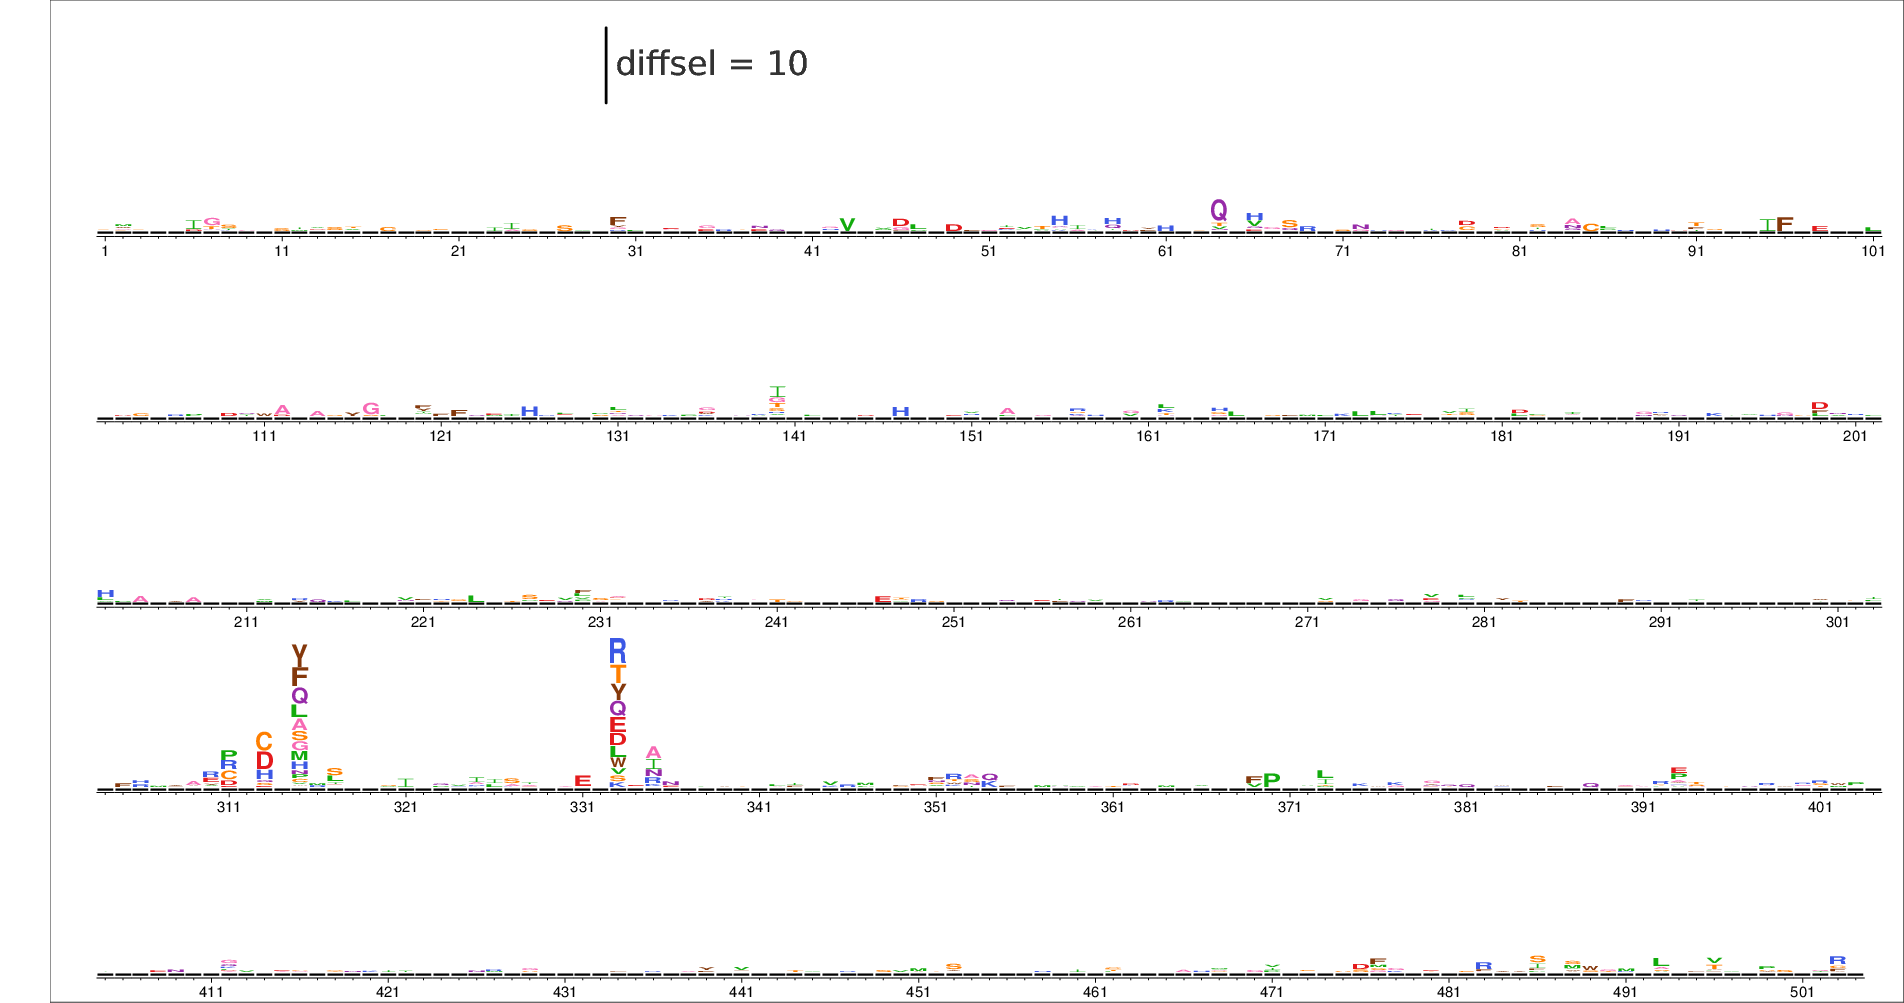

logoplot for ZV-67 shown below, saved to ./results/median_selected_logoplots/ZV-67_diffsel.pdf


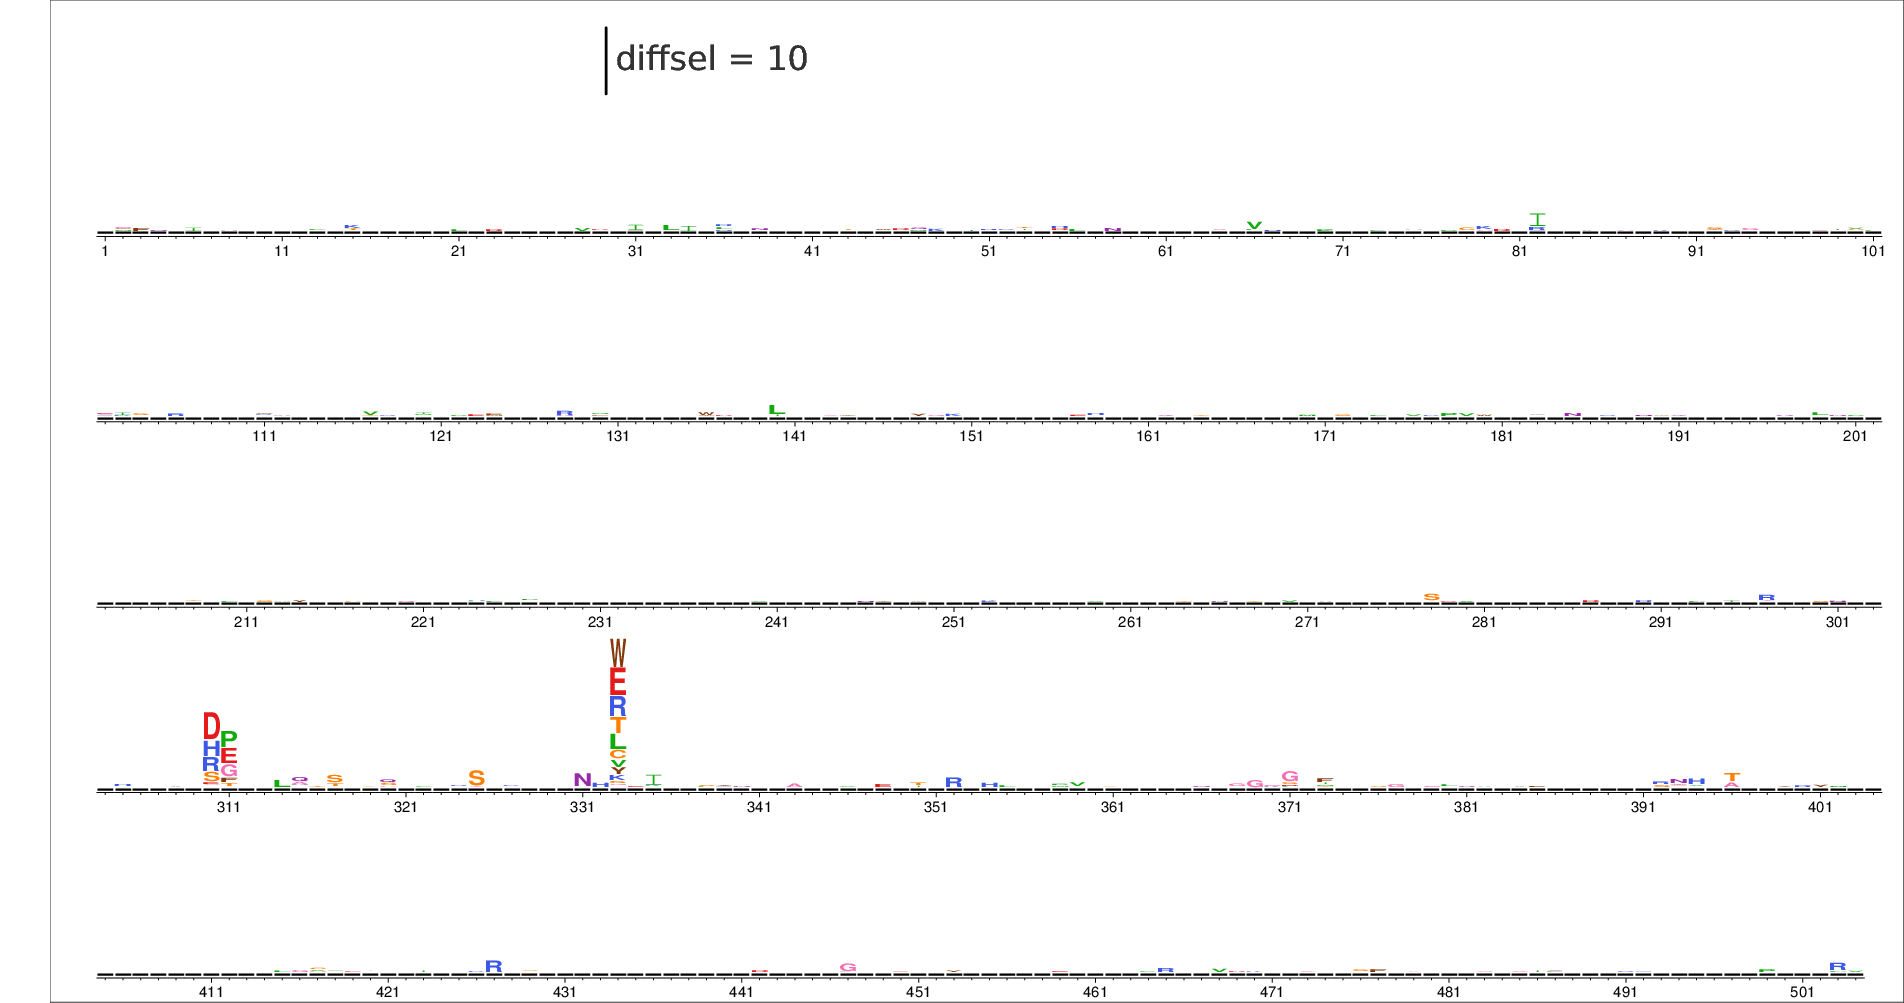

logoplot for SiGN-3C shown below, saved to ./results/median_selected_logoplots/SiGN-3C_diffsel.pdf


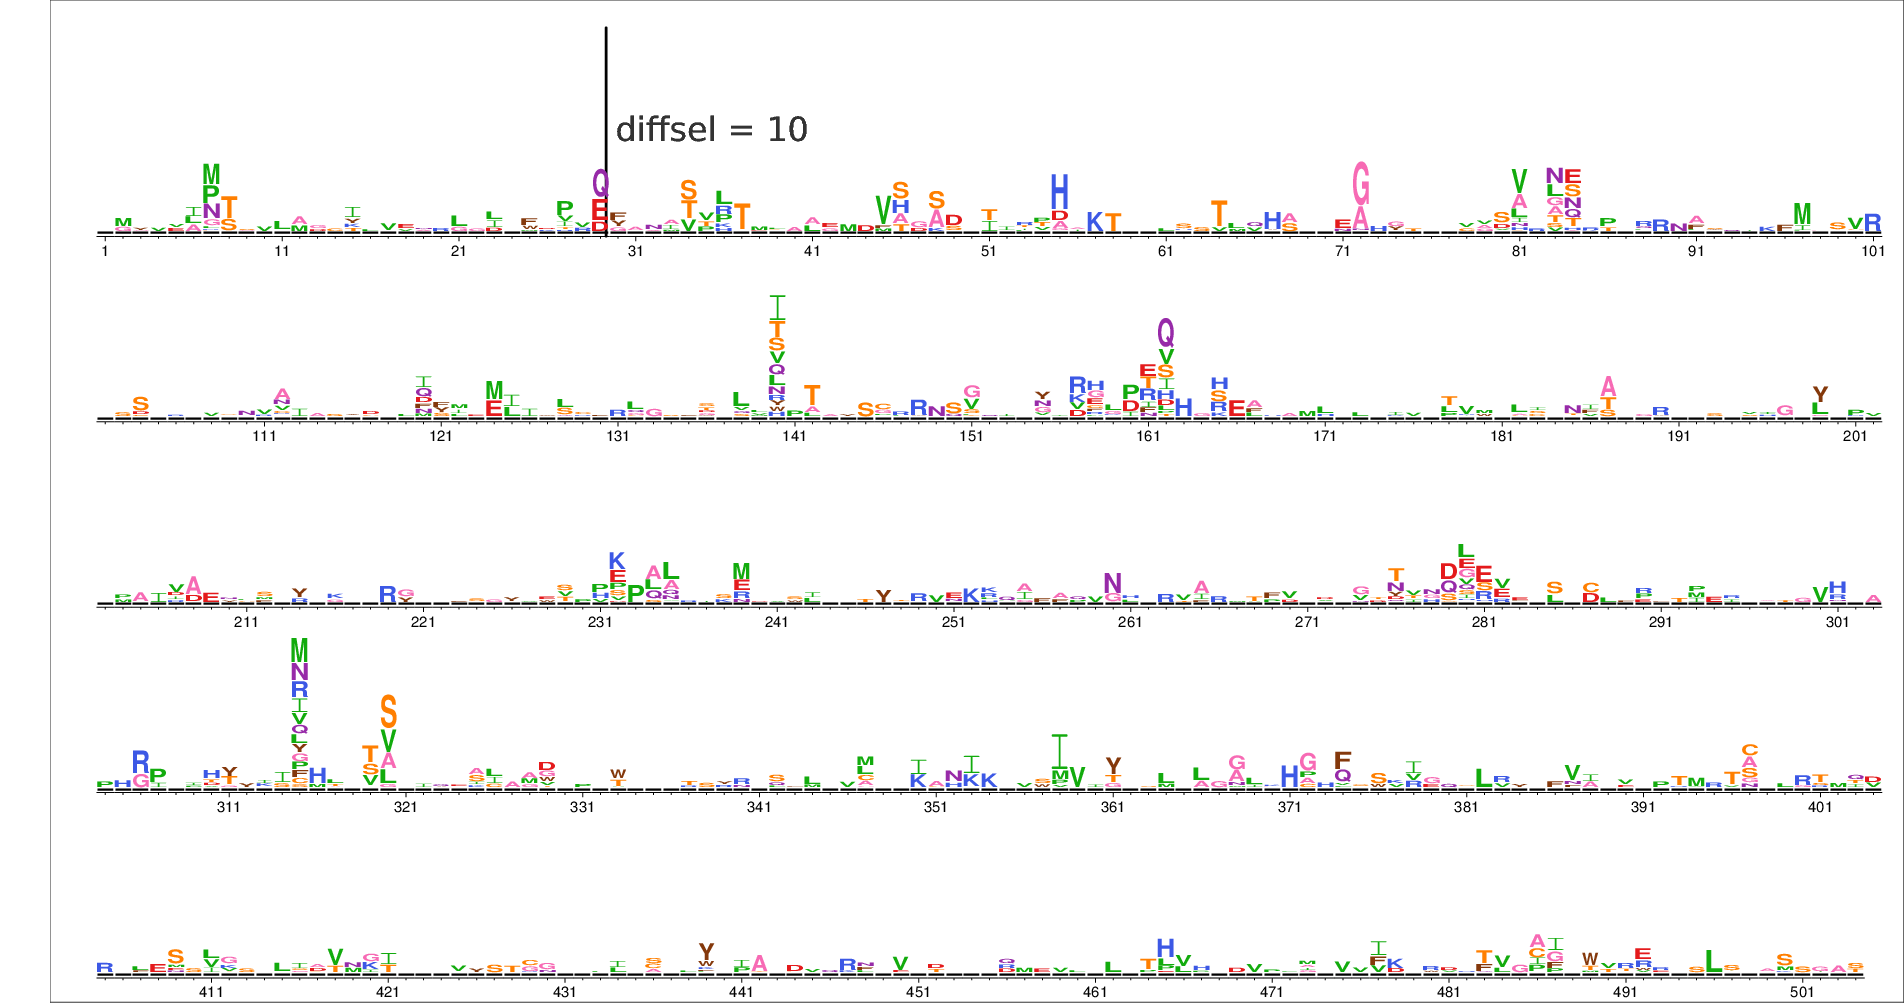

In [48]:
# for each selected antibody concentration, produce median grouped logoplots
for ab in selected_diffsel_batch.group.unique():
    diffselfile = os.path.join(diffseldir, f'summary_{ab}-medianmutdiffsel.csv')
    baka = ! dms2_logoplot \
        --outdir {median_sel_logodir} \
        --ncpus 16 \
        --name {ab} \
        --diffsel {diffselfile} \
        --restrictdiffsel positive \
        --nperline 101 \
        --scalebar 10 "diffsel = 10" \
        --underlay yes \
        --use_existing {use_existing}

# show logoplot results by antibody 'group'
for sample in selected_diffsel_batch['group'].unique():
    print(f'logoplot for {sample} shown below, saved to ' + os.path.join(median_sel_logodir, sample + '_diffsel.pdf'))
    showPDF(os.path.join(median_sel_logodir, sample + '_diffsel.pdf'))

# Create `dms-view` input files
We can create files to visualize our DMS results on protein structure using [dms-view](https://dms-view.github.io).
To do this, we will require E protein PDB structures. These were files were selected in the JV-2019 paper and I am using the same set of inputs here. I'll focus on 5IRE, published in [Science (2016)](https://www.science.org/doi/10.1126/science.aaf5316). Other PDB files (ie, for crystallized ab and E) will be aligned in PyMOL. 

I have made these files using single selected concentrations of each antibody rather than compiling all concentrations into a single file, mostly because this is what the Bloom lab appears to normally show and because the noise levels look similar in logoplots.  

The PDB files contain 3 chains of 504 aa E protein -- previous JV-2019 analysis has only examined E monomer structure (A chain only). I will produce dms-view input file for C/E chains (homodimer) and input file for A/C/E chains (homodimer+additional monomer). 

In [28]:
# make directories
dms_view_dir = os.path.join(resultsdir, 'dms_view')
os.makedirs(dms_view_dir, exist_ok=True)

In [29]:
# for selected concentrations of each antibody
diffsel_files = (selected_diffsel_batch
                 .assign(mean_mutdiffsel = lambda x: (diffseldir + '/summary_' + 
                                               x['group'] + '-meanmutdiffsel.csv'),
                          median_mutdiffsel = lambda x: (diffseldir + '/summary_' + 
                                               x['group'] + '-medianmutdiffsel.csv'),
                          mean_sitediffsel = lambda x: (diffseldir + '/summary_' + 
                                               x['group'] + '-meansitediffsel.csv'),
                          median_sitediffsel = lambda x: (diffseldir + '/summary_' + 
                                               x['group'] + '-mediansitediffsel.csv')
                         )
                 [['group',
                   'mean_mutdiffsel', 'median_mutdiffsel',
                   'mean_sitediffsel', 'median_sitediffsel']]
                 .drop_duplicates()
                 # .set_index('name')
                )
                
                        
diffsel_files

group                                    mean_mutdiffsel  \
0   EDE1-C10  ./results/diffsel/summary_EDE1-C10-meanmutdiff...   
3    EDE1-C8  ./results/diffsel/summary_EDE1-C8-meanmutdiffs...   
6        MZ4   ./results/diffsel/summary_MZ4-meanmutdiffsel.csv   
9     ZKA-64  ./results/diffsel/summary_ZKA-64-meanmutdiffse...   
12     ZV-67  ./results/diffsel/summary_ZV-67-meanmutdiffsel...   
15   SiGN-3C  ./results/diffsel/summary_SiGN-3C-meanmutdiffs...   

                                    median_mutdiffsel  \
0   ./results/diffsel/summary_EDE1-C10-medianmutdi...   
3   ./results/diffsel/summary_EDE1-C8-medianmutdif...   
6   ./results/diffsel/summary_MZ4-medianmutdiffsel...   
9   ./results/diffsel/summary_ZKA-64-medianmutdiff...   
12  ./results/diffsel/summary_ZV-67-medianmutdiffs...   
15  ./results/diffsel/summary_SiGN-3C-medianmutdif...   

                                     mean_sitediffsel  \
0   ./results/diffsel/summary_EDE1-C10-meansitedif...   
3   ./results/diffsel/summary_EDE1-C8-meansitediff...   
6   ./results/diffsel/summary_MZ4-meansitediffsel.csv   
9   ./results/diffsel/summary_ZKA-64-meansitediffs...   
12  ./results/diffsel/summary_ZV-67-meansitediffse...   
15  ./results/diffsel/summary_SiGN-3C-meansitediff...   

                                   median_sitediffsel  
0   ./results/diffsel/summary_EDE1-C10-mediansited...  
3   ./results/diffsel/summary_EDE1-C8-mediansitedi...  
6   ./results/diffsel/summary_MZ4-mediansitediffse...  
9   ./results/diffsel/summary_ZKA-64-mediansitedif...  
12  ./results/diffsel/summary_ZV-67-mediansitediff...  
15  ./results/diffsel/summary_SiGN-3C-mediansitedi...

In [30]:
next(diffsel_files.iterrows())[1]

group                                                          EDE1-C10
mean_mutdiffsel       ./results/diffsel/summary_EDE1-C10-meanmutdiff...
median_mutdiffsel     ./results/diffsel/summary_EDE1-C10-medianmutdi...
mean_sitediffsel      ./results/diffsel/summary_EDE1-C10-meansitedif...
median_sitediffsel    ./results/diffsel/summary_EDE1-C10-mediansited...
Name: 0, dtype: object

In [31]:
# make dms-view data files
# these should contain sites, wt, mutation, condition 
# as well as the PDB file protein_chain and protein_site
# these will include mut_* values since we are interested in mapping escape mutants

# make dataframe for all conditions/concentrations with site, wt, mut and mutdiffsel values
dmsview_df = pd.DataFrame()

for index, info in diffsel_files.iterrows():
    name = info.str.split('/t')[0][0]
    meanmut_csv = info.str.split('/t')[1][0]
    medianmut_csv = info.str.split('/t')[2][0]
    meansite_csv = info.str.split('/t')[3][0]
    mediansite_csv = info.str.split('/t')[4][0]
    
    dmsview_df = (dmsview_df
                   .append(pd.read_csv(meanmut_csv)
                           .melt(id_vars = ['site', 'wildtype', 'mutation'],
                                 value_vars = ['mutdiffsel'],
                                 value_name = 'meanmut_diffsel')
                           [['site','wildtype','mutation','meanmut_diffsel']]
                           .sort_values(by = ['site'])
                           .reset_index(drop=True)
                           .assign(condition = name,
                                   mutant = lambda x: x['wildtype'] + x['site'].astype(str) + x['mutation'])
                           .merge(pd.read_csv(medianmut_csv)
                                  .assign(mutant = lambda x: x['wildtype'] + x['site'].astype(str) + x['mutation'])
                                  .rename(columns = {'mutdiffsel': 'medianmut_diffsel'})
                                  [['mutant', 'medianmut_diffsel']],
                                  on = 'mutant',
                                  validate = 'one_to_one')
                           .merge(pd.read_csv(meansite_csv)
                                  .rename(columns = {'abs_diffsel' : 'site_mean_abs_diffsel',
                                                     'positive_diffsel' : 'site_mean_positive_diffsel',
                                                     'negative_diffsel' : 'site_mean_negative_diffsel',
                                                     'max_diffsel' : 'site_mean_max_diffsel',
                                                     'min_diffsel' : 'site_mean_min_diffsel'})
                                  .sort_values(by = 'site')
                                  .reset_index(drop=True),
                                  on = 'site',
                                  validate = 'many_to_one')
                           .merge(pd.read_csv(mediansite_csv)
                                  .rename(columns = {'abs_diffsel' : 'site_median_abs_diffsel',
                                                     'positive_diffsel' : 'site_median_positive_diffsel',
                                                     'negative_diffsel' : 'site_median_negative_diffsel',
                                                     'max_diffsel' : 'site_median_max_diffsel',
                                                     'min_diffsel' : 'site_median_min_diffsel'})
                                  .sort_values(by = 'site')
                                  .reset_index(drop=True),
                                  on = 'site',
                                  validate = 'many_to_one')
                          )
                  )
                  
            

print('Here is the diffsel dataframe we will add protein labels to...')
dmsview_df

Here is the diffsel dataframe we will add protein labels to...


site wildtype mutation  meanmut_diffsel condition mutant  \
0         1        I        N        -0.267974  EDE1-C10    I1N   
1         1        I        G        -0.000487  EDE1-C10    I1G   
2         1        I        E        -0.000487  EDE1-C10    I1E   
3         1        I        W        -0.000487  EDE1-C10    I1W   
4         1        I        A        -0.000487  EDE1-C10    I1A   
...     ...      ...      ...              ...       ...    ...   
10075   504        A        E         0.000044   SiGN-3C  A504E   
10076   504        A        H         0.000044   SiGN-3C  A504H   
10077   504        A        M         0.000044   SiGN-3C  A504M   
10078   504        A        V        -0.082893   SiGN-3C  A504V   
10079   504        A        A              NaN   SiGN-3C  A504A   

       medianmut_diffsel  site_mean_abs_diffsel  site_mean_positive_diffsel  \
0              -0.262495               6.472304                    0.066468   
1              -0.000590               6.472304                    0.066468   
2              -0.000590               6.472304                    0.066468   
3              -0.000590               6.472304                    0.066468   
4              -0.000590               6.472304                    0.066468   
...                  ...                    ...                         ...   
10075           0.000050               0.731929                    0.479731   
10076           0.000050               0.731929                    0.479731   
10077           0.000050               0.731929                    0.479731   
10078          -0.039807               0.731929                    0.479731   
10079                NaN               0.731929                    0.479731   

       site_mean_negative_diffsel  site_mean_max_diffsel  \
0                       -6.405837               0.066468   
1                       -6.405837               0.066468   
2                       -6.405837               0.066468   
3                       -6.405837               0.066468   
4                       -6.405837               0.066468   
...                           ...                    ...   
10075                   -0.252198               0.251485   
10076                   -0.252198               0.251485   
10077                   -0.252198               0.251485   
10078                   -0.252198               0.251485   
10079                   -0.252198               0.251485   

       site_mean_min_diffsel  site_median_abs_diffsel  \
0                  -2.070944                 6.534581   
1                  -2.070944                 6.534581   
2                  -2.070944                 6.534581   
3                  -2.070944                 6.534581   
4                  -2.070944                 6.534581   
...                      ...                      ...   
10075              -0.104280                 0.535146   
10076              -0.104280                 0.535146   
10077              -0.104280                 0.535146   
10078              -0.104280                 0.535146   
10079              -0.104280                 0.535146   

       site_median_positive_diffsel  site_median_negative_diffsel  \
0                          0.000000                     -6.534581   
1                          0.000000                     -6.534581   
2                          0.000000                     -6.534581   
3                          0.000000                     -6.534581   
4                          0.000000                     -6.534581   
...                             ...                           ...   
10075                      0.495339                     -0.039807   
10076                      0.495339                     -0.039807   
10077                      0.495339                     -0.039807   
10078                      0.495339                     -0.039807   
10079                      0.495339                     -0.039807   

       site_median

In [32]:
# homodimer dms-view input file
homodimer_dmsview_df = pd.DataFrame() 

chain = 'C E'
    
homodimer_dmsview_df = (dmsview_df
               .assign(protein_chain = chain,
                      protein_site = lambda x: x['site'],
                      label_site = lambda x: x['site'])
               .dropna()
                      )

# save these files and preview dataframe
dimer_csv = os.path.join(dms_view_dir, 'dimer_dms_data.csv')
print(f"Writing CSV to {dimer_csv}; here is a preview...")

homodimer_dmsview_df.to_csv(dimer_csv, index=False, float_format='%.3g')
homodimer_dmsview_df

Writing CSV to ./results/dms_view/dimer_dms_data.csv; here is a preview...


site wildtype mutation  meanmut_diffsel condition mutant  \
0         1        I        N        -0.267974  EDE1-C10    I1N   
1         1        I        G        -0.000487  EDE1-C10    I1G   
2         1        I        E        -0.000487  EDE1-C10    I1E   
3         1        I        W        -0.000487  EDE1-C10    I1W   
4         1        I        A        -0.000487  EDE1-C10    I1A   
...     ...      ...      ...              ...       ...    ...   
10074   504        A        C         0.000044   SiGN-3C  A504C   
10075   504        A        E         0.000044   SiGN-3C  A504E   
10076   504        A        H         0.000044   SiGN-3C  A504H   
10077   504        A        M         0.000044   SiGN-3C  A504M   
10078   504        A        V        -0.082893   SiGN-3C  A504V   

       medianmut_diffsel  site_mean_abs_diffsel  site_mean_positive_diffsel  \
0              -0.262495               6.472304                    0.066468   
1              -0.000590               6.472304                    0.066468   
2              -0.000590               6.472304                    0.066468   
3              -0.000590               6.472304                    0.066468   
4              -0.000590               6.472304                    0.066468   
...                  ...                    ...                         ...   
10074           0.000050               0.731929                    0.479731   
10075           0.000050               0.731929                    0.479731   
10076           0.000050               0.731929                    0.479731   
10077           0.000050               0.731929                    0.479731   
10078          -0.039807               0.731929                    0.479731   

       site_mean_negative_diffsel  site_mean_max_diffsel  \
0                       -6.405837               0.066468   
1                       -6.405837               0.066468   
2                       -6.405837               0.066468   
3                       -6.405837               0.066468   
4                       -6.405837               0.066468   
...                           ...                    ...   
10074                   -0.252198               0.251485   
10075                   -0.252198               0.251485   
10076                   -0.252198               0.251485   
10077                   -0.252198               0.251485   
10078                   -0.252198               0.251485   

       site_mean_min_diffsel  site_median_abs_diffsel  \
0                  -2.070944                 6.534581   
1                  -2.070944                 6.534581   
2                  -2.070944                 6.534581   
3                  -2.070944                 6.534581   
4                  -2.070944                 6.534581   
...                      ...                      ...   
10074              -0.104280                 0.535146   
10075              -0.104280                 0.535146   
10076              -0.104280                 0.535146   
10077              -0.104280                 0.535146   
10078              -0.104280                 0.535146   

       site_median_positive_diffsel  site_median_negative_diffsel  \
0                          0.000000                     -6.534581   
1                          0.000000                     -6.534581   
2                          0.000000                     -6.534581   
3                          0.000000                     -6.534581   
4                          0.000000                     -6.534581   
...                             ...                           ...   
10074                      0.495339                     -0.039807   
10075                      0.495339                     -0.039807   
10076                      0.495339                     -0.039807   
10077                      0.495339                     -0.039807   
10078                      0.495339                     -0.039807   

       site_median

In [33]:
# all 3 monomers dms-view input file
ace_dmsview_df = pd.DataFrame() 

chain = 'A C E'
    
ace_dmsview_df = (dmsview_df
               .assign(protein_chain = chain,
                      protein_site = lambda x: x['site'],
                      label_site = lambda x: x['site'])
               .dropna()
                      )

# save these files and preview dataframe
data_csv = os.path.join(dms_view_dir, 'ace_dms_data.csv')
print(f"Writing CSV to {data_csv}; here is a preview...")

ace_dmsview_df.to_csv(data_csv, index=False, float_format='%.3g')
ace_dmsview_df

Writing CSV to ./results/dms_view/ace_dms_data.csv; here is a preview...


site wildtype mutation  meanmut_diffsel condition mutant  \
0         1        I        N        -0.267974  EDE1-C10    I1N   
1         1        I        G        -0.000487  EDE1-C10    I1G   
2         1        I        E        -0.000487  EDE1-C10    I1E   
3         1        I        W        -0.000487  EDE1-C10    I1W   
4         1        I        A        -0.000487  EDE1-C10    I1A   
...     ...      ...      ...              ...       ...    ...   
10074   504        A        C         0.000044   SiGN-3C  A504C   
10075   504        A        E         0.000044   SiGN-3C  A504E   
10076   504        A        H         0.000044   SiGN-3C  A504H   
10077   504        A        M         0.000044   SiGN-3C  A504M   
10078   504        A        V        -0.082893   SiGN-3C  A504V   

       medianmut_diffsel  site_mean_abs_diffsel  site_mean_positive_diffsel  \
0              -0.262495               6.472304                    0.066468   
1              -0.000590               6.472304                    0.066468   
2              -0.000590               6.472304                    0.066468   
3              -0.000590               6.472304                    0.066468   
4              -0.000590               6.472304                    0.066468   
...                  ...                    ...                         ...   
10074           0.000050               0.731929                    0.479731   
10075           0.000050               0.731929                    0.479731   
10076           0.000050               0.731929                    0.479731   
10077           0.000050               0.731929                    0.479731   
10078          -0.039807               0.731929                    0.479731   

       site_mean_negative_diffsel  site_mean_max_diffsel  \
0                       -6.405837               0.066468   
1                       -6.405837               0.066468   
2                       -6.405837               0.066468   
3                       -6.405837               0.066468   
4                       -6.405837               0.066468   
...                           ...                    ...   
10074                   -0.252198               0.251485   
10075                   -0.252198               0.251485   
10076                   -0.252198               0.251485   
10077                   -0.252198               0.251485   
10078                   -0.252198               0.251485   

       site_mean_min_diffsel  site_median_abs_diffsel  \
0                  -2.070944                 6.534581   
1                  -2.070944                 6.534581   
2                  -2.070944                 6.534581   
3                  -2.070944                 6.534581   
4                  -2.070944                 6.534581   
...                      ...                      ...   
10074              -0.104280                 0.535146   
10075              -0.104280                 0.535146   
10076              -0.104280                 0.535146   
10077              -0.104280                 0.535146   
10078              -0.104280                 0.535146   

       site_median_positive_diffsel  site_median_negative_diffsel  \
0                          0.000000                     -6.534581   
1                          0.000000                     -6.534581   
2                          0.000000                     -6.534581   
3                          0.000000                     -6.534581   
4                          0.000000                     -6.534581   
...                             ...                           ...   
10074                      0.495339                     -0.039807   
10075                      0.495339                     -0.039807   
10076                      0.495339                     -0.039807   
10077                      0.495339                     -0.039807   
10078                      0.495339                     -0.039807   

       site_median

# Create polyclonal analysis input files 
This file will contain similar DMS data as above, but chain labeling schema are slightly different. We can also add additional metrics to this file if need be. 

In [34]:
# make polyclonal results subfolder
polyclonaldir = os.path.join(resultsdir + 'polyclonal/')
os.makedirs(polyclonaldir, exist_ok=True)

In [35]:
# homodimer polyclonal analysis input file
homodimer_polyclonal_df = pd.DataFrame() 

# instead of labeling a single column with 'C E', we need to label C and then E iteratively
# the product dataframe will basically be twice the size, once labeled  C chain and once labeled E chain
chainlist = ['A', 'C', 'E']
templist = []

ab_dict = {'EDE1-C10' : 'EDE1_C10',
           'EDE1-C8' : 'EDE1_C8',
           'ZKA-64' : 'ZKA_64',
           'ZV-67' : 'ZV_67',
           'SiGN-3C' : 'SiGN_3C'}
    
for chain in chainlist:
    templist.append(dmsview_df
                    .assign(protein_chain = chain,
                            protein_site = lambda x: x['site'],
                            label_site = lambda x: x['site'])
                   )

homodimer_polyclonal_df = (homodimer_polyclonal_df
                           .append(templist)
                           .replace(ab_dict)
                          )
                           

# save these files and preview dataframe
polyclonal_csv = os.path.join(polyclonaldir, 'alldata.csv')
homodimer_polyclonal_df.to_csv(polyclonal_csv, index=False, float_format='%.3g')

print(f"Writing CSV to {polyclonal_csv}; here is a preview...")
homodimer_polyclonal_df

Writing CSV to ./results/polyclonal/alldata.csv; here is a preview...


site wildtype mutation  meanmut_diffsel condition mutant  \
0         1        I        N        -0.267974  EDE1_C10    I1N   
1         1        I        G        -0.000487  EDE1_C10    I1G   
2         1        I        E        -0.000487  EDE1_C10    I1E   
3         1        I        W        -0.000487  EDE1_C10    I1W   
4         1        I        A        -0.000487  EDE1_C10    I1A   
...     ...      ...      ...              ...       ...    ...   
10075   504        A        E         0.000044   SiGN_3C  A504E   
10076   504        A        H         0.000044   SiGN_3C  A504H   
10077   504        A        M         0.000044   SiGN_3C  A504M   
10078   504        A        V        -0.082893   SiGN_3C  A504V   
10079   504        A        A              NaN   SiGN_3C  A504A   

       medianmut_diffsel  site_mean_abs_diffsel  site_mean_positive_diffsel  \
0              -0.262495               6.472304                    0.066468   
1              -0.000590               6.472304                    0.066468   
2              -0.000590               6.472304                    0.066468   
3              -0.000590               6.472304                    0.066468   
4              -0.000590               6.472304                    0.066468   
...                  ...                    ...                         ...   
10075           0.000050               0.731929                    0.479731   
10076           0.000050               0.731929                    0.479731   
10077           0.000050               0.731929                    0.479731   
10078          -0.039807               0.731929                    0.479731   
10079                NaN               0.731929                    0.479731   

       site_mean_negative_diffsel  site_mean_max_diffsel  \
0                       -6.405837               0.066468   
1                       -6.405837               0.066468   
2                       -6.405837               0.066468   
3                       -6.405837               0.066468   
4                       -6.405837               0.066468   
...                           ...                    ...   
10075                   -0.252198               0.251485   
10076                   -0.252198               0.251485   
10077                   -0.252198               0.251485   
10078                   -0.252198               0.251485   
10079                   -0.252198               0.251485   

       site_mean_min_diffsel  site_median_abs_diffsel  \
0                  -2.070944                 6.534581   
1                  -2.070944                 6.534581   
2                  -2.070944                 6.534581   
3                  -2.070944                 6.534581   
4                  -2.070944                 6.534581   
...                      ...                      ...   
10075              -0.104280                 0.535146   
10076              -0.104280                 0.535146   
10077              -0.104280                 0.535146   
10078              -0.104280                 0.535146   
10079              -0.104280                 0.535146   

       site_median_positive_diffsel  site_median_negative_diffsel  \
0                          0.000000                     -6.534581   
1                          0.000000                     -6.534581   
2                          0.000000                     -6.534581   
3                          0.000000                     -6.534581   
4                          0.000000                     -6.534581   
...                             ...                           ...   
10075                      0.495339                     -0.039807   
10076                      0.495339                     -0.039807   
10077                      0.495339                     -0.039807   
10078                      0.495339                     -0.039807   
10079                      0.495339                     -0.039807   

       site_median

In [36]:
ablist = ['EDE1_C10',
          'EDE1_C8',
          'MZ4',
          'ZV_67', 
          'ZKA_64',
          'SiGN_3C']

for ab in ablist:
    df = homodimer_polyclonal_df.query('condition == "' + str(ab) + '"')
    csv = os.path.join(polyclonaldir, ab + '_data.csv')
    df.to_csv(csv, index = False)
    print(f'Writing CSV for {ab} to {csv}...')

Writing CSV for EDE1_C10 to ./results/polyclonal/EDE1_C10_data.csv...
Writing CSV for EDE1_C8 to ./results/polyclonal/EDE1_C8_data.csv...
Writing CSV for MZ4 to ./results/polyclonal/MZ4_data.csv...
Writing CSV for ZV_67 to ./results/polyclonal/ZV_67_data.csv...
Writing CSV for ZKA_64 to ./results/polyclonal/ZKA_64_data.csv...
Writing CSV for SiGN_3C to ./results/polyclonal/SiGN_3C_data.csv...


# Make figures for papers/grants

In [37]:
# make directory for figures
figsdir = os.path.join(resultsdir, 'figures')
os.makedirs(figsdir, exist_ok = True)

The code below is repurposed from Jesse/Danny Lawrence to generate zoomed-in logoplots for Leslie's grant

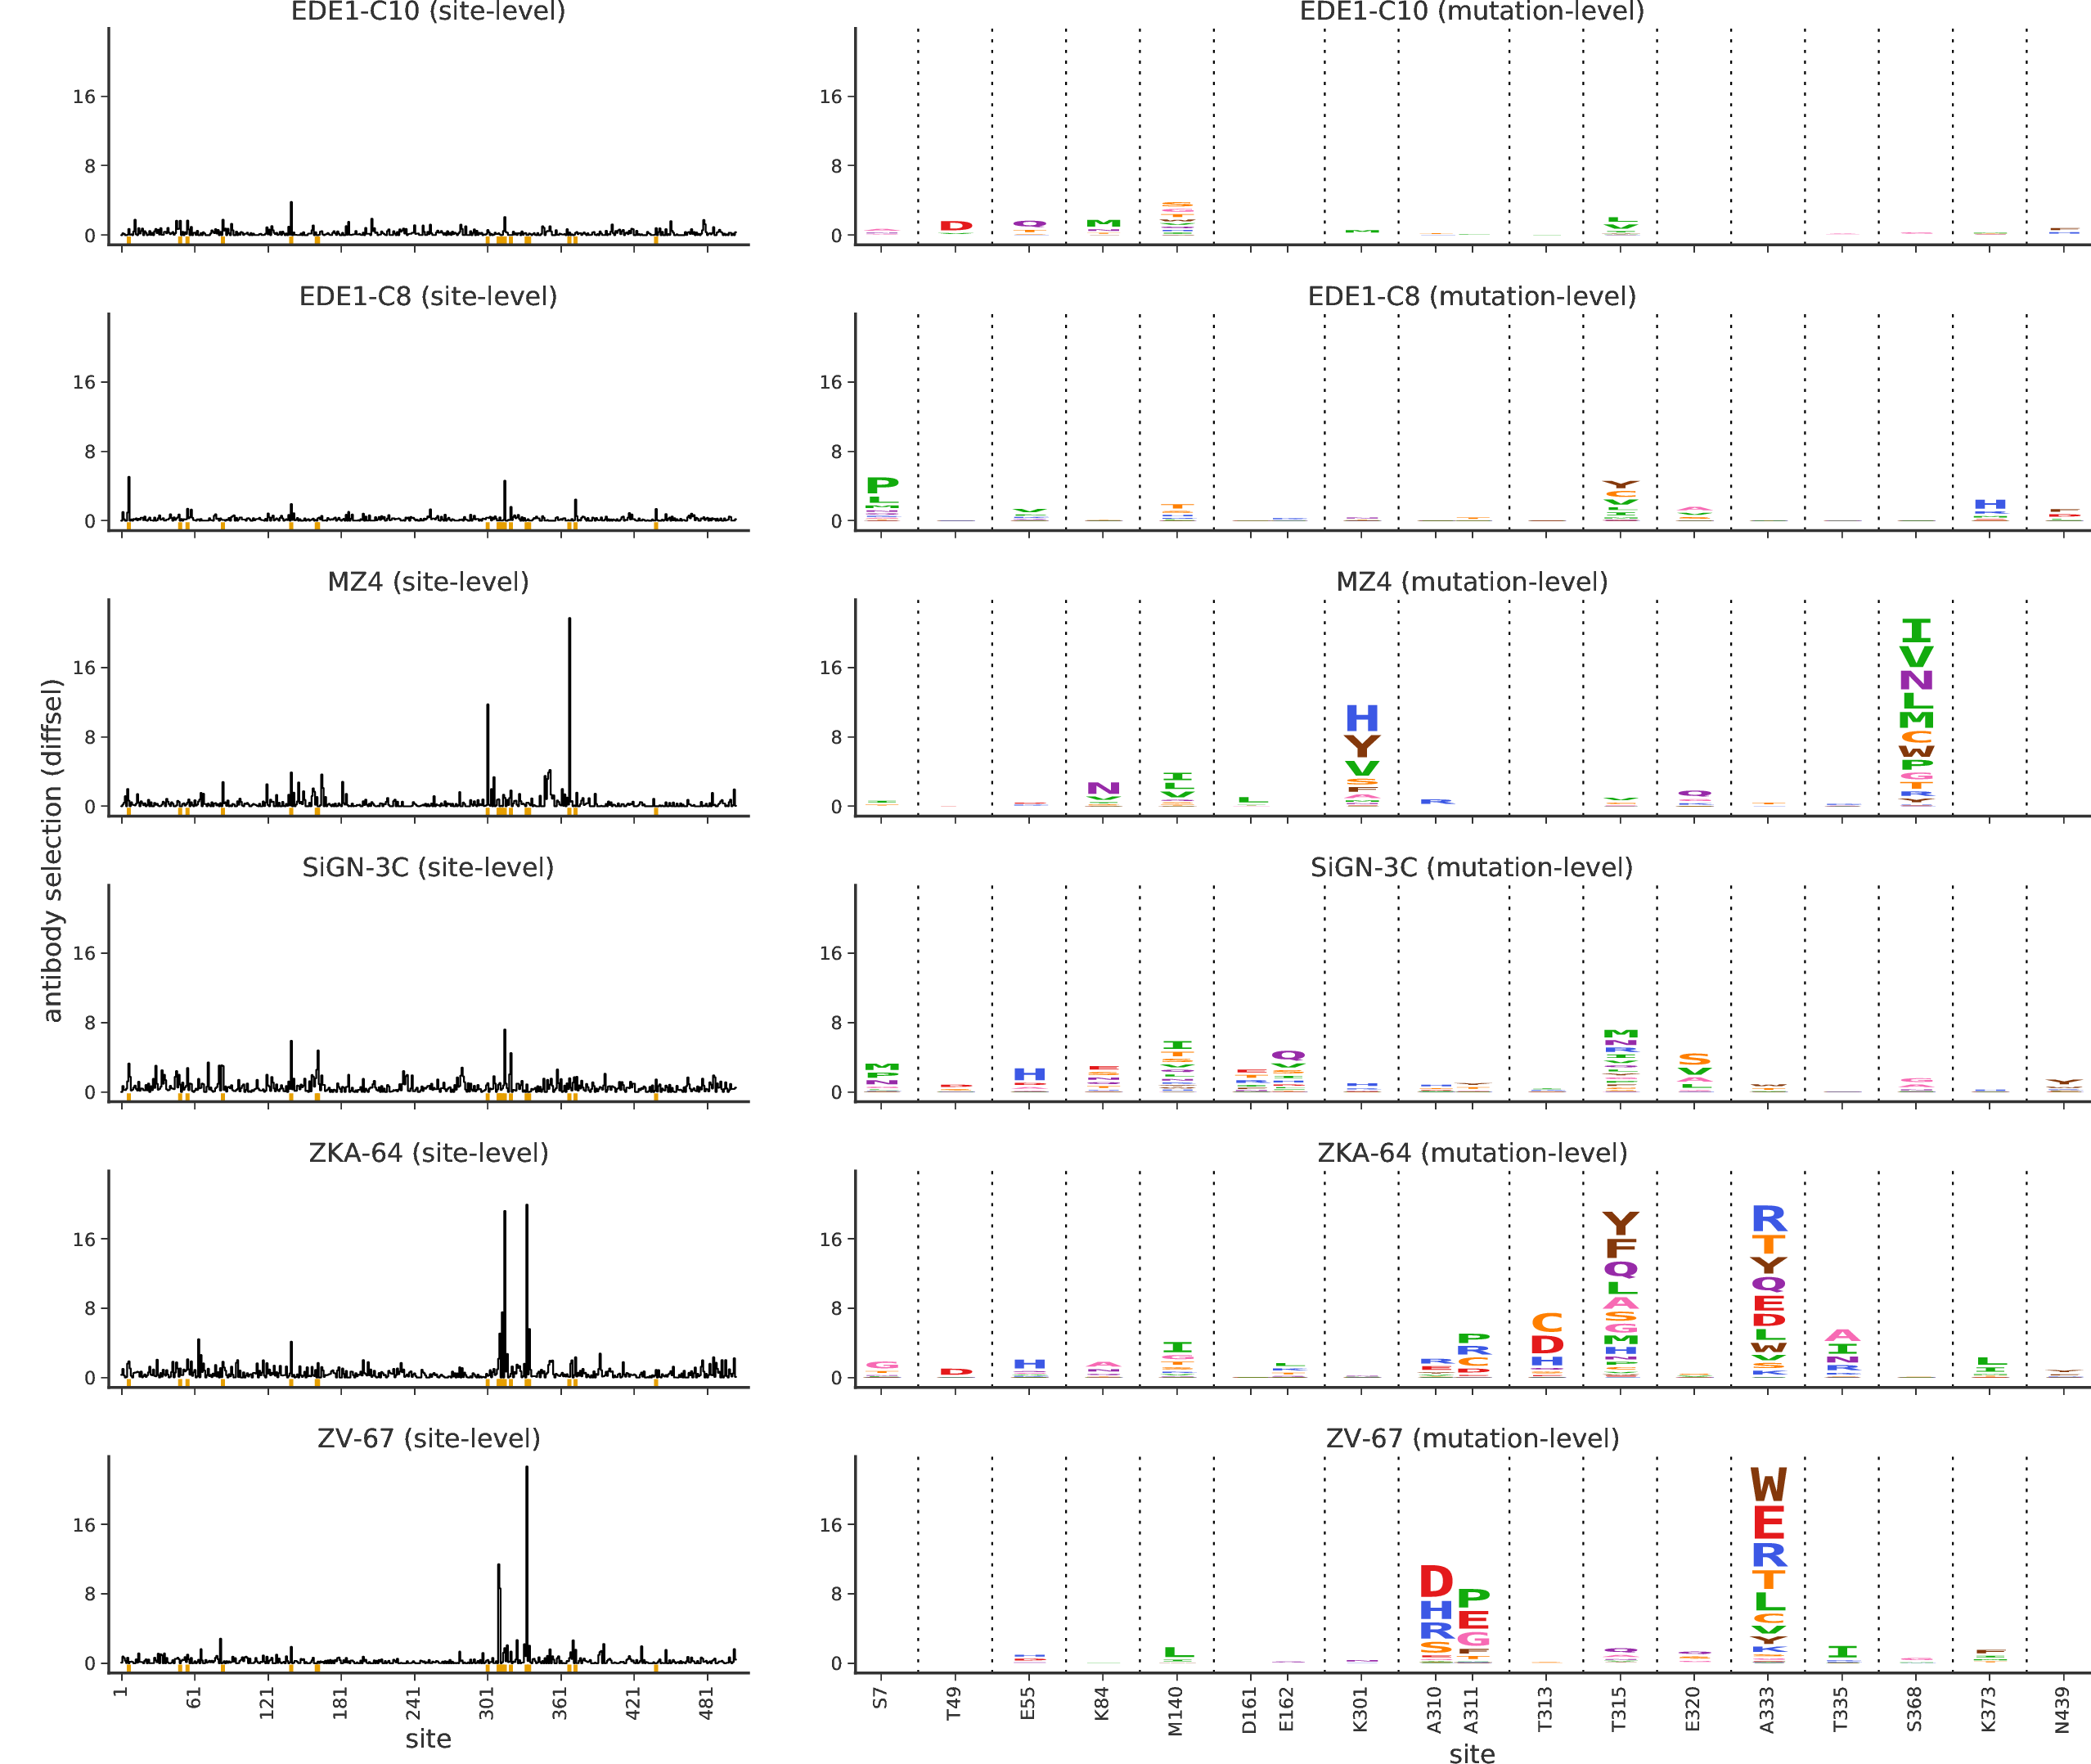

In [38]:
# ZKA_64 = 311, 313, 315, 333, 335
# ZV_67 = 310, 311, 333
# C10 = 12, 49, 55, 84, 140
# C8 = 7, 315, 373, 439

zoomsites = [311, 313, 315, 333, 335, # ZKA-64
             310, 311, 333, # ZV_67
             301, 368, #MZ4
             49, 55, 84, 140, # C10
             7, 315, 373, 439, # C8
             161, 162, 320] # Sign-3C, also incl 140 and 315 

antibodies = diffsel_batch.group.unique().tolist()

antibody_info = pd.DataFrame(
                 {'antibody': antibodies,
                  'sitediffsel_file': [os.path.join(diffseldir,
                                       f"summary_{a}-mediansitediffsel.csv") for
                                       a in antibodies],
                  'mutdiffsel_file': [os.path.join(diffseldir,
                                      f"summary_{a}-medianmutdiffsel.csv") for
                                      a in antibodies]
                  })

antibodydata = (dms_tools2.diffsel.df_read_filecols(antibody_info,
                                                    filecols=['sitediffsel_file',
                                                              'mutdiffsel_file'])
                .assign(show_site=lambda x: x['site'].isin(zoomsites),
                        site_label=lambda x: x['wildtype'] + x['site'].astype(str))
                )

fig, axes = dmslogo.facet_plot(
        antibodydata,
        gridrow_col='antibody',
        x_col='isite',
        show_col='show_site',
        draw_line_kwargs={'height_col': 'positive_diffsel',
                          'xtick_col': 'site',
                          'ylabel': 'antibody selection (diffsel)'},
        draw_logo_kwargs={'letter_col': 'mutation',
                          'letter_height_col': 'mutdiffsel',
                          'xtick_col': 'site_label',
                          'xlabel': 'site',
                          'clip_negative_heights': True,
                          'ylabel': ''},
        line_titlesuffix='(site-level)',
        logo_titlesuffix='(mutation-level)',
        )

antibodyzoom = os.path.join(figsdir, 'all_antibodies_zoom.pdf')
fig.savefig(antibodyzoom)
showPDF(antibodyzoom)

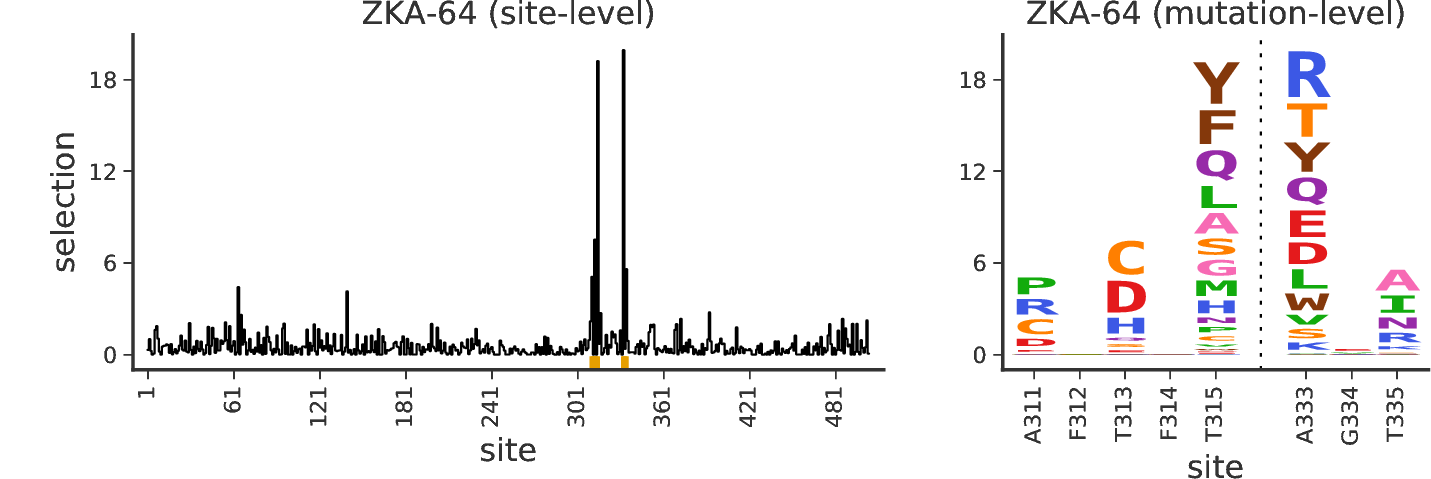

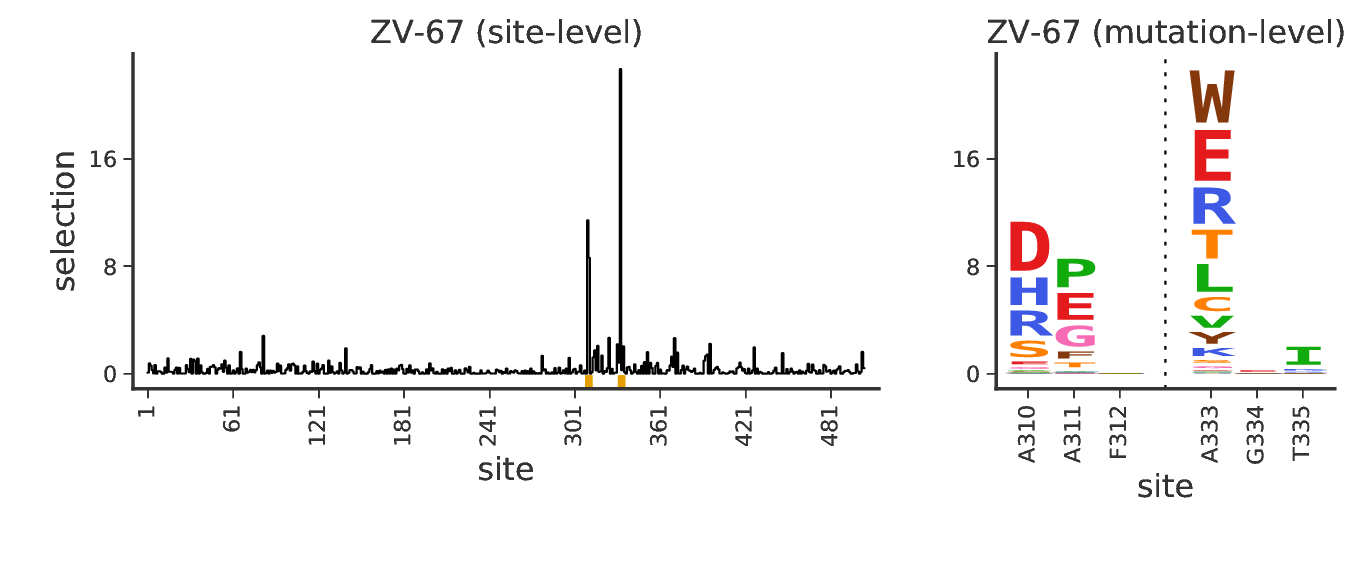

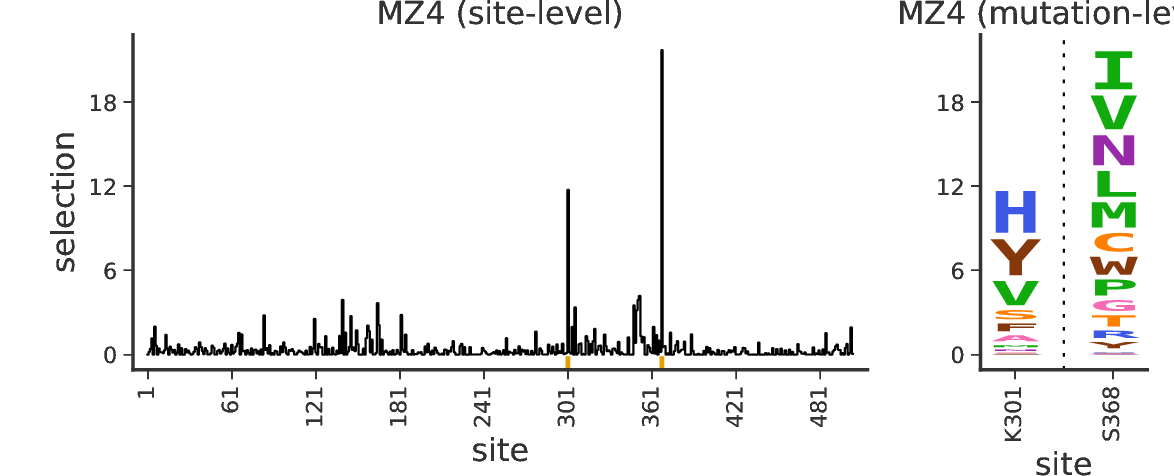

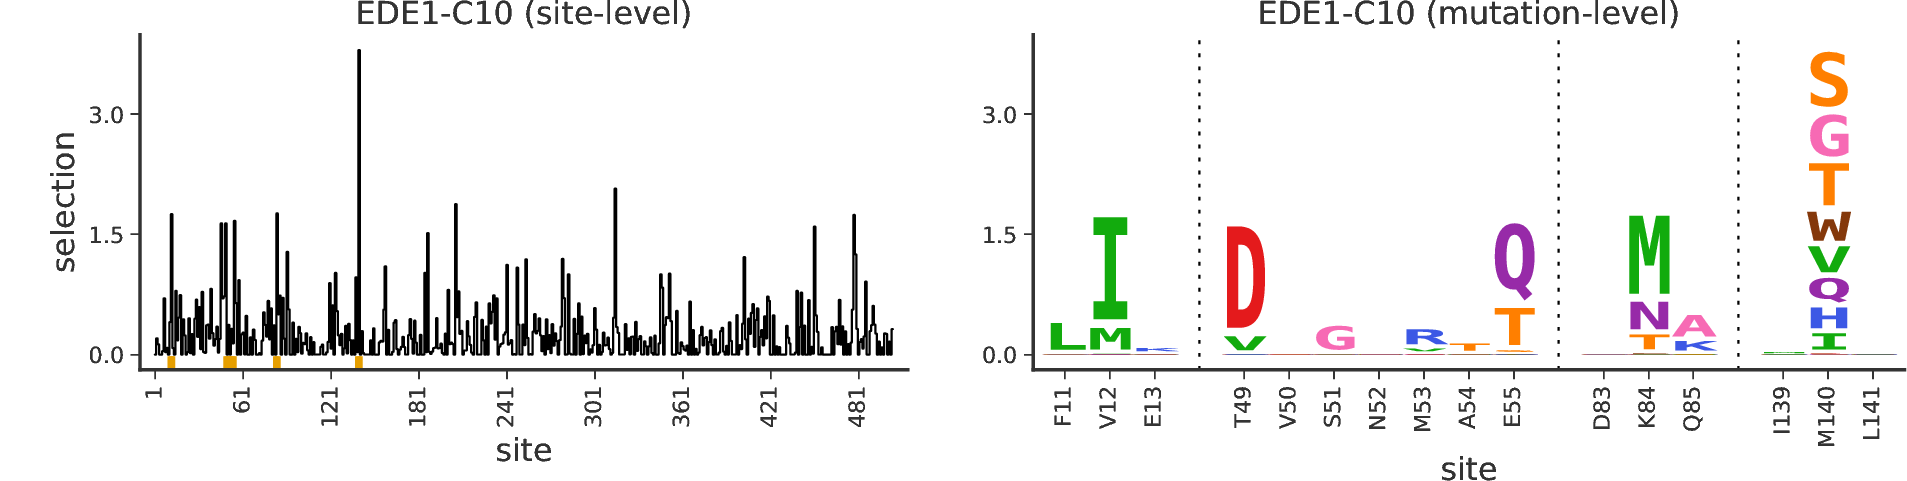

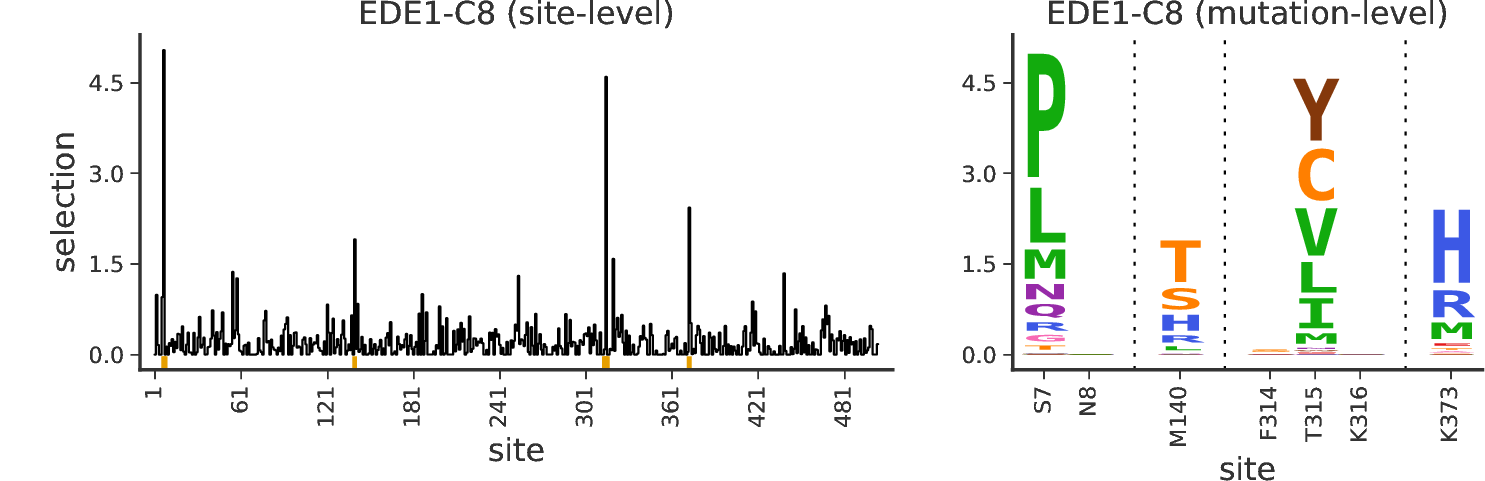

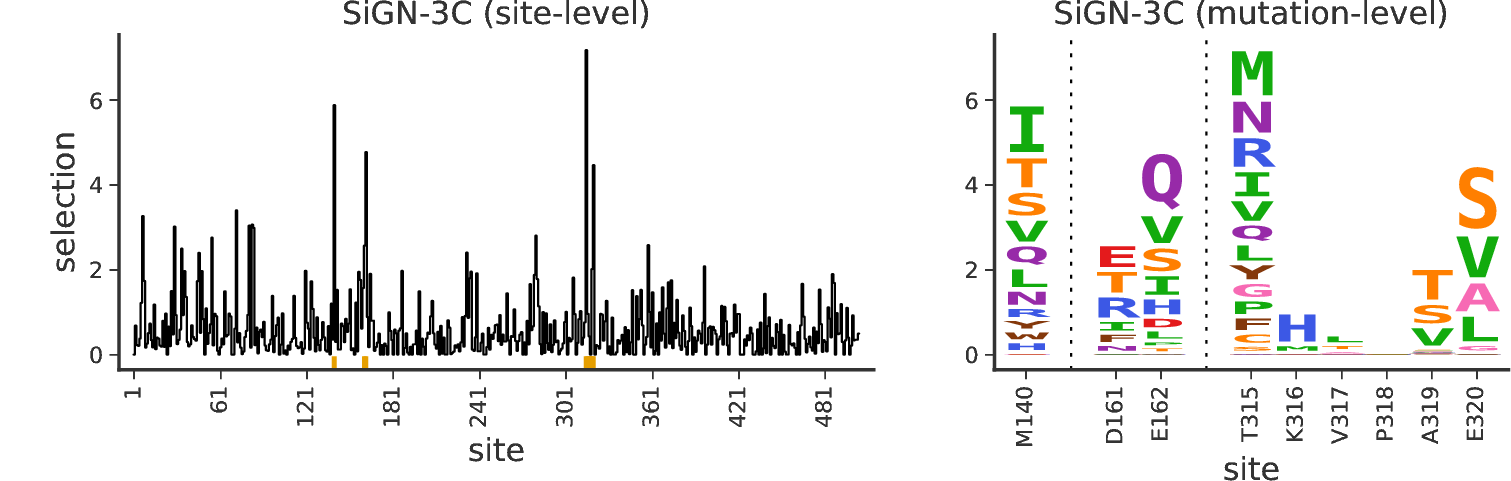

In [41]:
# ZKA_64 = 311, 313, 315, 333, 335
# ZV_67 = 310, 311, 333
# C10 = 12, 49, 55, 84, 140
# C8 = 7, 315, 373, 439

zoomsites = {'ZKA-64' : [311, 312, 313,314, 315, 333,334, 335],
             'ZV-67' : [310, 311,312,333,334, 335],
             'MZ4' : [301, 368],
             'EDE1-C10' : [11,12,13,
                           49,50,51,52,53,
                           54,55,
                           83,84,85,
                           139,140,141],
             'EDE1-C8' : [7,8, 140, 314,315,316, 373],
             'SiGN-3C' : [140, 161, 162, 315,316,317,318,319, 320]
            }
             
antibodies = zoomsites.keys()

for ab in antibodies:
    sites = zoomsites[ab]
    antibody_info = pd.DataFrame(
                     {'antibody': str(ab),
                      'sitediffsel_file': [os.path.join(diffseldir,
                                           f"summary_{ab}-mediansitediffsel.csv")],
                      'mutdiffsel_file': [os.path.join(diffseldir,
                                          f"summary_{ab}-medianmutdiffsel.csv")]
                      })

    antibodydata = (dms_tools2.diffsel.df_read_filecols(antibody_info,
                                                        filecols=['sitediffsel_file',
                                                                  'mutdiffsel_file'])
                    .assign(show_site=lambda x: x['site'].isin(sites),
                            site_label=lambda x: x['wildtype'] + x['site'].astype(str))
                    )

    fig, axes = dmslogo.facet_plot(
            antibodydata,
            gridrow_col='antibody',
            x_col='isite',
            show_col='show_site',
            draw_line_kwargs={'height_col': 'positive_diffsel',
                              'xtick_col': 'site',
                              'ylabel': 'selection'},
            draw_logo_kwargs={'letter_col': 'mutation',
                              'letter_height_col': 'mutdiffsel',
                              'xtick_col': 'site_label',
                              'xlabel': 'site',
                              'clip_negative_heights': True,
                              'ylabel': ''},
            line_titlesuffix='(site-level)',
            logo_titlesuffix='(mutation-level)',
            )

    antibodyzoom = os.path.join(figsdir, f'{ab}_zoom.pdf')
    fig.savefig(antibodyzoom)
    showPDF(antibodyzoom)

In [40]:
antibodies = zoomsites.keys()
for ab in antibodies:
    print(ab)

ZKA-64
ZV-67
MZ4
EDE1-C10
EDE1-C8
SiGN-3C
